In [1]:
import sys
print(sys.executable)



c:\Users\91832\Desktop\RAG_Model_development\New\Scripts\python.exe


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import fitz  # PyMuPDF
import pdfplumber
import camelot
from datetime import datetime
import shutil
import missingno as msno
import nltk
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from nltk.corpus import stopwords
from collections import Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from textblob import TextBlob
from transformers import pipeline
import re
import faiss


In [3]:

# Step 2: Define the specific file path 
pdf_path = "C:/Users/91832/Desktop/RAG_Model_development/notebook/Sample Financial Statement.pdf"

# Step 3: Process the specific PDF file
if os.path.exists(pdf_path):
    print(f"Processing file: {pdf_path}")

    # Open and process the PDF
    doc = fitz.open(pdf_path)
    print(f"Number of pages in the PDF: {len(doc)}")

    # Example: Extract text or tables from the PDF
    for page_num in range(len(doc)):
        page = doc[page_num]
        text = page.get_text()
        print(f"Page {page_num + 1} Text: {text[:10]}...")  # Display the first 200 characters of the page

    doc.close()
else:
    print(f"File not found: {pdf_path}")

Processing file: C:/Users/91832/Desktop/RAG_Model_development/notebook/Sample Financial Statement.pdf
Number of pages in the PDF: 40
Page 1 Text: Index
Page...
Page 2 Text: INFOSYS LI...
Page 3 Text: INFOSYS LI...
Page 4 Text: INFOSYS LI...
Page 5 Text: Condensed ...
Page 6 Text: INFOSYS LI...
Page 7 Text: Cash flows...
Page 8 Text: INFOSYS LI...
Page 9 Text: 1.5 Critic...
Page 10 Text: e. Impairm...
Page 11 Text: 2. Notes t...
Page 12 Text: Proposed a...
Page 13 Text: 2.2 PROPER...
Page 14 Text: The change...
Page 15 Text: 2.3 GOODWI...
Page 16 Text: 2.4
INVEST...
Page 17 Text: 2.5
LOANS
...
Page 18 Text: 2.8
CASH A...
Page 19 Text: 2.10 FINAN...
Page 20 Text: 2.10.4 Fai...
Page 21 Text: The carryi...
Page 22 Text: The fair v...
Page 23 Text: 2.11 EQUIT...
Page 24 Text: (In ₹ cror...
Page 25 Text: The follow...
Page 26 Text: 2.12  OTHE...
Page 27 Text: 2.14  PROV...
Page 28 Text: Accounting...
Page 29 Text: 2.16 REVEN...
Page 30 Text: (In ₹ cror...
Page 31 Text: 2.17 OTHER...
Page 32 

In [4]:

def parse_pdf_holistically(pdf_path, output_folder="bot_raw_data"):
    # Reset output folders if they already exist
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
        print(f"Removed existing folder: {output_folder}")

    os.makedirs(output_folder, exist_ok=True)
    text_folder = os.path.join(output_folder, "text")
    table_folder = os.path.join(output_folder, "table")
    os.makedirs(text_folder, exist_ok=True)
    os.makedirs(table_folder, exist_ok=True)

    # Generate timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Step 1: Extract text and save to text folder
    print("Extracting text with pdfplumber...")
    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages):
            try:
                text = page.extract_text()
                if text:
                    text_file_path = os.path.join(text_folder, f"page_{i + 1}_{timestamp}.txt")
                    with open(text_file_path, "w", encoding="utf-8") as text_file:
                        text_file.write(text)
                    print(f"Page {i + 1}: Text saved to {text_file_path}")
                else:
                    print(f"Page {i + 1}: No text found.")
            except Exception as e:
                print(f"Page {i + 1}: Error extracting text: {e}")

    # Step 2: Extract tables with Camelot
    print("Extracting tables with Camelot...")
    valid_tables = 0
    skipped_pages = []

    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages):
            page_number = i + 1
            try:
                tables = camelot.read_pdf(pdf_path, pages=str(page_number), flavor="stream")
                if len(tables) > 0:
                    for j, table in enumerate(tables):
                        table_file_path = os.path.join(
                            table_folder, f"table_page_{page_number}_table_{j + 1}_{timestamp}.csv"
                        )
                        table.df.to_csv(table_file_path, index=False)
                        print(f"Page {page_number}: Table {j + 1} saved to {table_file_path}")
                        valid_tables += 1
                else:
                    print(f"Page {page_number}: No tables detected.")
            except Exception as e:
                print(f"Page {page_number}: Error extracting table: {e}")
                skipped_pages.append(page_number)

    # Step 3: Fallback for skipped pages using pdfplumber
    print("Attempting fallback for skipped pages...")
    for page_number in skipped_pages:
        try:
            with pdfplumber.open(pdf_path) as pdf:
                page = pdf.pages[page_number - 1]
                table = page.extract_table()
                if table:
                    df = pd.DataFrame(table[1:], columns=table[0])
                    fallback_file_path = os.path.join(
                        table_folder, f"fallback_table_page_{page_number}_{timestamp}.csv"
                    )
                    df.to_csv(fallback_file_path, index=False)
                    print(f"Fallback table saved for page {page_number} to {fallback_file_path}")
        except Exception as e:
            print(f"Page {page_number}: Fallback failed with error: {e}")

    # Step 4: Log skipped pages and valid table count
    print(f"Total valid tables extracted: {valid_tables}")
    if skipped_pages:
        print(f"Skipped pages due to errors: {skipped_pages}")
        skipped_pages_file = os.path.join(output_folder, "skipped_pages.txt")
        with open(skipped_pages_file, "w") as log_file:
            log_file.write("\n".join(map(str, skipped_pages)))
        print(f"Skipped pages logged to {skipped_pages_file}")

    # Step 5: Combine all valid tables into one CSV
    print("Combining all valid tables...")
    all_csv_files = [
        os.path.join(table_folder, f) for f in os.listdir(table_folder) if f.endswith(".csv")
    ]
    if all_csv_files:
        combined_tables = pd.concat([pd.read_csv(file) for file in all_csv_files], ignore_index=True)
        combined_csv_path = os.path.join(output_folder, f"combined_tables_{timestamp}.csv")
        combined_tables.to_csv(combined_csv_path, index=False)
        print(f"All valid tables combined and saved to {combined_csv_path}")
    else:
        print("No valid tables to combine.")

    return text_folder, table_folder, skipped_pages

# Example usage
pdf_path = "C:/Users/91832/Desktop/RAG_Model_development/notebook/Sample Financial Statement.pdf"

output_folder = "bot_raw_data"  # Folder to save output
text_folder, table_folder, skipped_pages = parse_pdf_holistically(pdf_path, output_folder)


Removed existing folder: bot_raw_data
Extracting text with pdfplumber...
Page 1: Text saved to bot_raw_data\text\page_1_20250124_104725.txt
Page 2: Text saved to bot_raw_data\text\page_2_20250124_104725.txt
Page 3: Text saved to bot_raw_data\text\page_3_20250124_104725.txt
Page 4: Text saved to bot_raw_data\text\page_4_20250124_104725.txt
Page 5: Text saved to bot_raw_data\text\page_5_20250124_104725.txt
Page 6: Text saved to bot_raw_data\text\page_6_20250124_104725.txt
Page 7: Text saved to bot_raw_data\text\page_7_20250124_104725.txt
Page 8: Text saved to bot_raw_data\text\page_8_20250124_104725.txt
Page 9: Text saved to bot_raw_data\text\page_9_20250124_104725.txt
Page 10: Text saved to bot_raw_data\text\page_10_20250124_104725.txt
Page 11: Text saved to bot_raw_data\text\page_11_20250124_104725.txt
Page 12: Text saved to bot_raw_data\text\page_12_20250124_104725.txt
Page 13: Text saved to bot_raw_data\text\page_13_20250124_104725.txt
Page 14: Text saved to bot_raw_data\text\page_14

In [5]:


# Define the folder and zip file paths
folder_to_zip = "bot_raw_data"  # The folder to compress
zip_file_path = "bot_raw_data.zip"  # The resulting zip file

# Create the zip file
shutil.make_archive(base_name=folder_to_zip, format="zip", root_dir=folder_to_zip)

print(f"Zip file created at: {zip_file_path}")

Zip file created at: bot_raw_data.zip


Missing Values for table_page_10_table_1_20250124_104725.csv:
0    0
dtype: int64


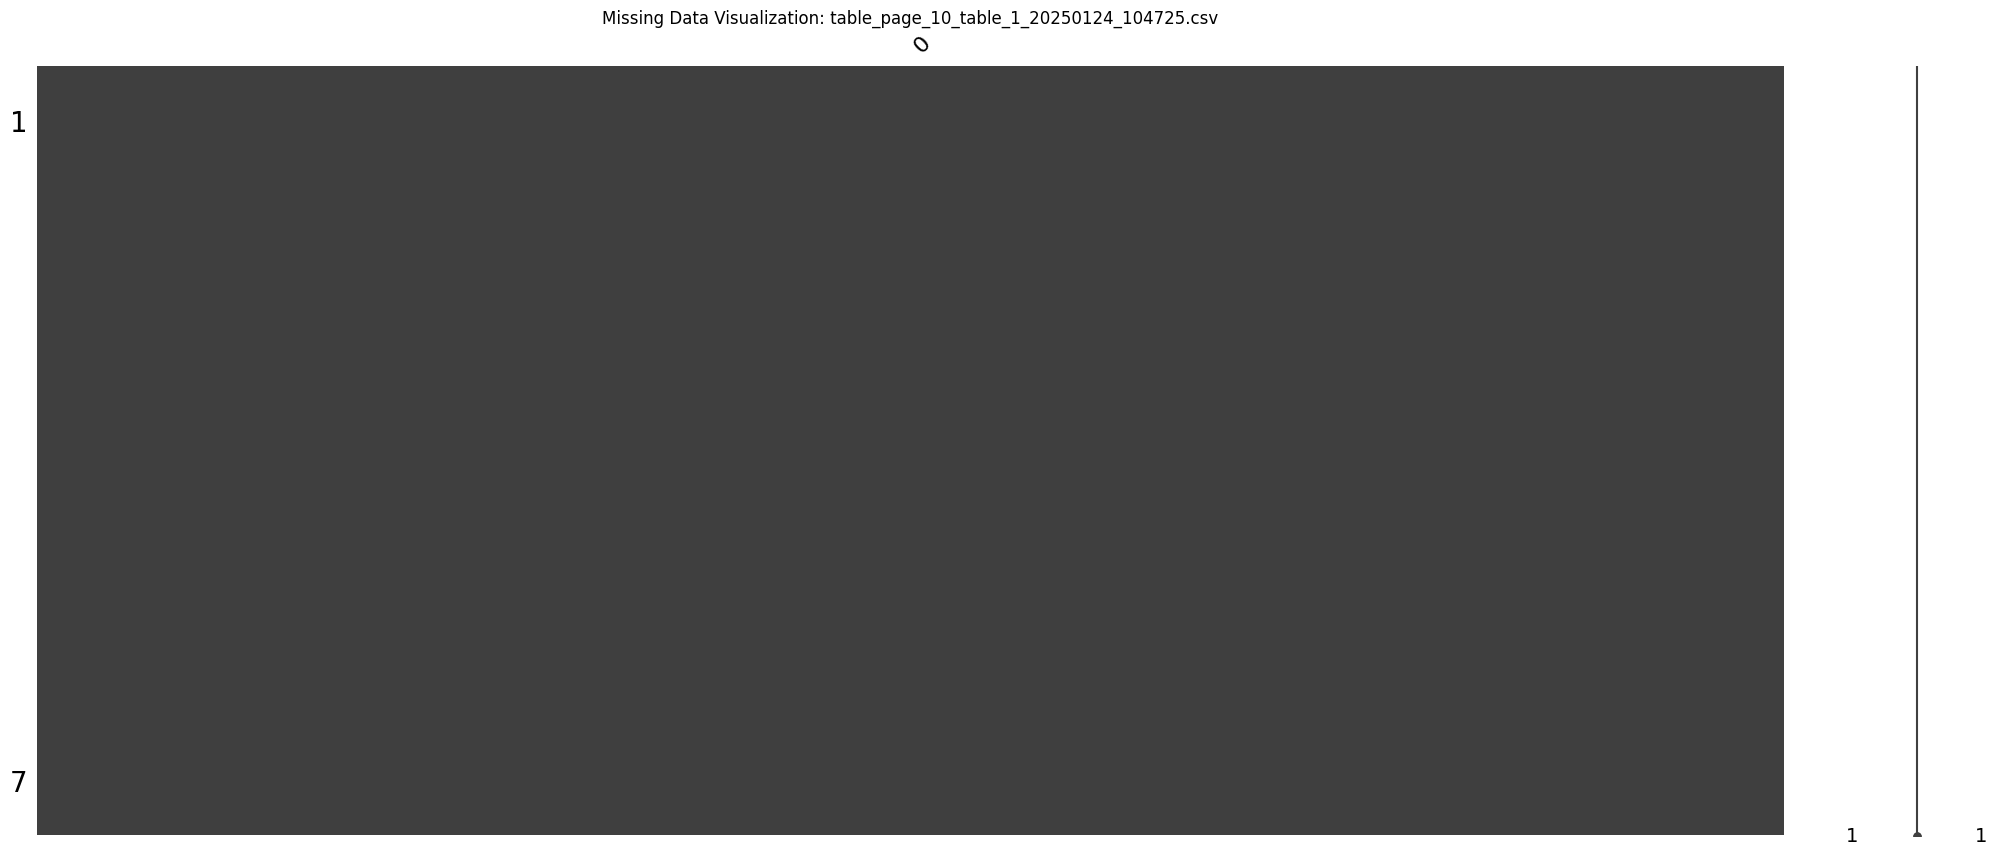

Missing Values for table_page_11_table_1_20250124_104725.csv:
0    0
dtype: int64


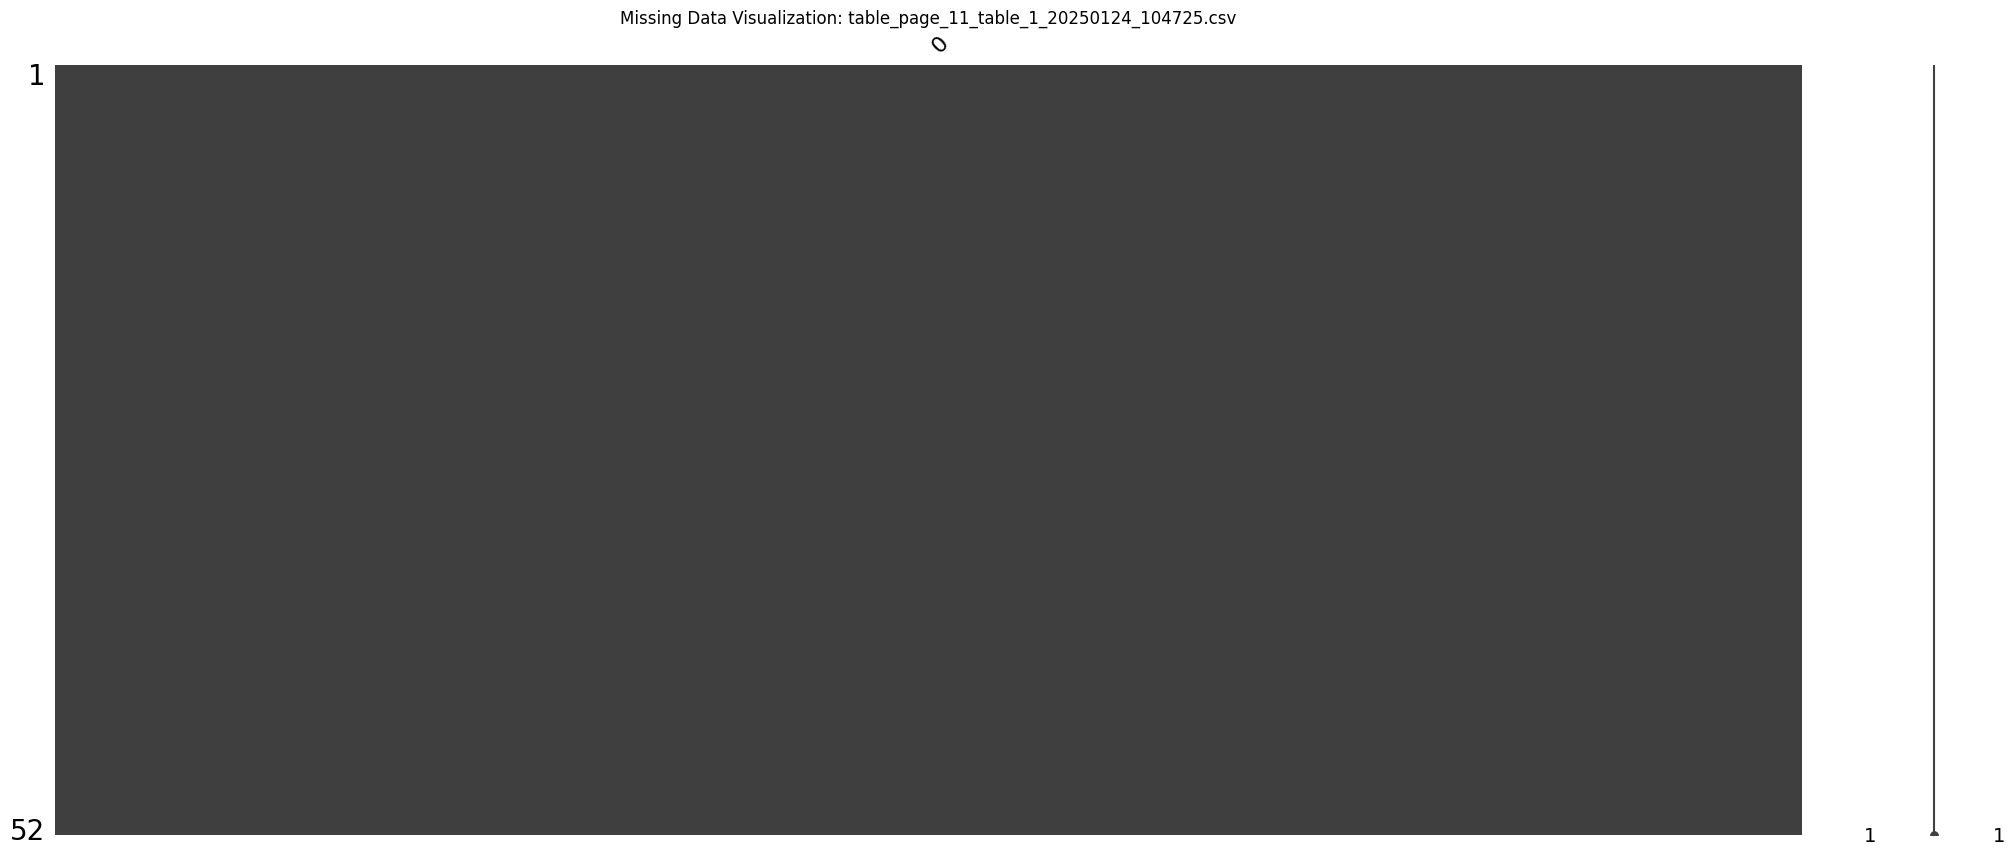

Missing Values for table_page_12_table_1_20250124_104725.csv:
0    0
dtype: int64


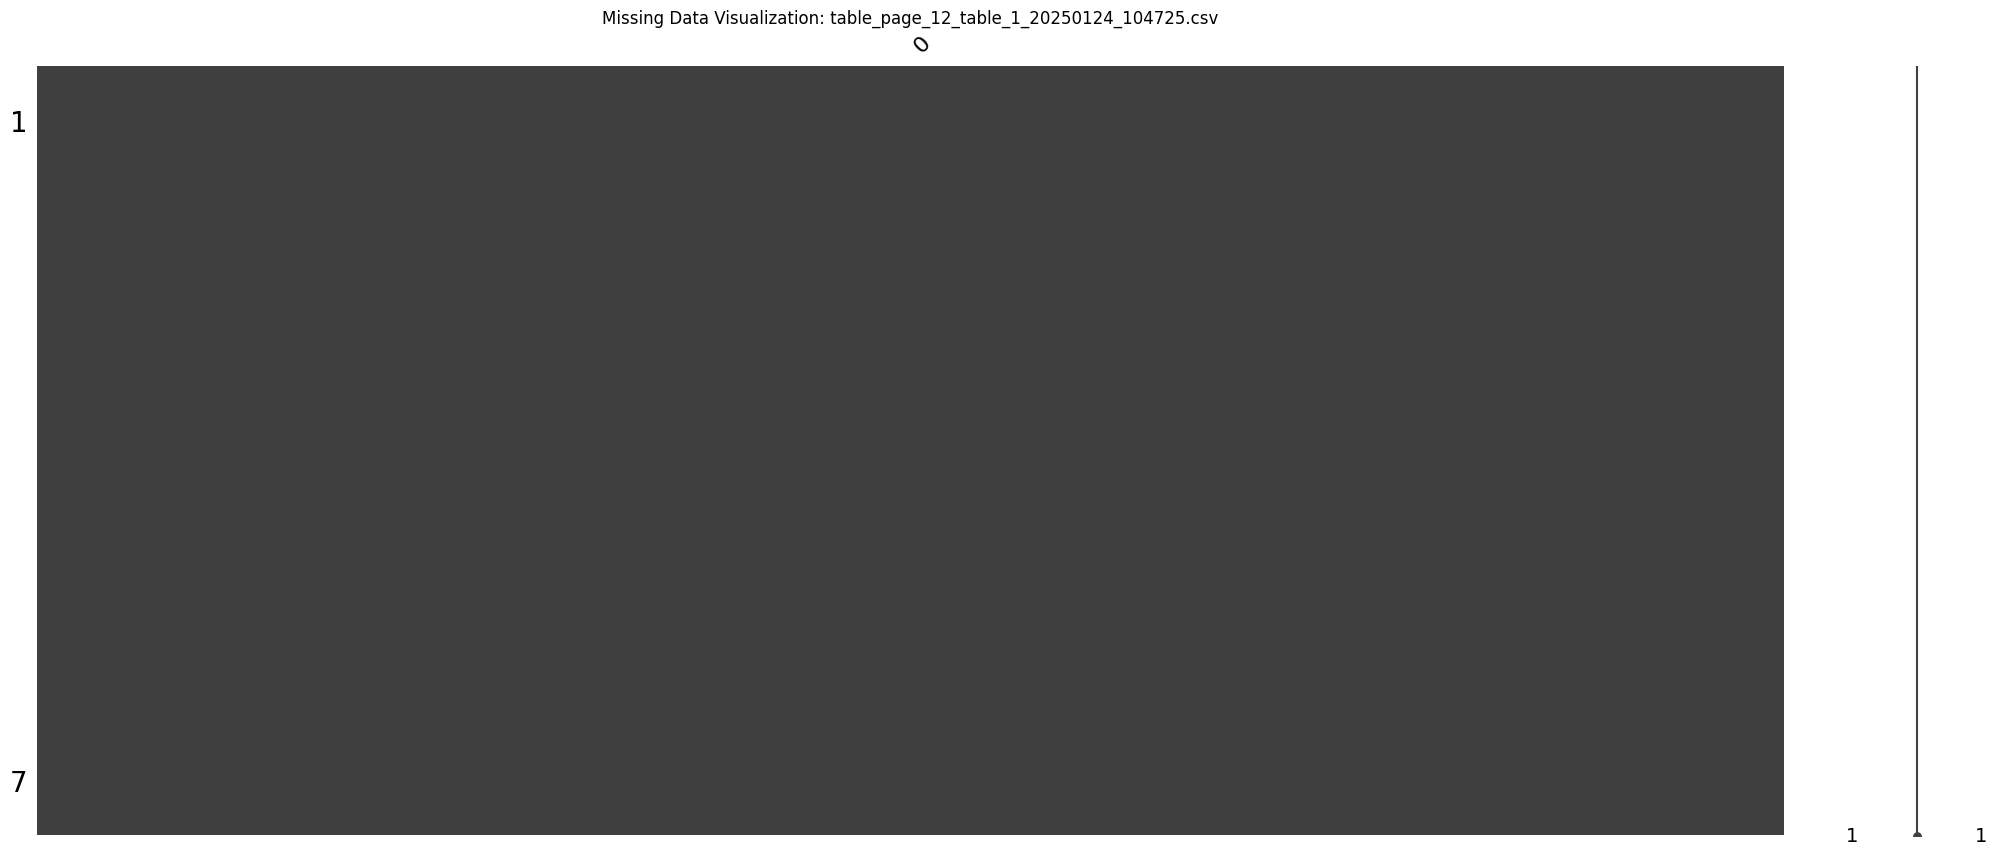

Missing Values for table_page_13_table_1_20250124_104725.csv:
0    4
1    6
2    3
3    3
4    3
5    3
6    3
7    3
8    4
9    3
dtype: int64


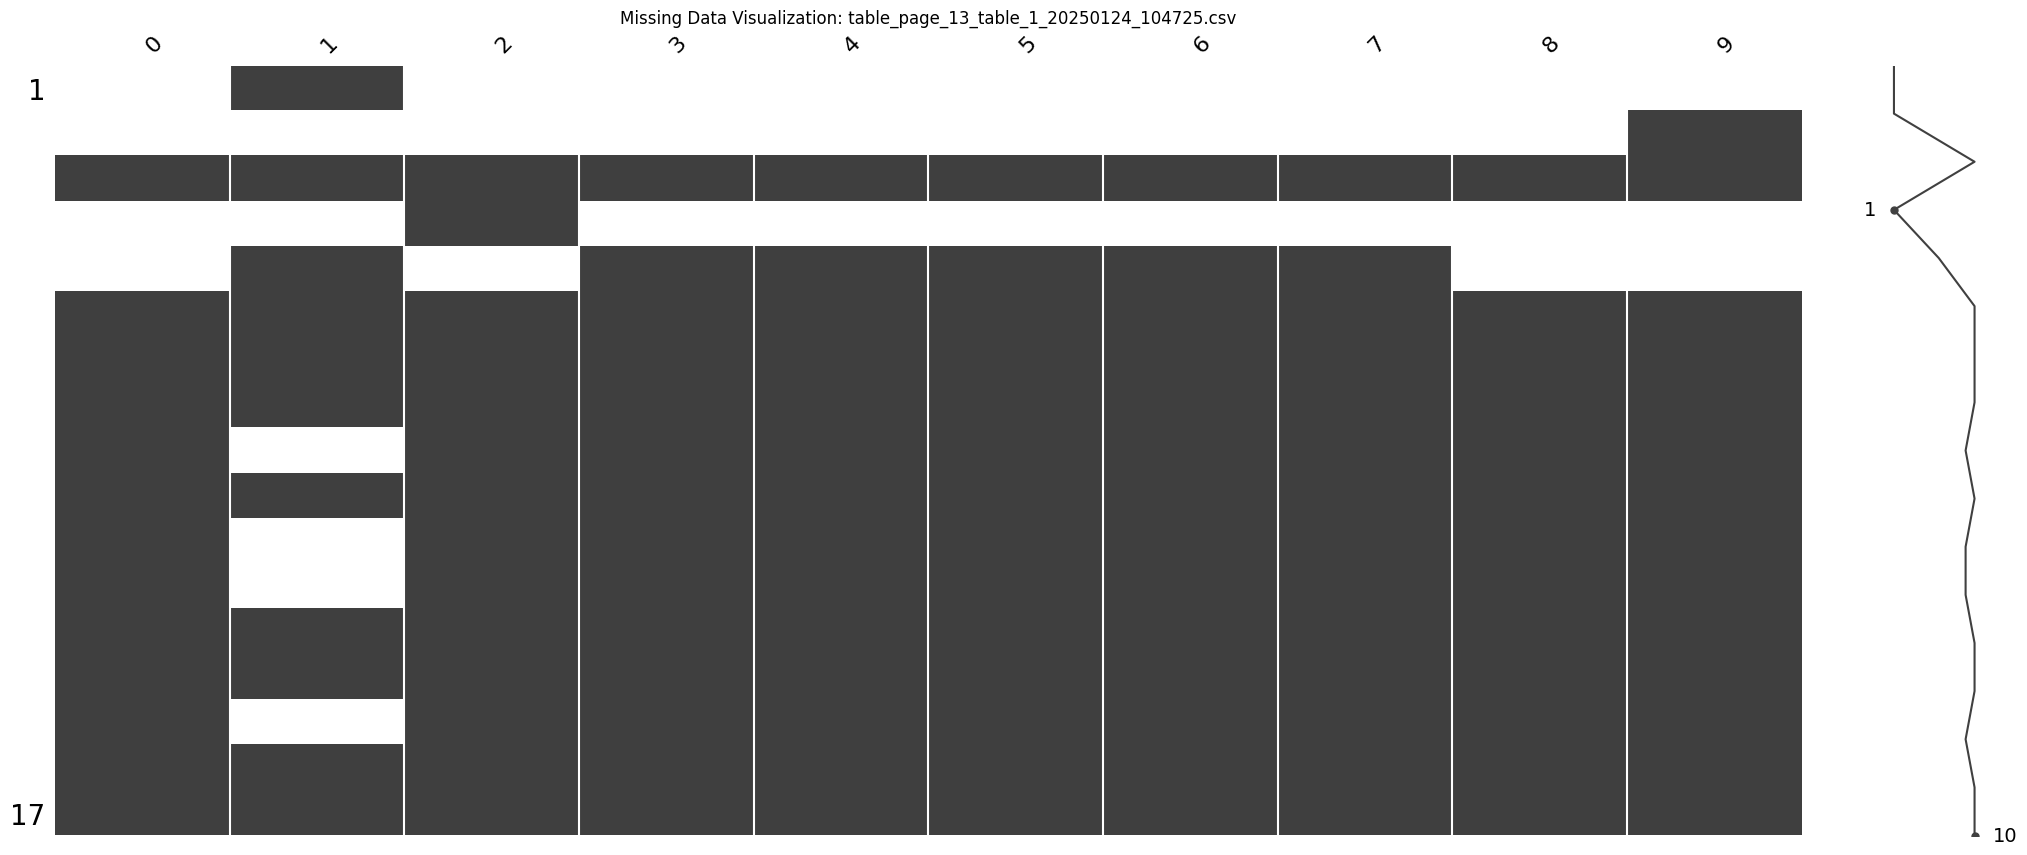

Missing Values for table_page_13_table_2_20250124_104725.csv:
0    18
1    20
2    32
3    35
4    35
5    35
6    33
7    35
8    38
9    31
dtype: int64


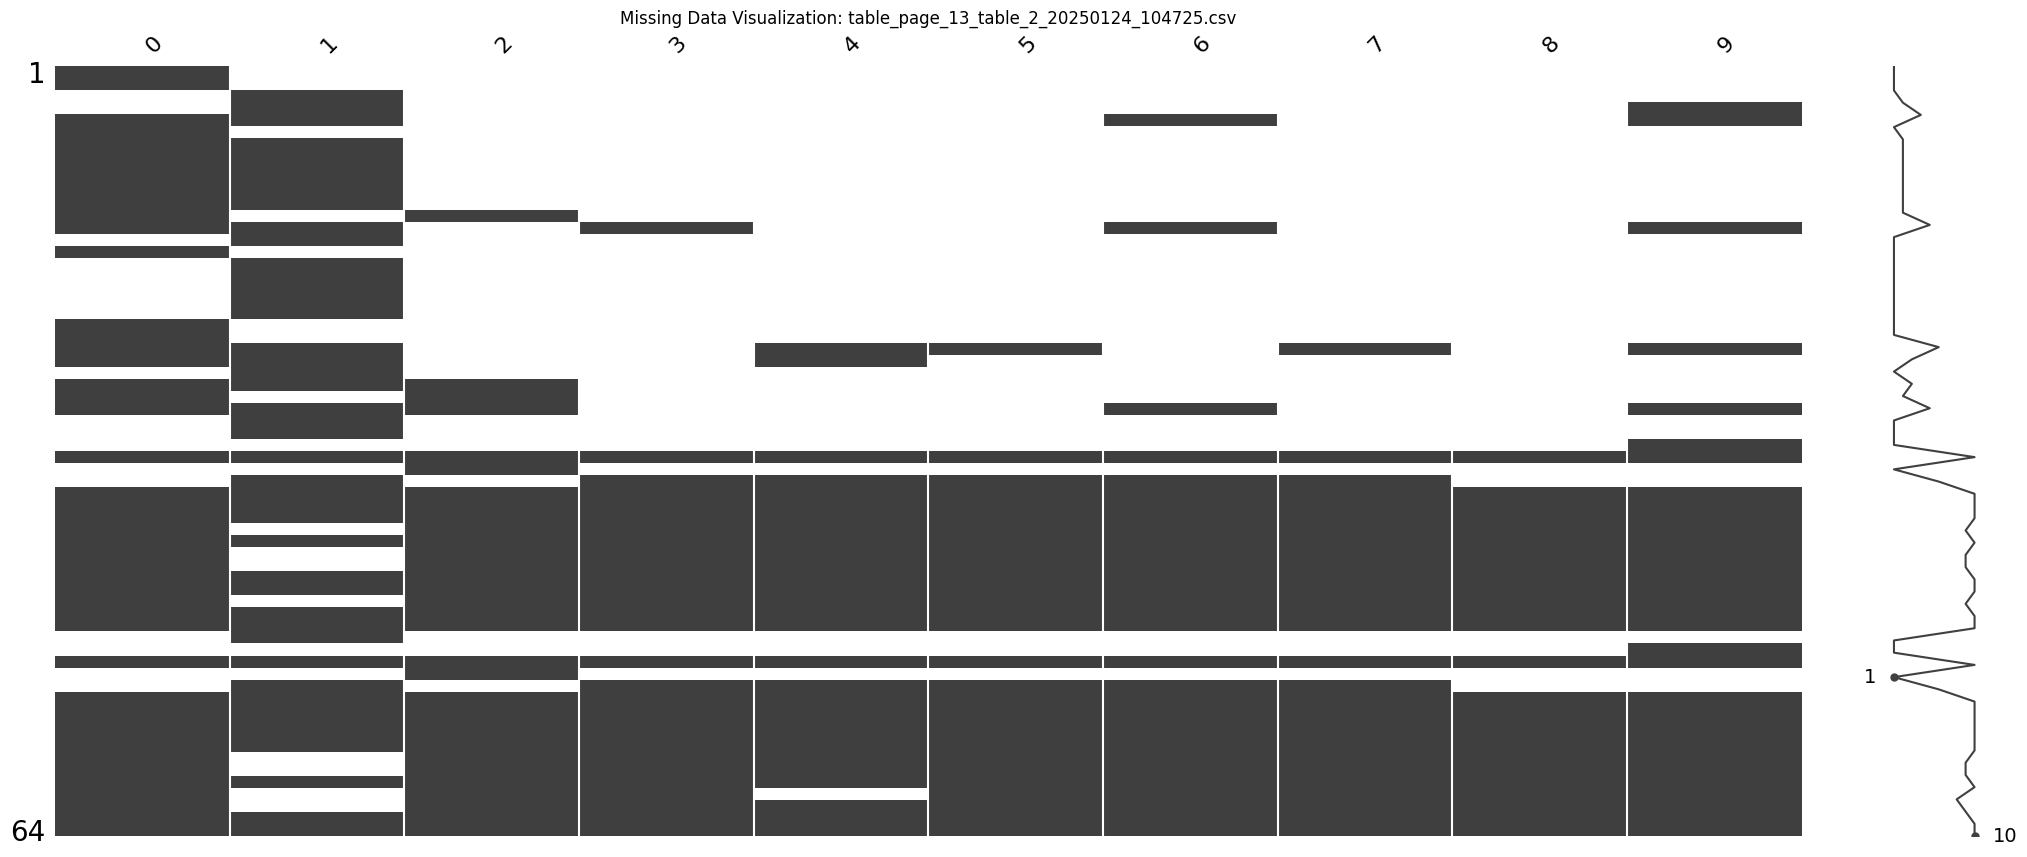

Missing Values for table_page_14_table_1_20250124_104725.csv:
0    17
1    15
2    17
3    17
4    15
5    16
6    16
7    18
8    19
9    17
dtype: int64


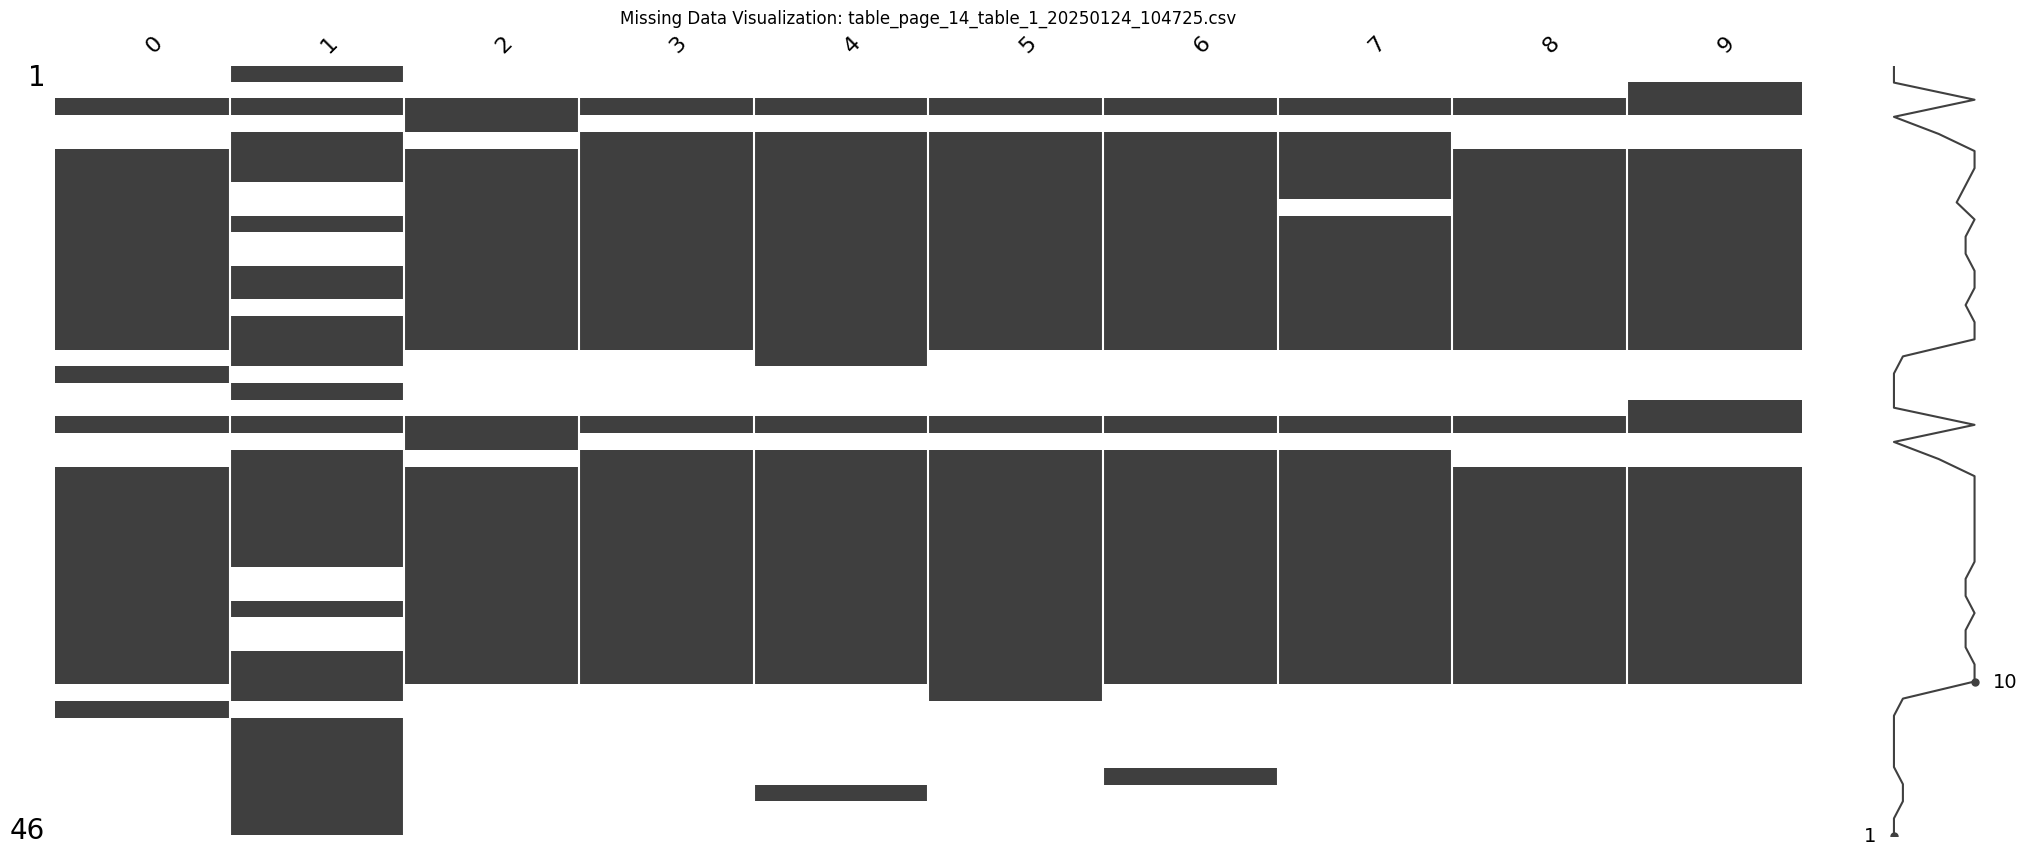

Missing Values for table_page_15_table_1_20250124_104725.csv:
0    0
dtype: int64


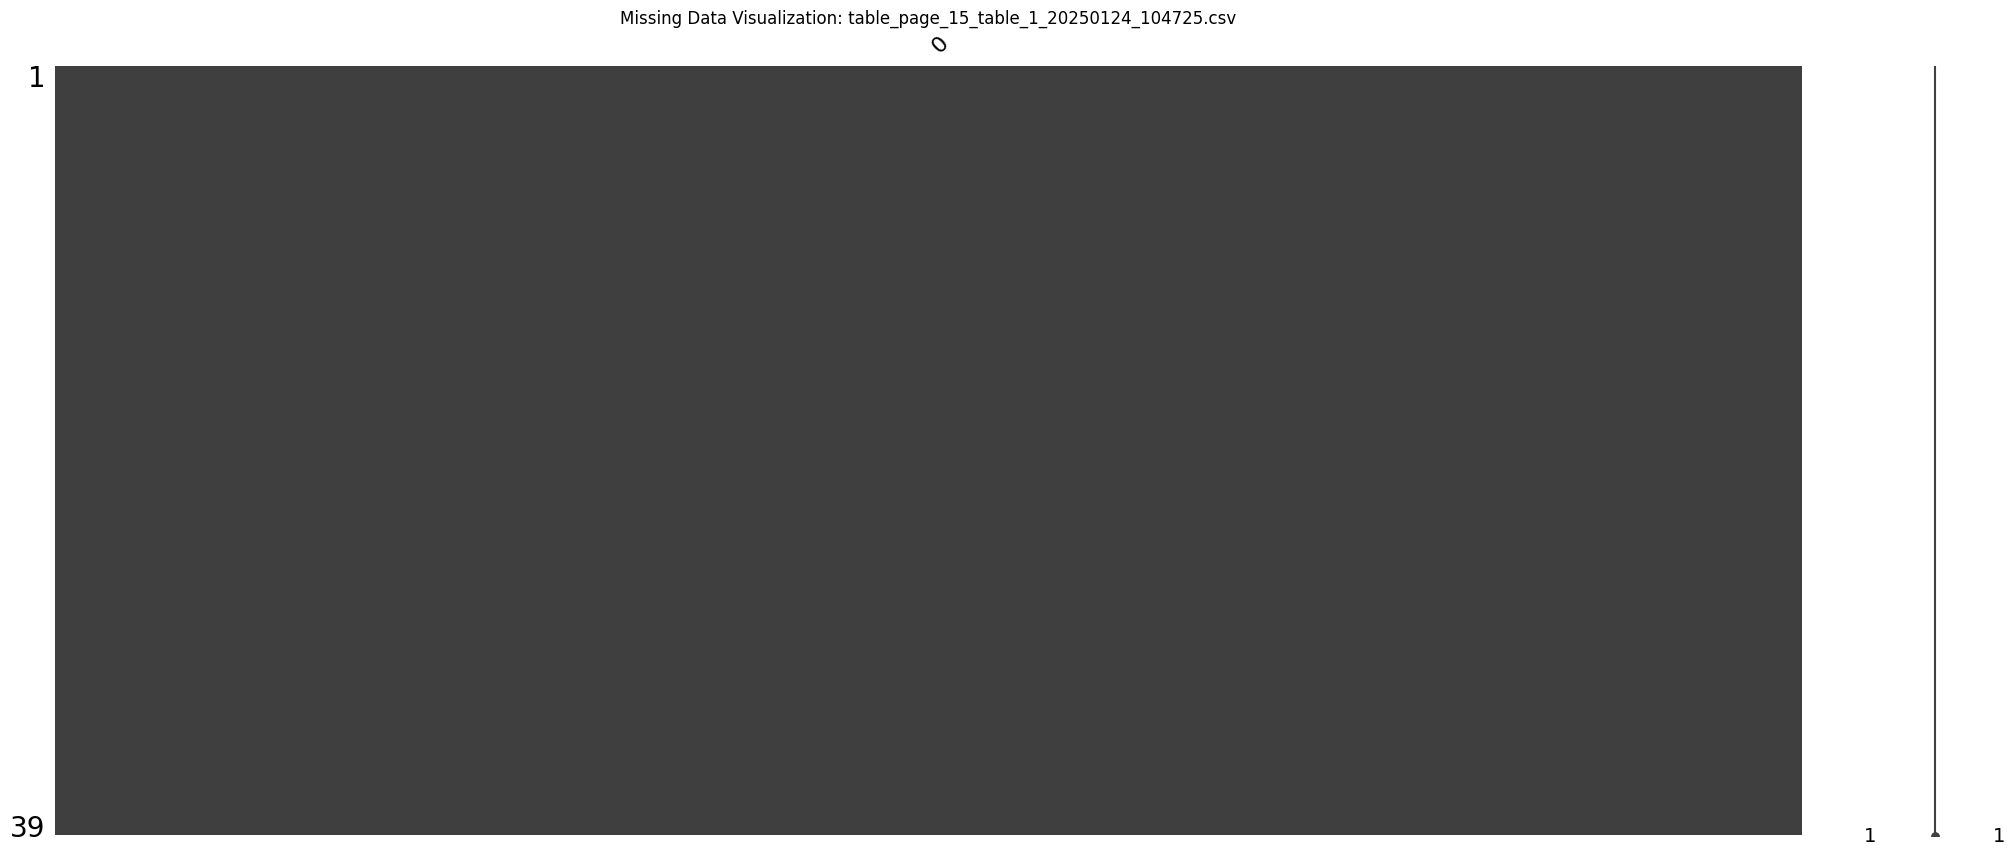

Missing Values for table_page_16_table_1_20250124_104725.csv:
0    4
1    7
2    7
dtype: int64


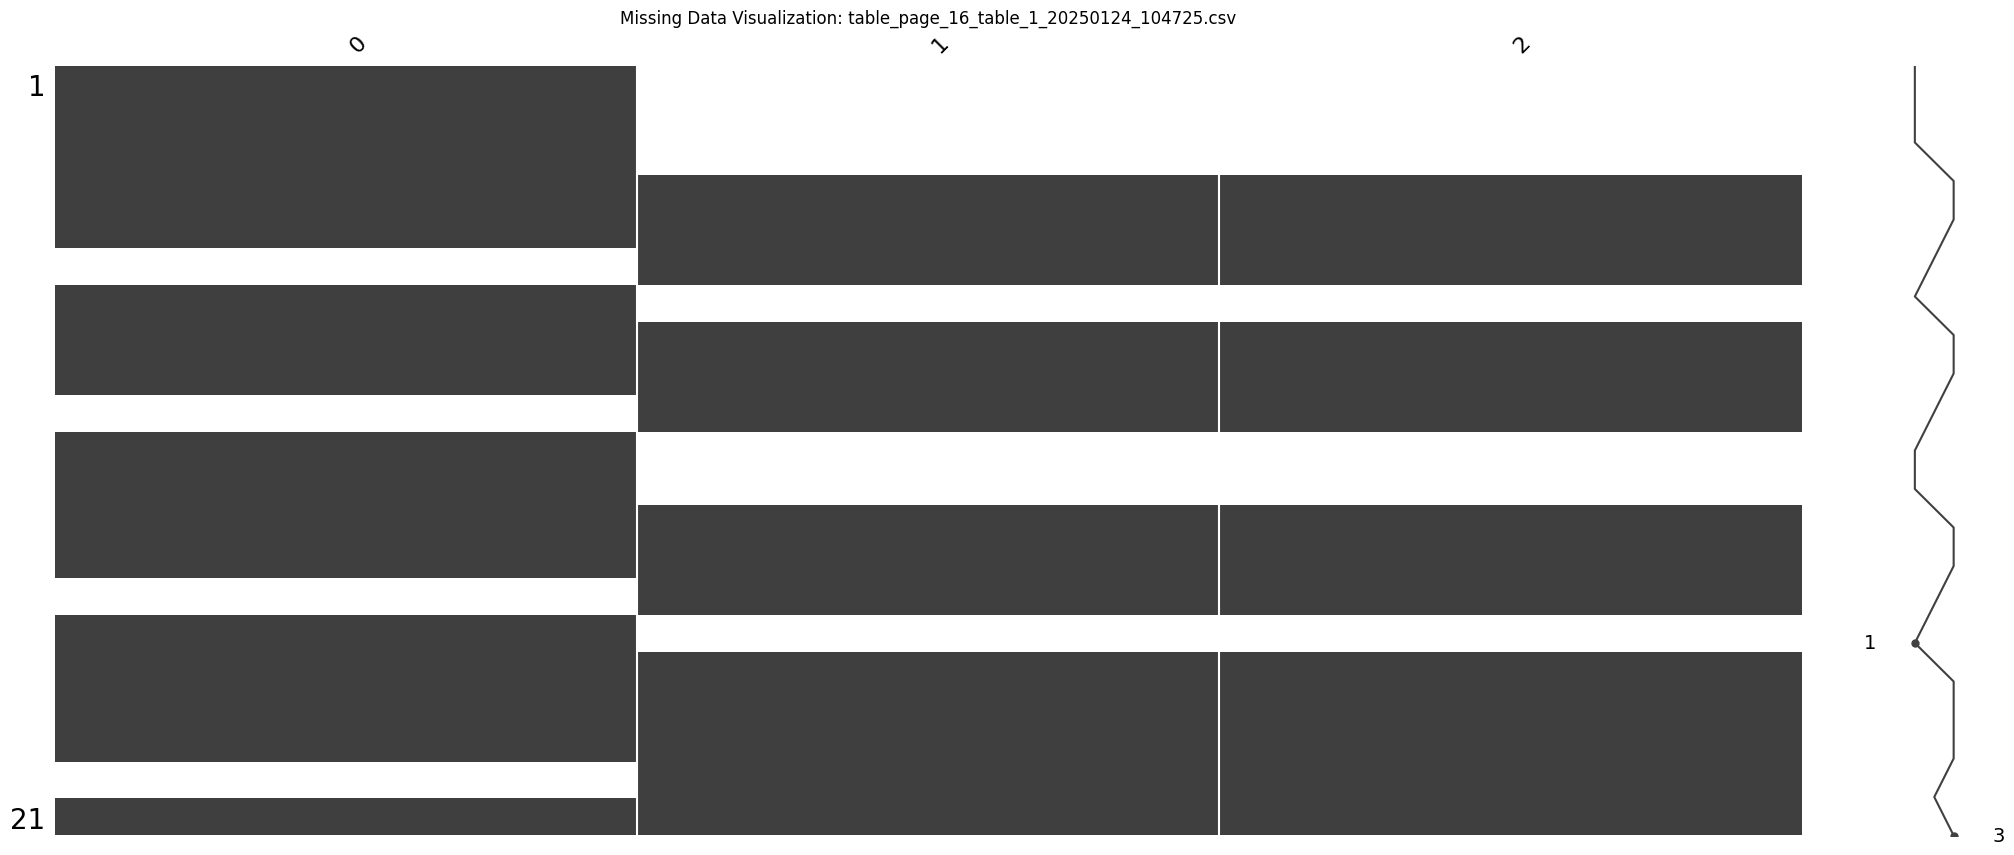

Missing Values for table_page_17_table_1_20250124_104725.csv:
0    1
1    1
2    1
dtype: int64


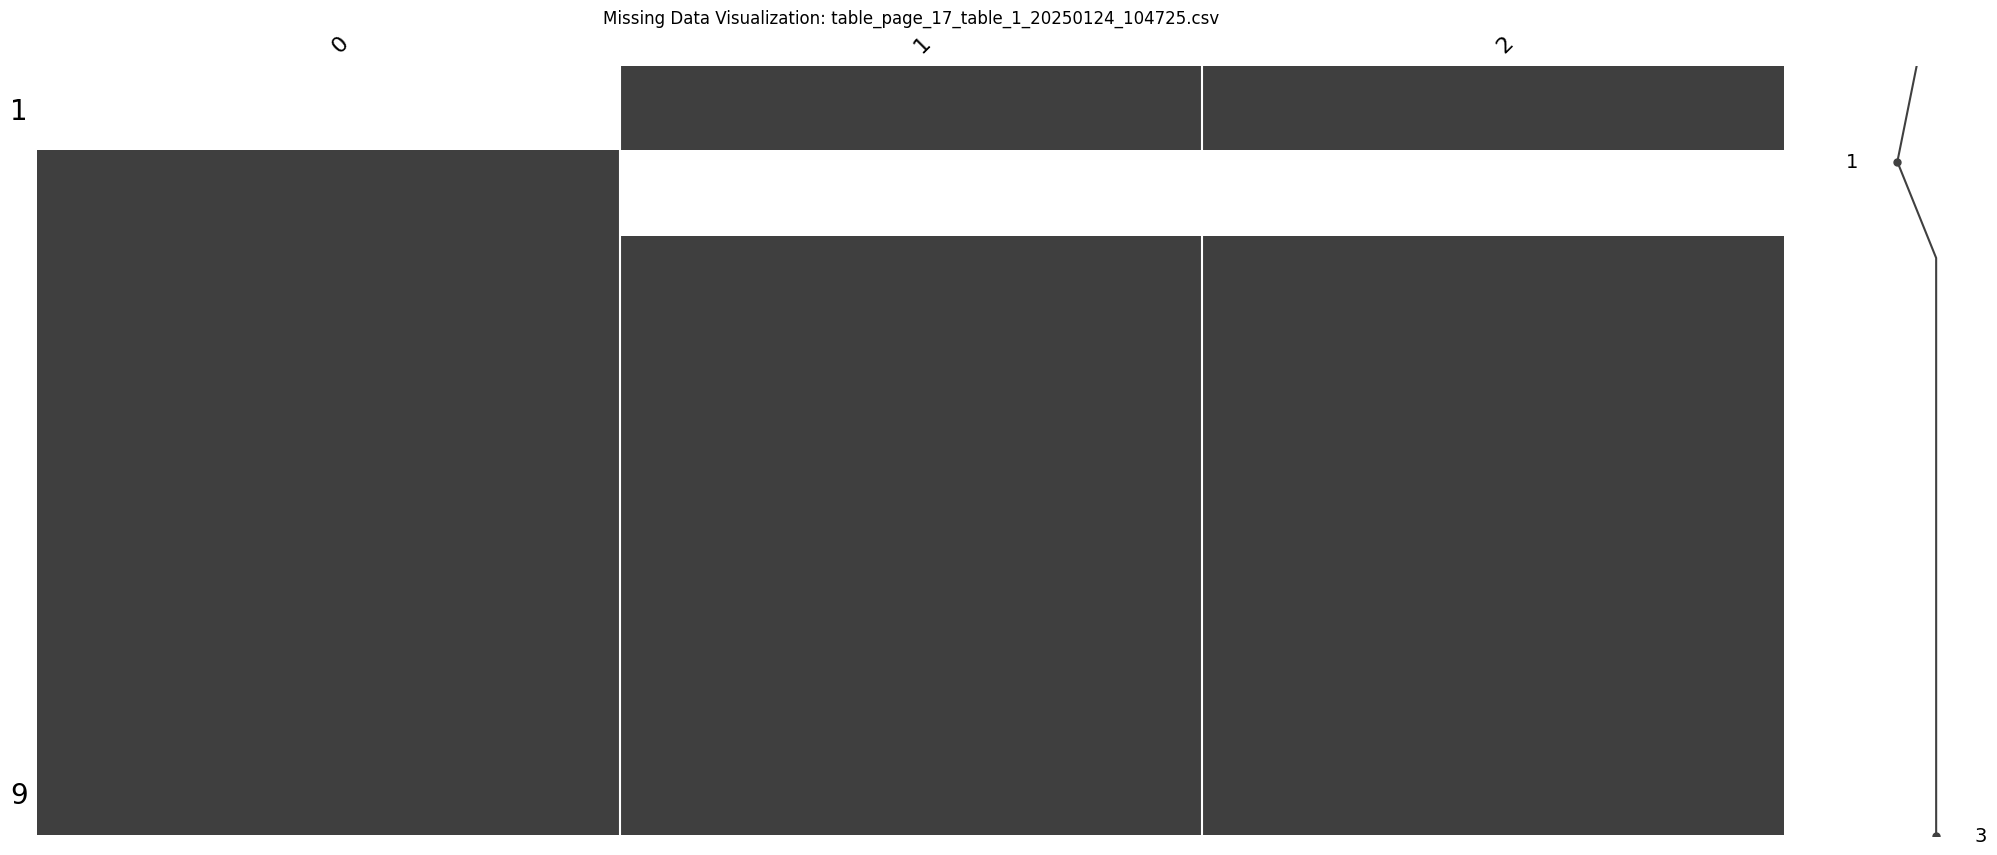

Missing Values for table_page_18_table_1_20250124_104725.csv:
0     2
1    15
2     5
dtype: int64


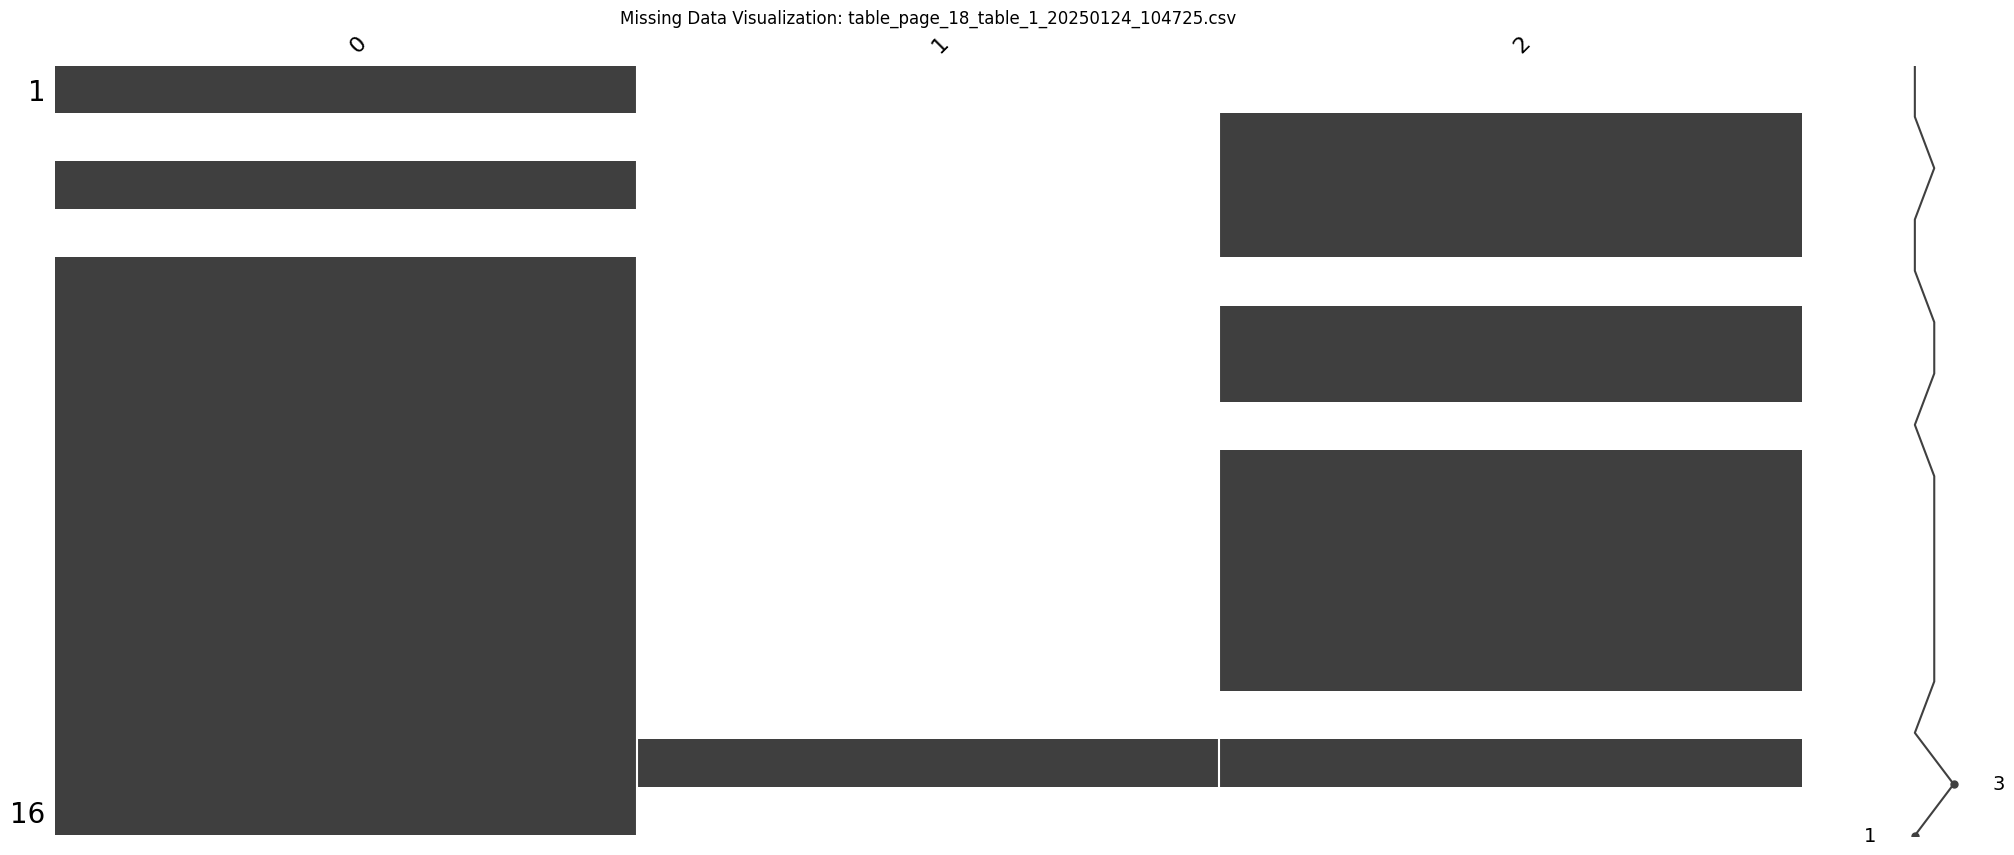

Missing Values for table_page_18_table_2_20250124_104725.csv:
0    0
1    4
2    4
dtype: int64


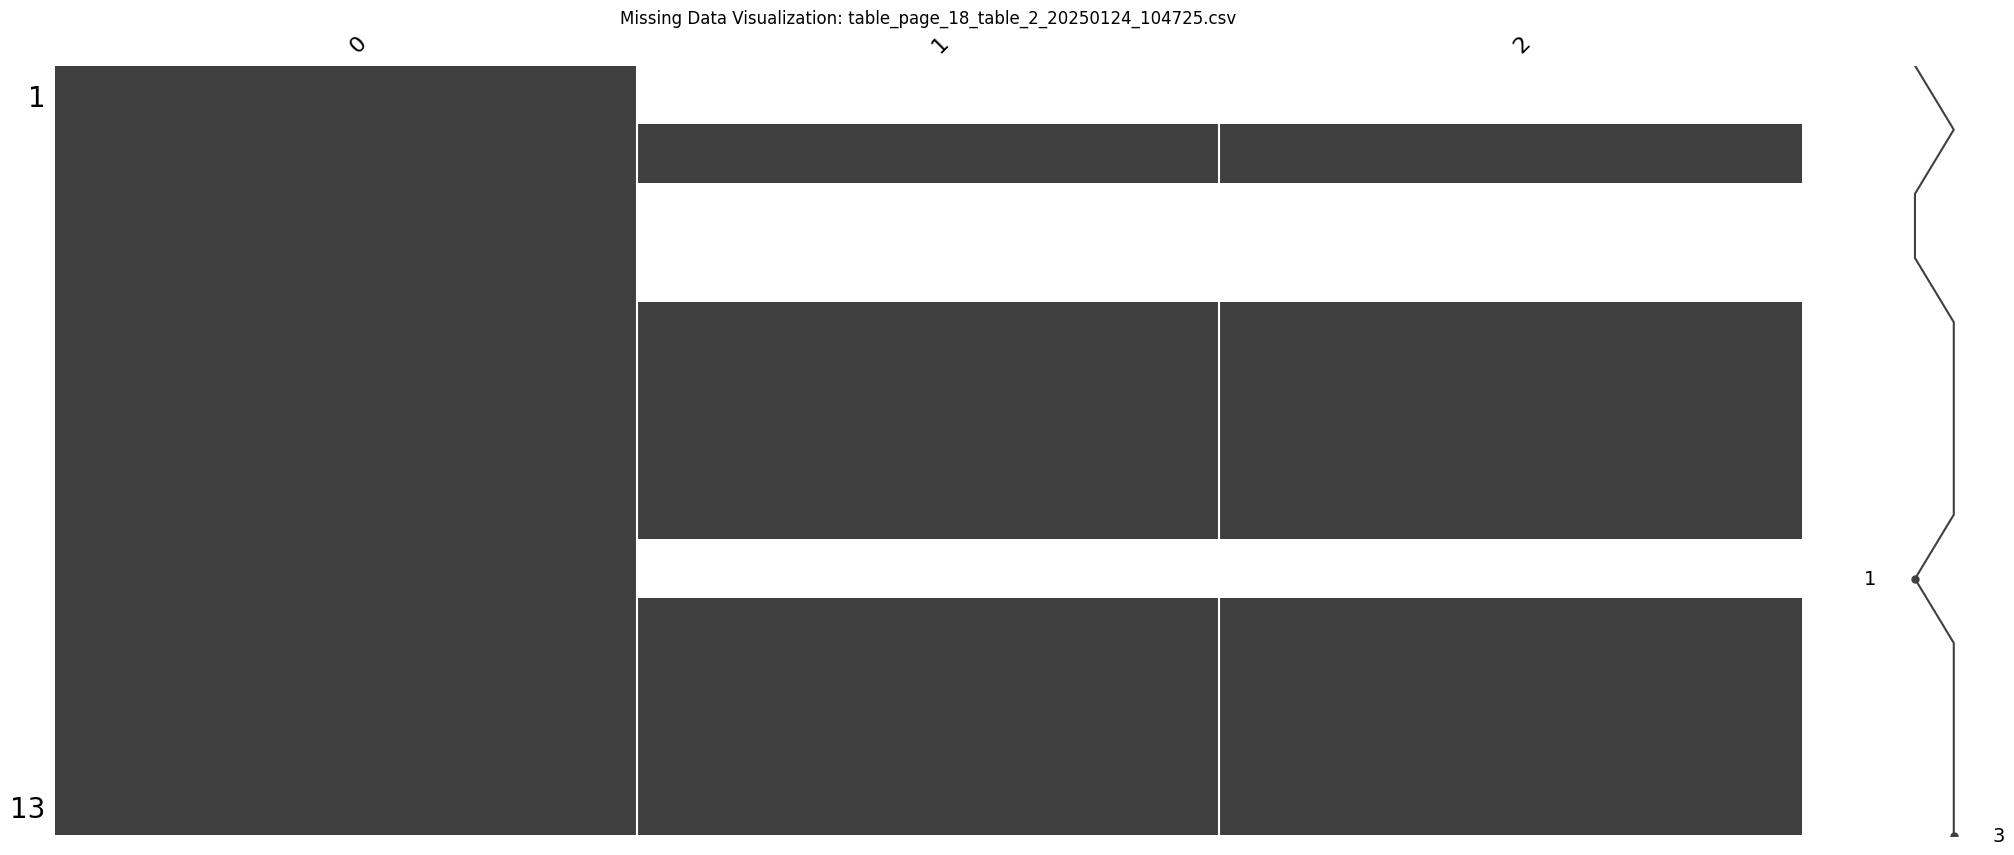

Missing Values for table_page_1_table_1_20250124_104725.csv:
0    0
1    7
dtype: int64


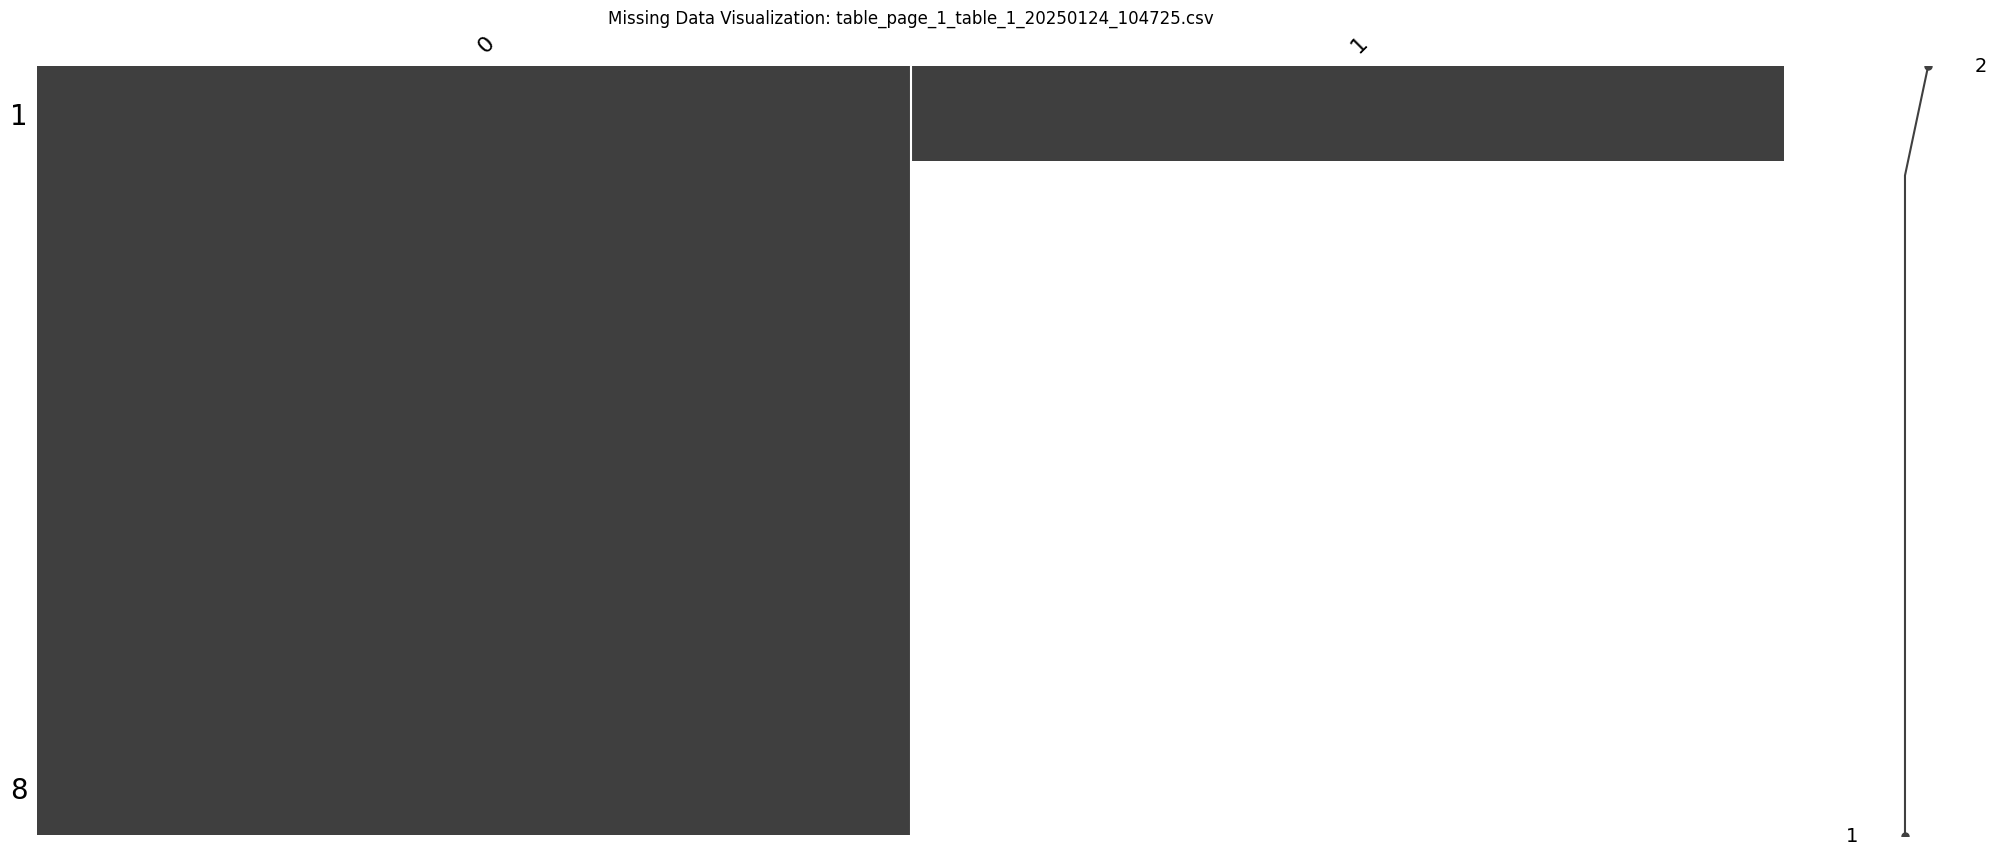

Missing Values for table_page_1_table_2_20250124_104725.csv:
0     1
1    32
dtype: int64


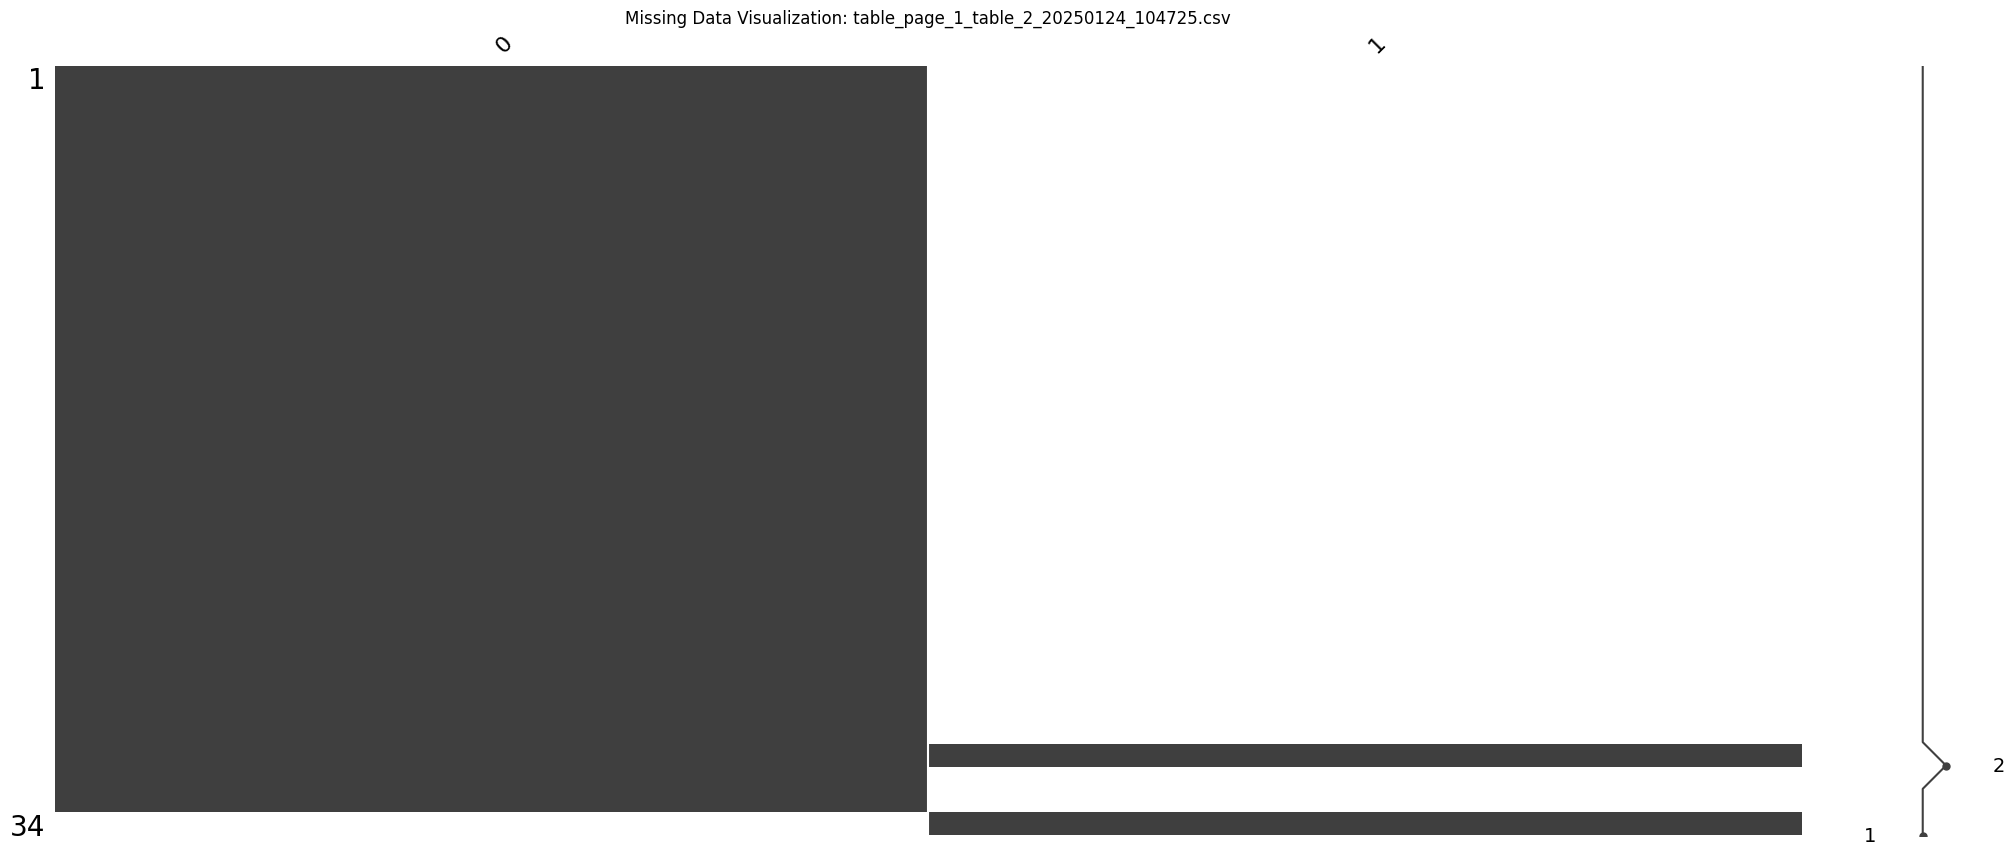

Missing Values for table_page_20_table_1_20250124_104725.csv:
0    0
dtype: int64


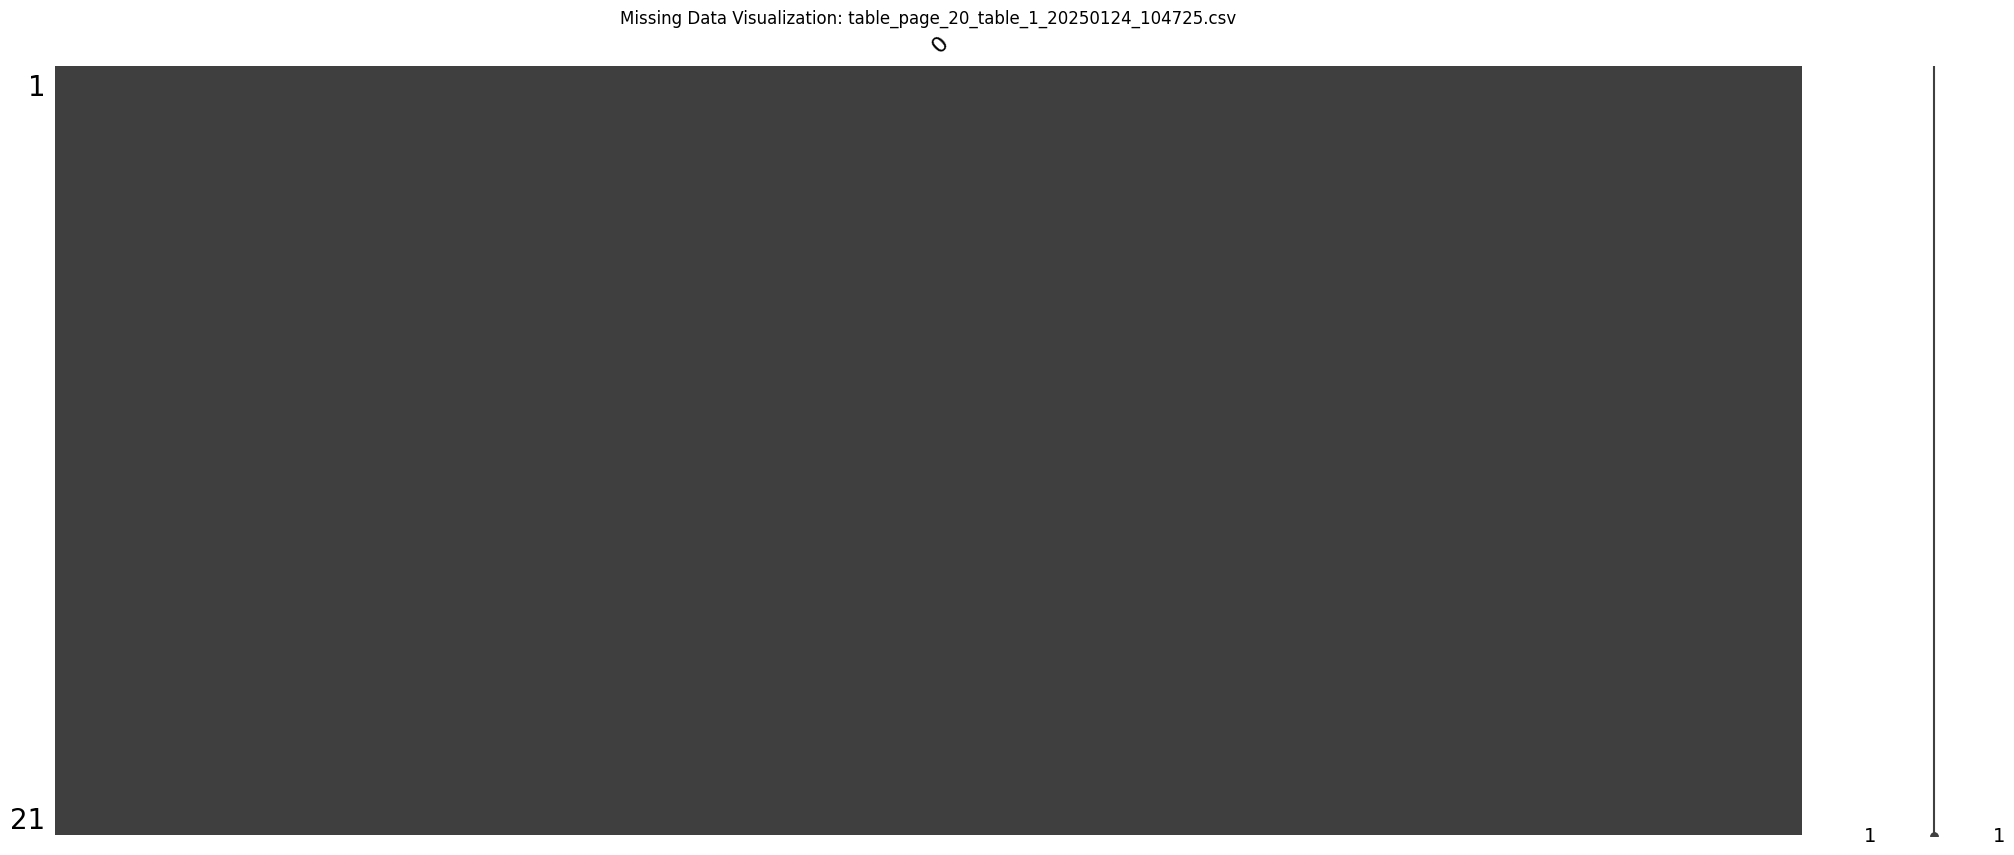

Missing Values for table_page_20_table_2_20250124_104725.csv:
0    2
1    6
2    4
3    6
4    4
5    6
6    6
7    6
dtype: int64


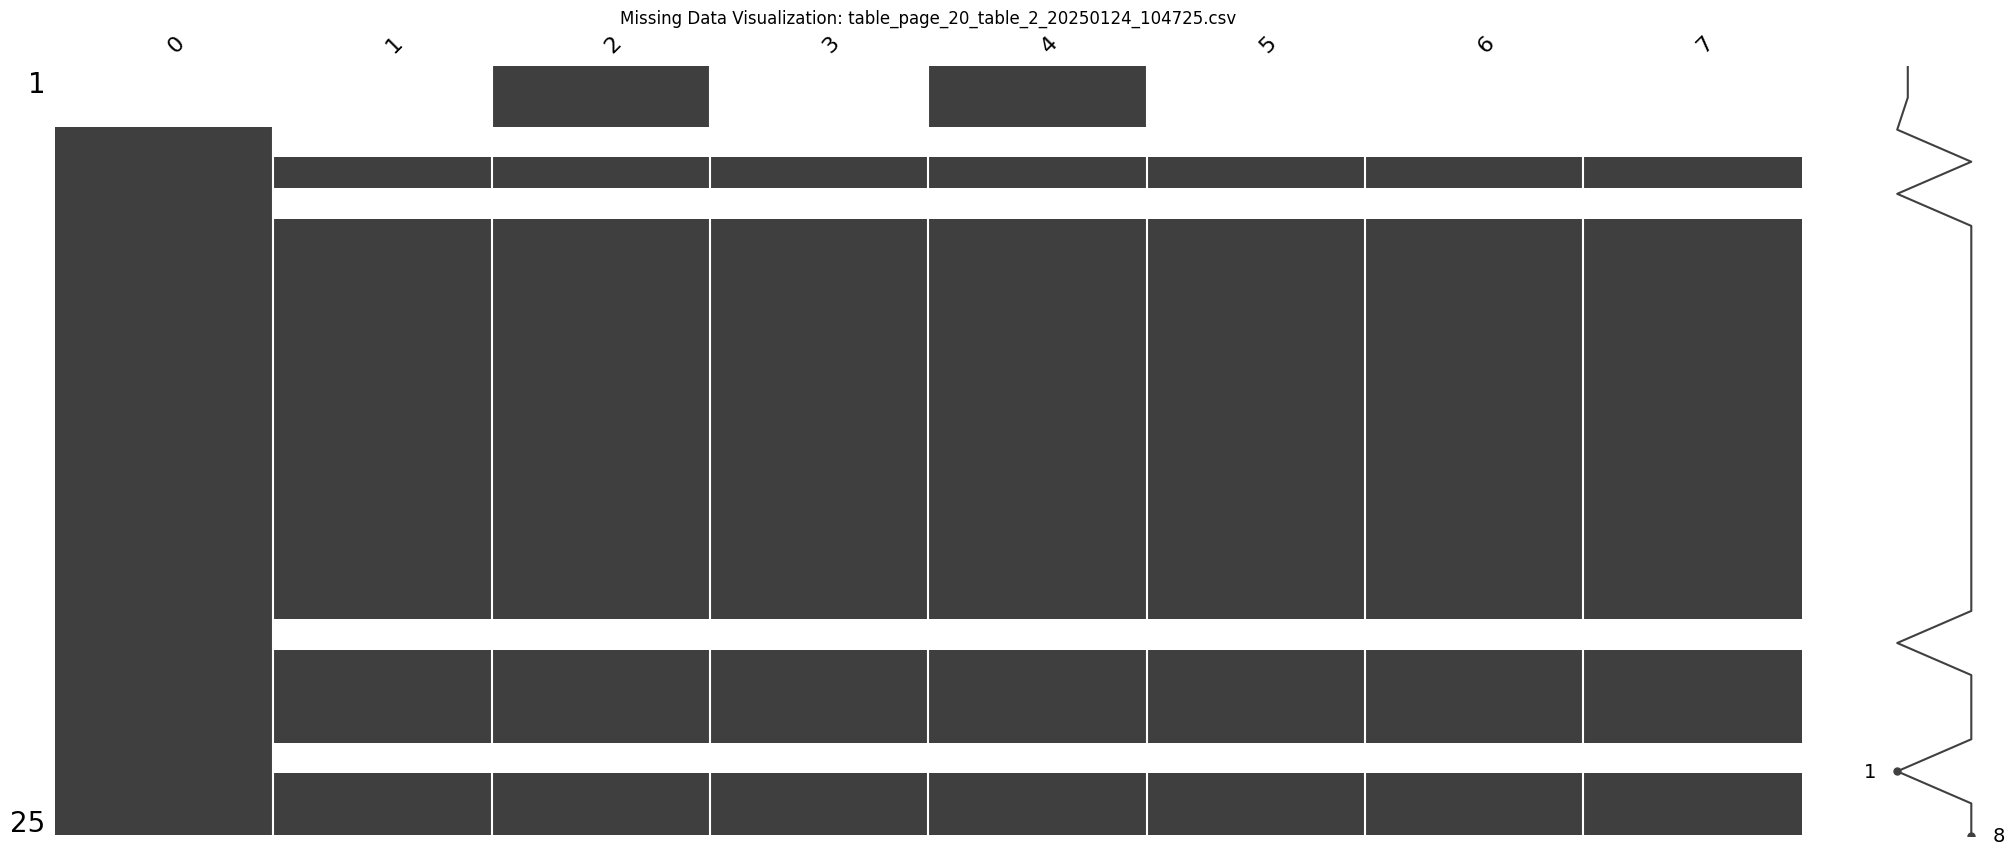

Missing Values for table_page_21_table_1_20250124_104725.csv:
0    4
1    9
2    7
3    9
4    7
5    9
6    9
7    9
dtype: int64


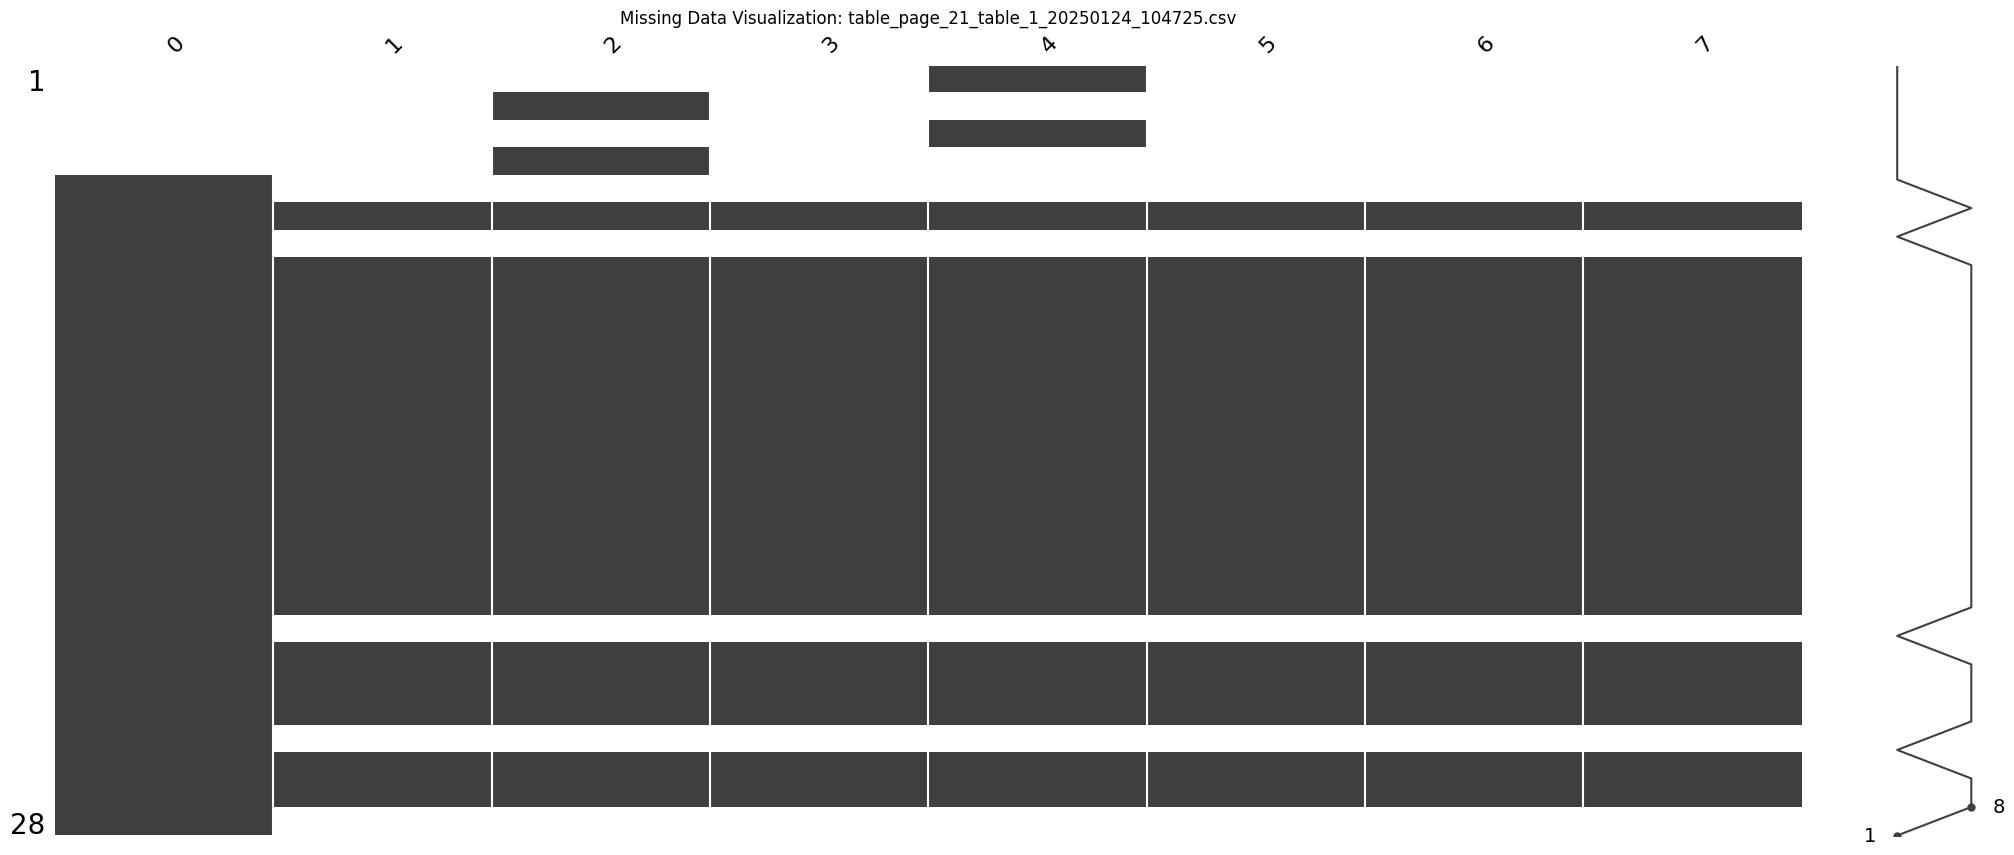

Missing Values for table_page_22_table_1_20250124_104725.csv:
0    11
1    11
2    21
3    19
4    18
dtype: int64


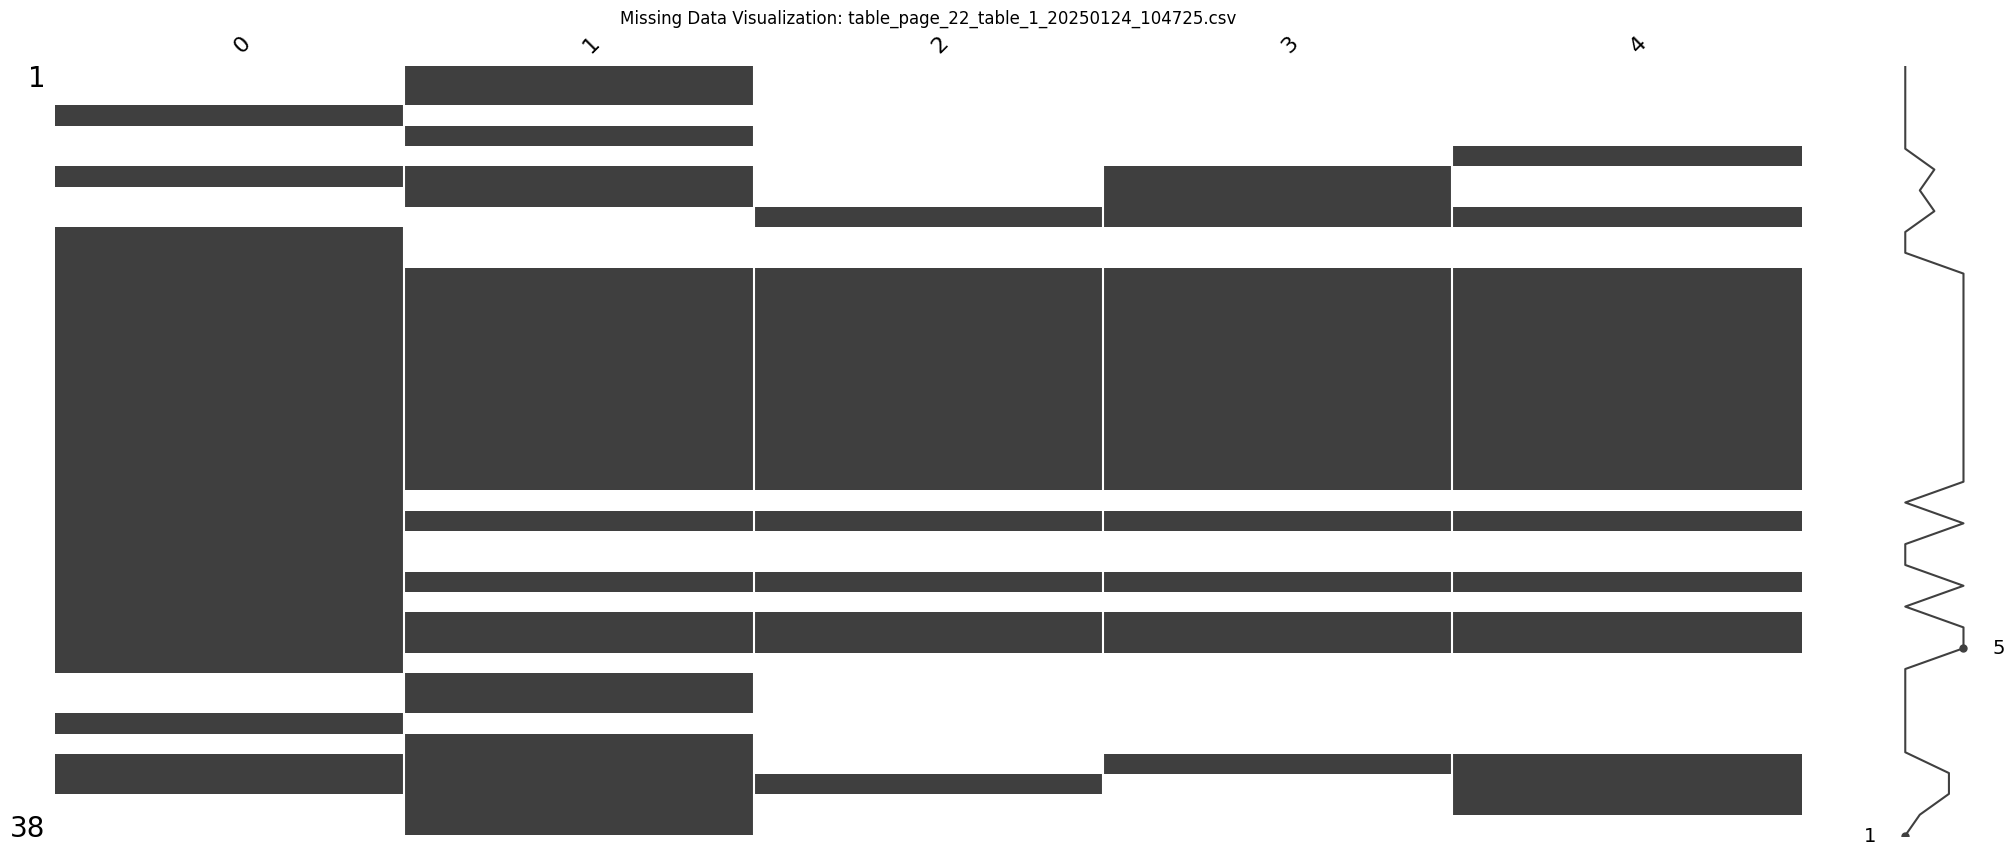

Missing Values for table_page_24_table_1_20250124_104725.csv:
0    0
dtype: int64


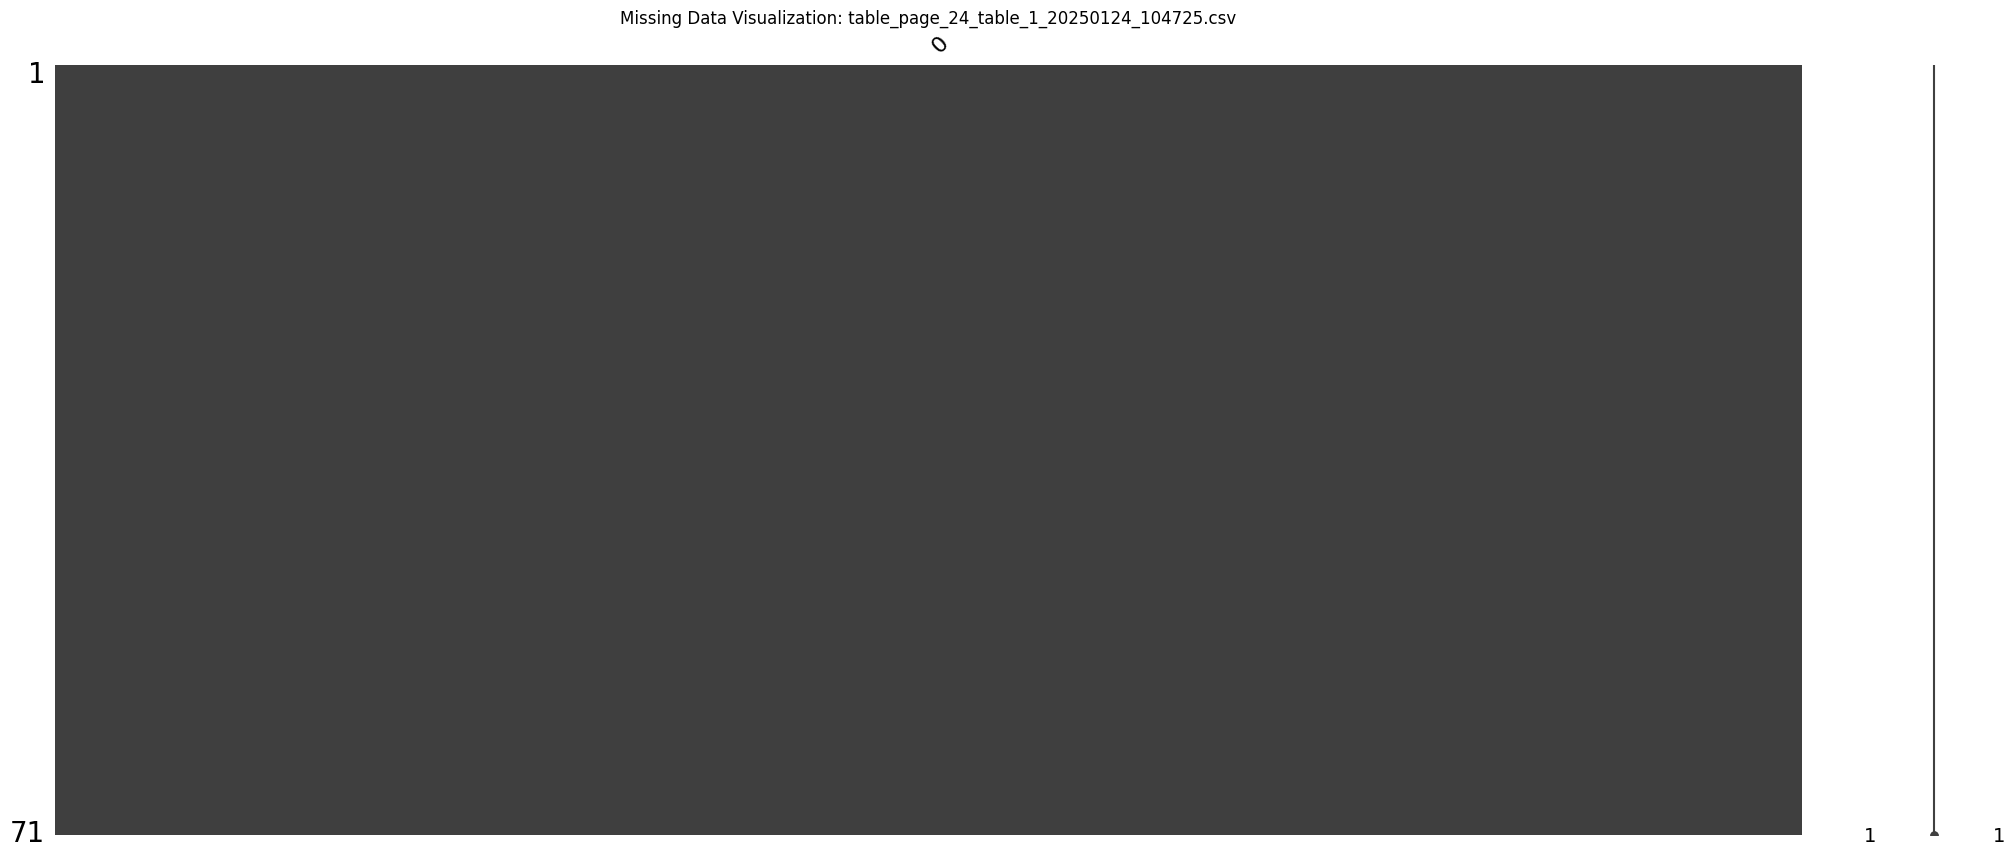

Missing Values for table_page_25_table_1_20250124_104725.csv:
0    6
1    2
dtype: int64


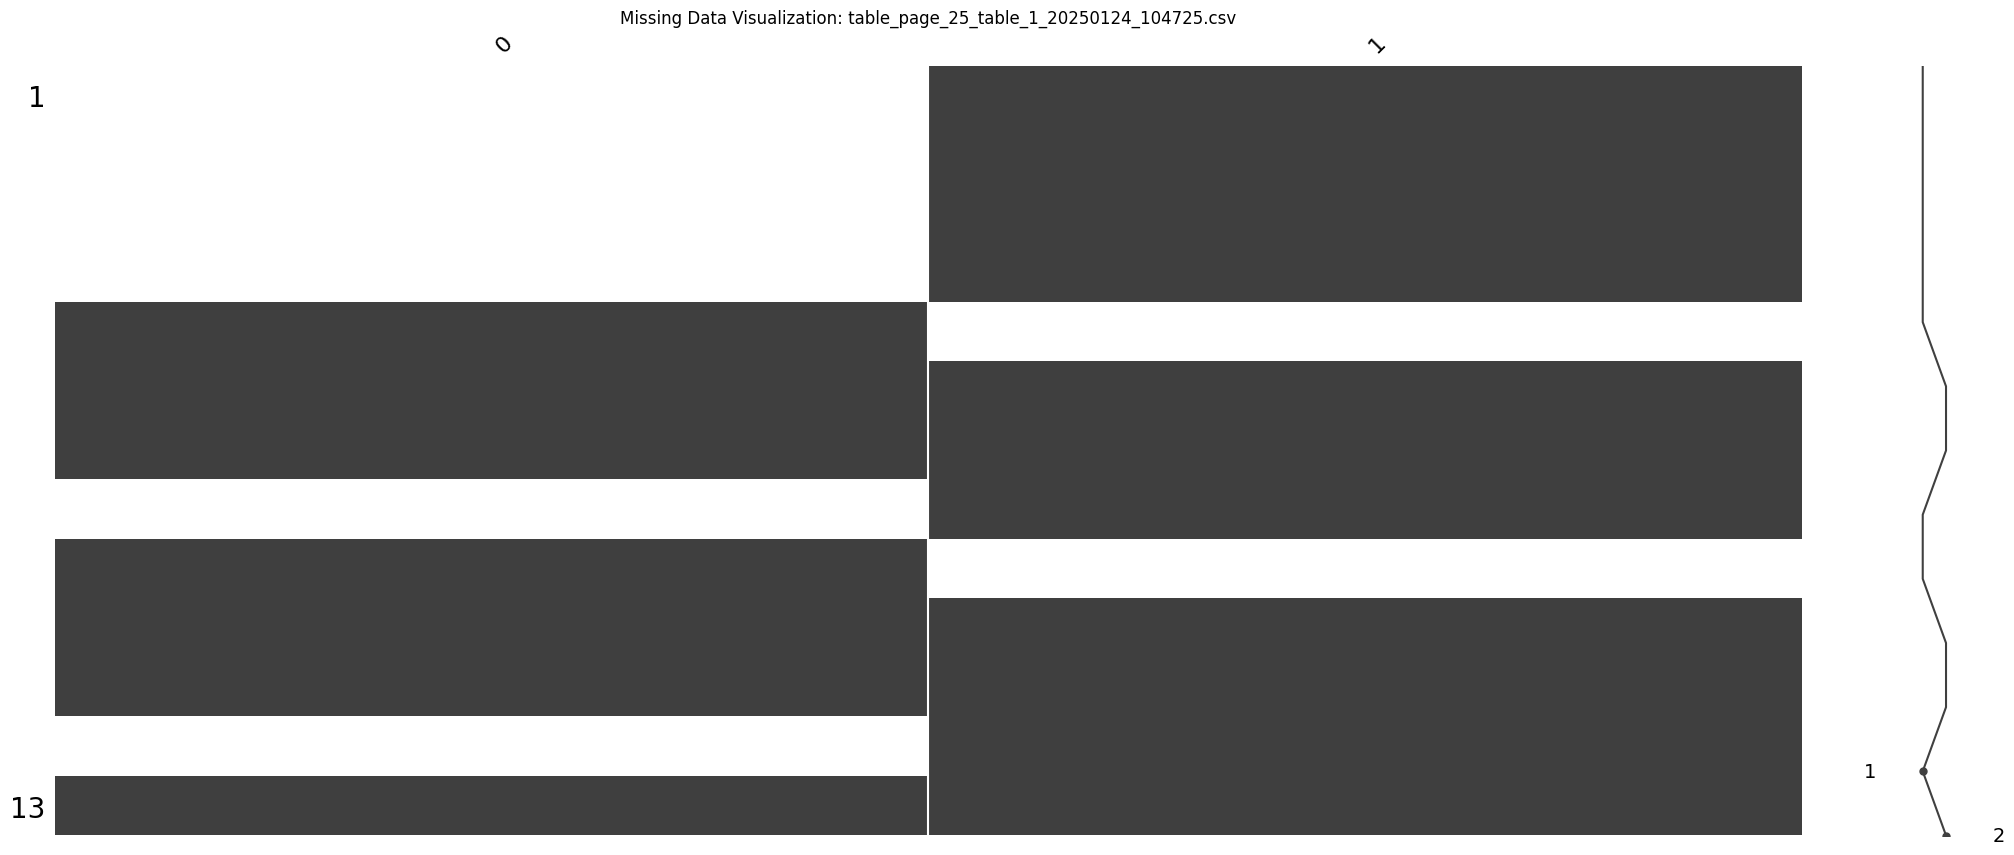

Missing Values for table_page_26_table_1_20250124_104725.csv:
0    1
1    4
2    4
dtype: int64


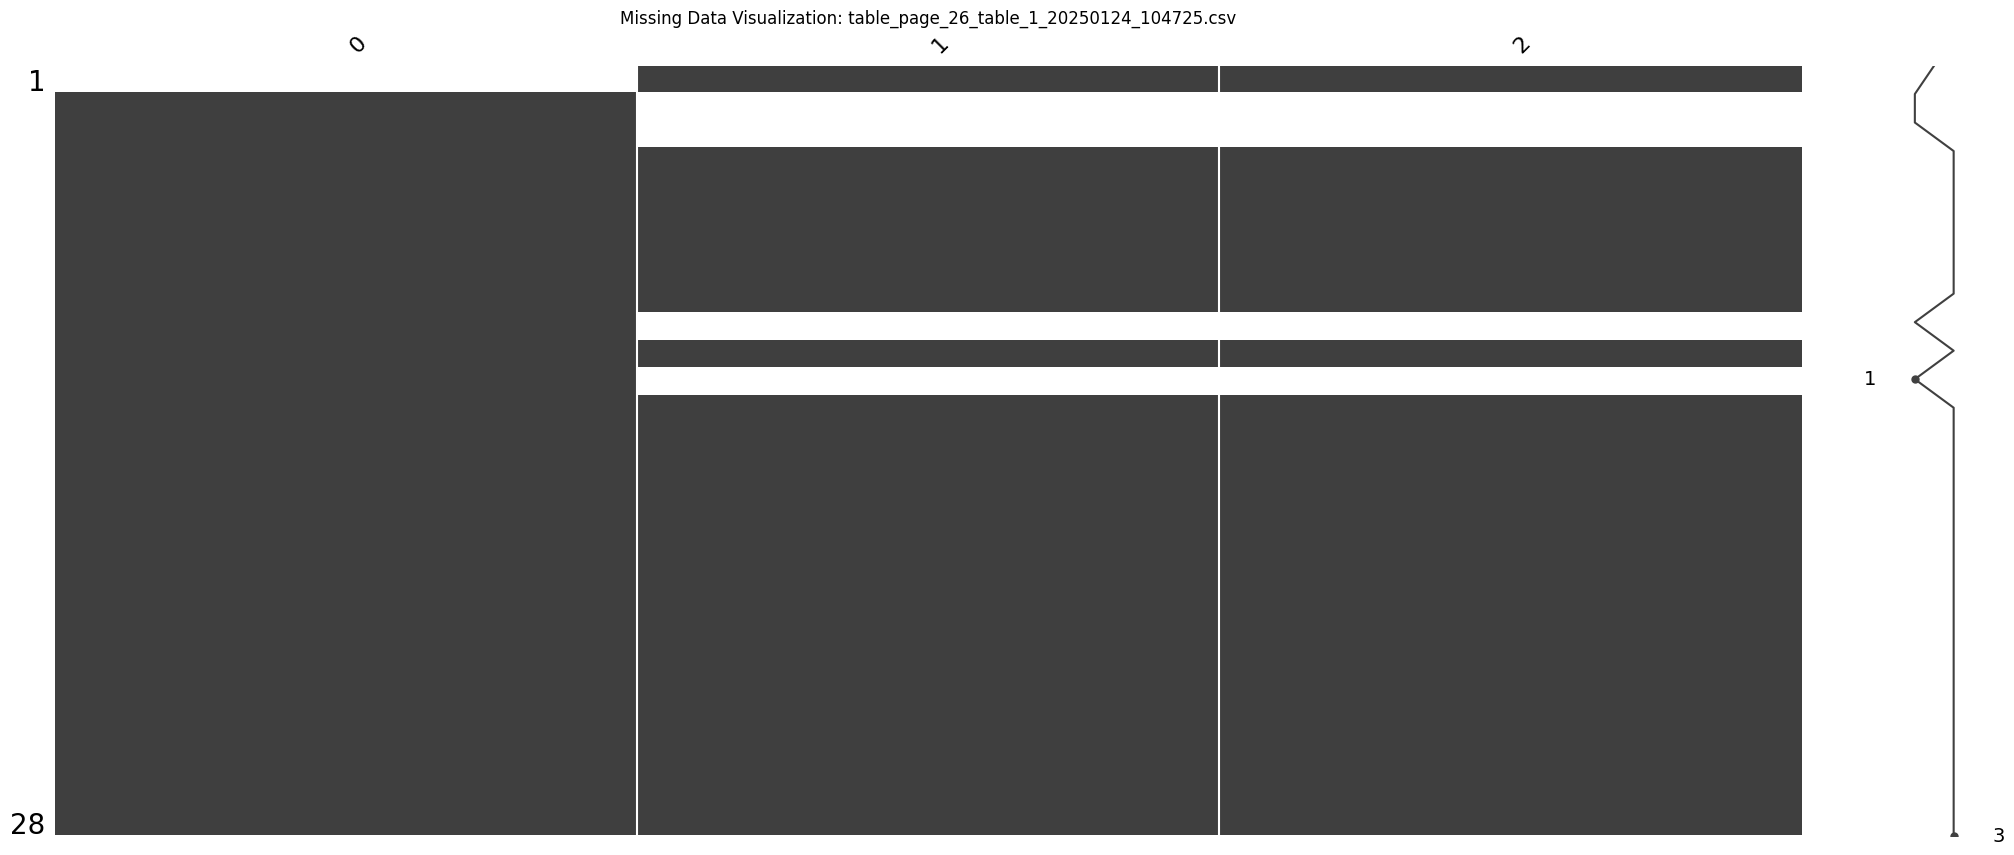

Missing Values for table_page_27_table_1_20250124_104725.csv:
0    0
dtype: int64


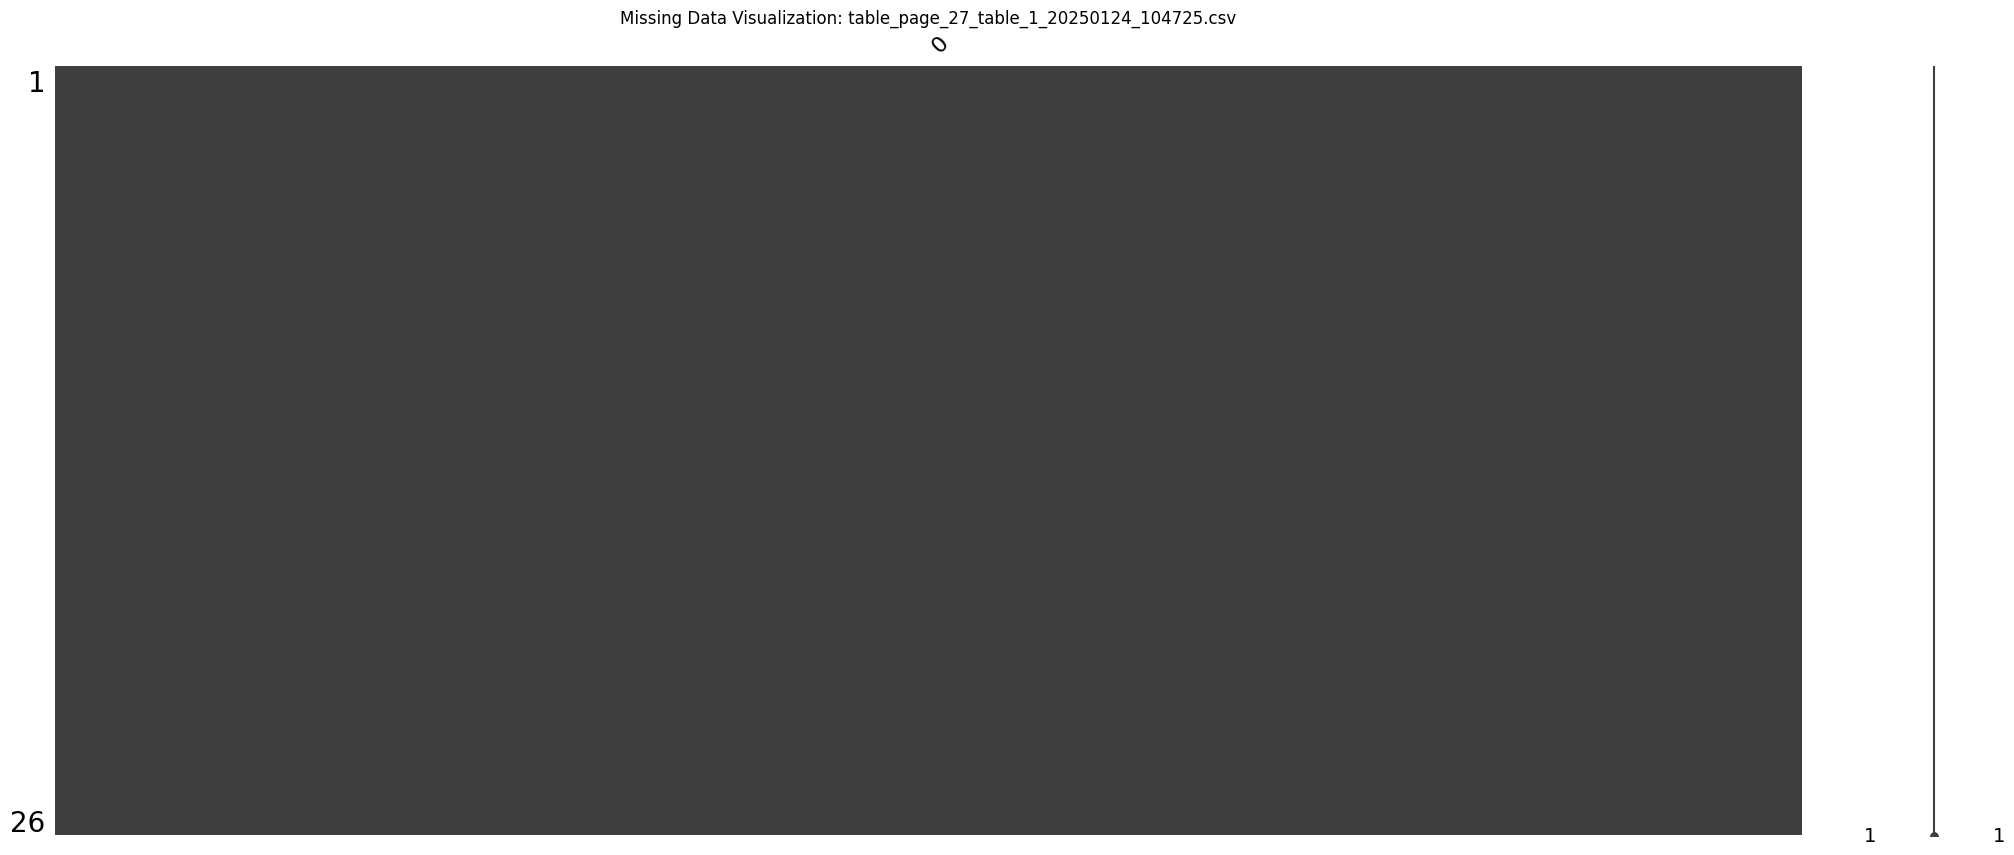

Missing Values for table_page_2_table_1_20250124_104725.csv:
0     1
1    10
2     5
3     4
dtype: int64


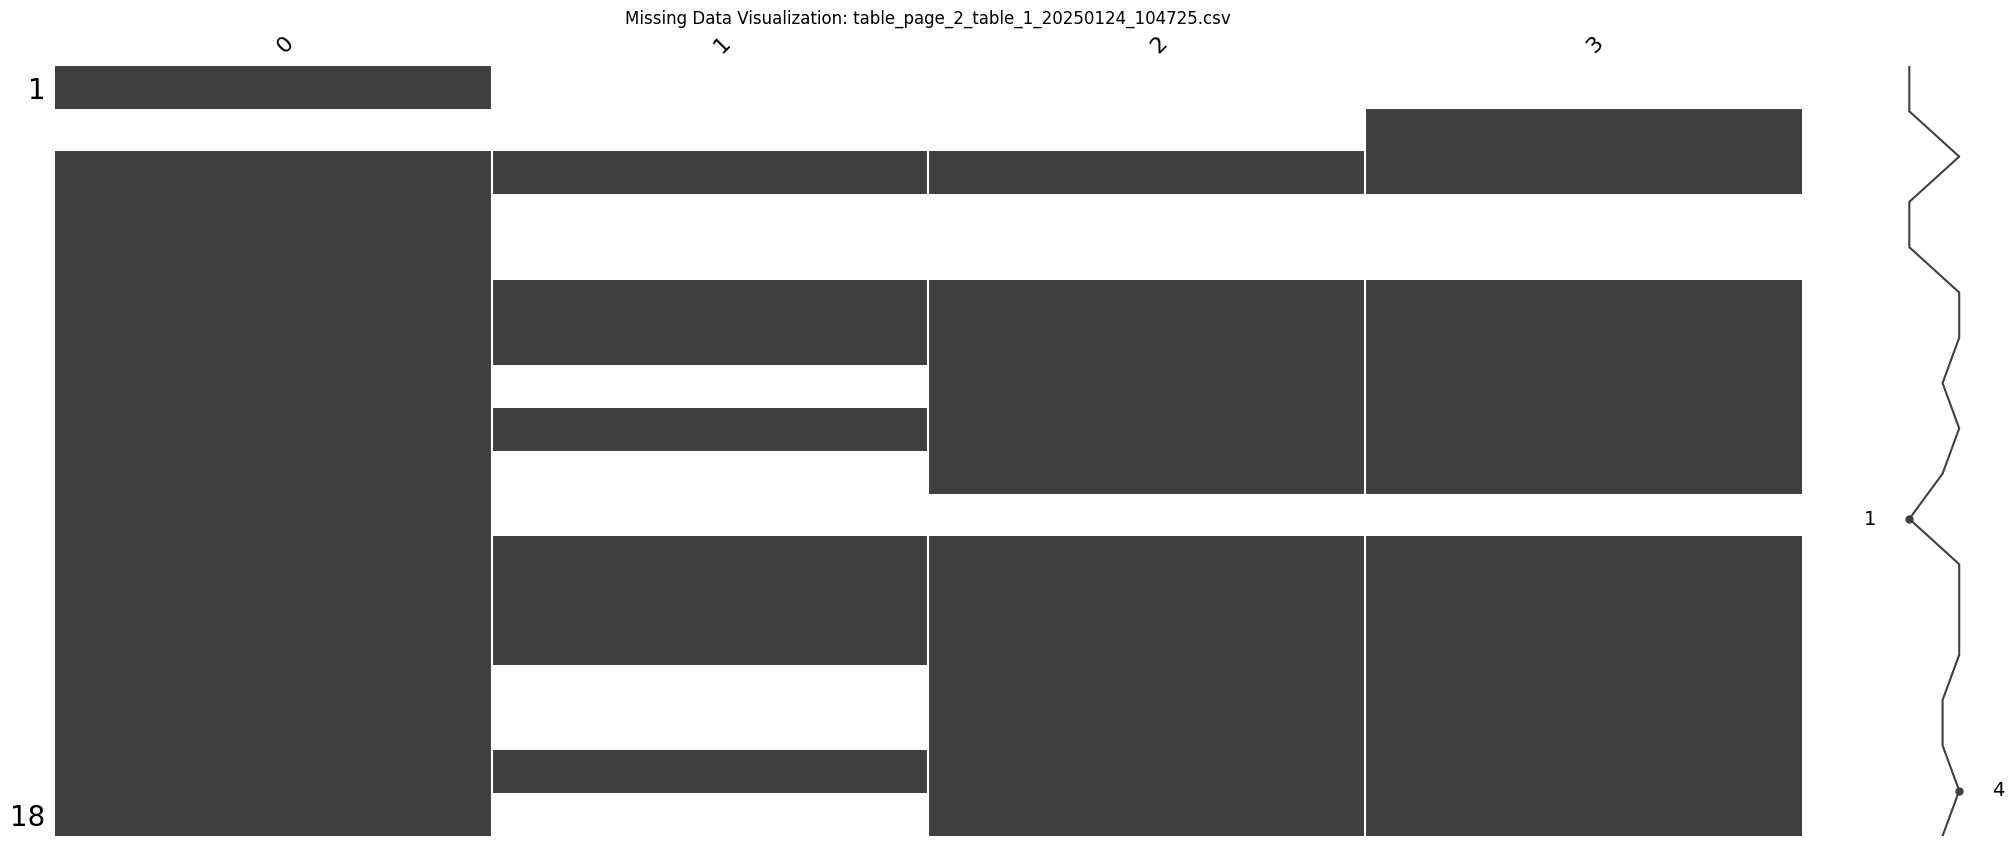

Missing Values for table_page_30_table_1_20250124_104725.csv:
0    0
dtype: int64


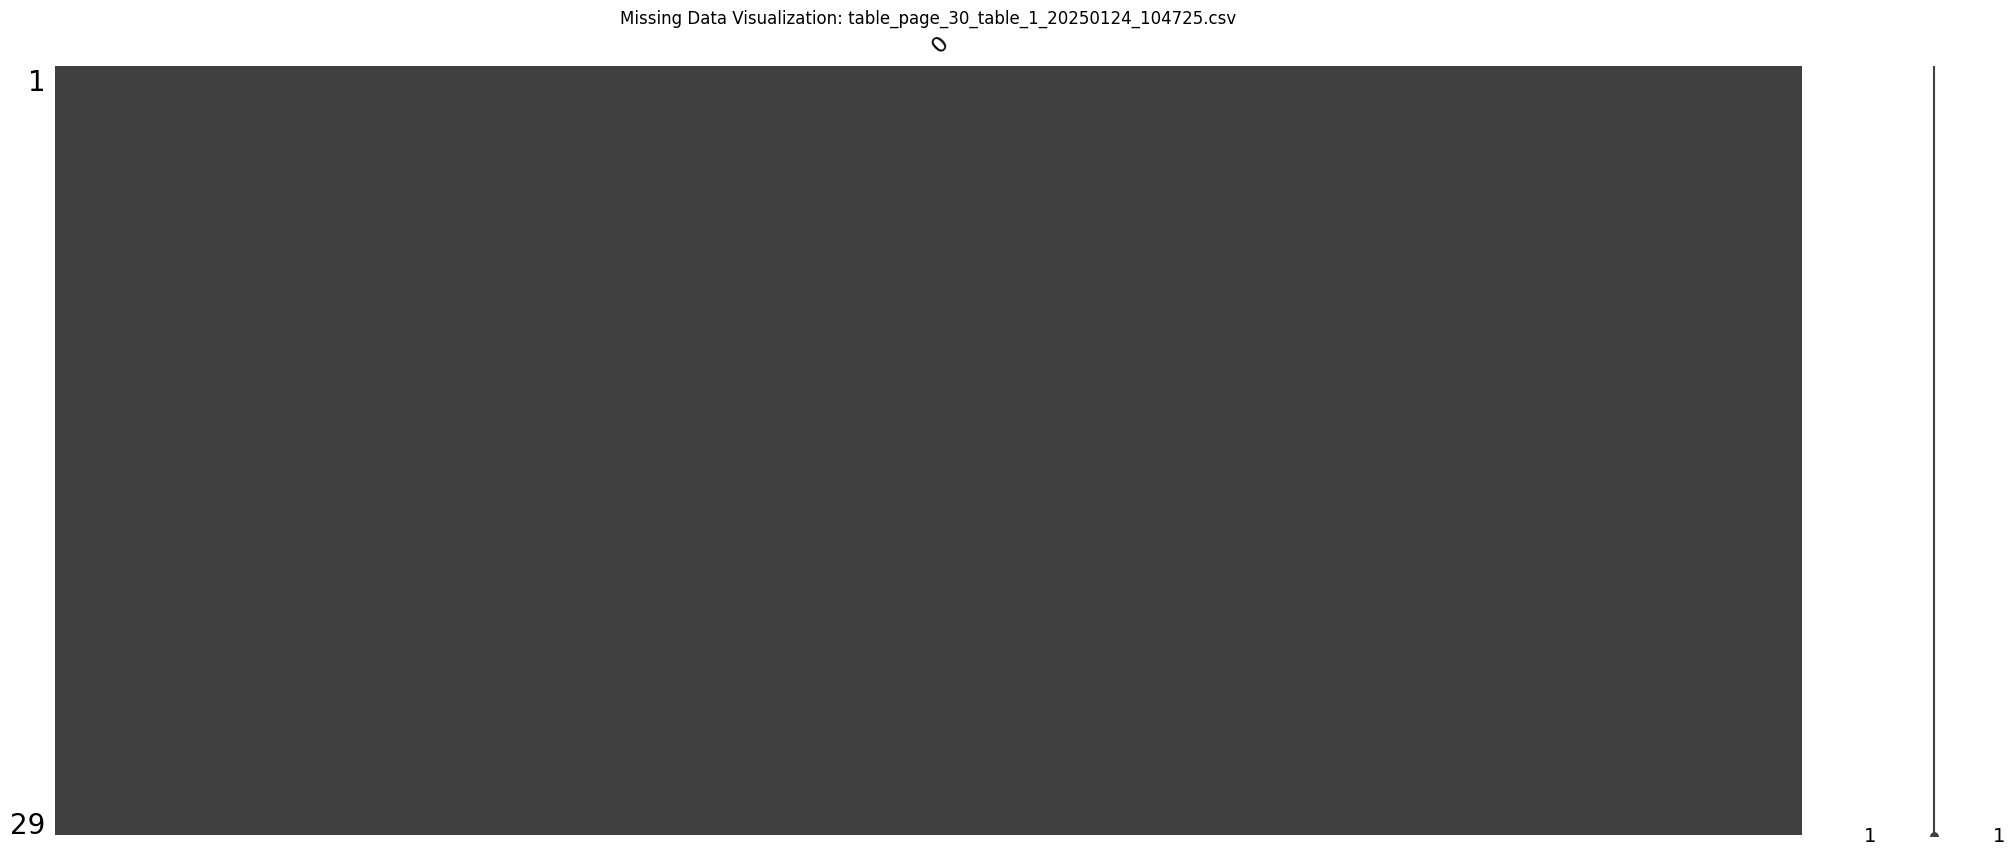

Missing Values for table_page_32_table_1_20250124_104725.csv:
0    0
dtype: int64


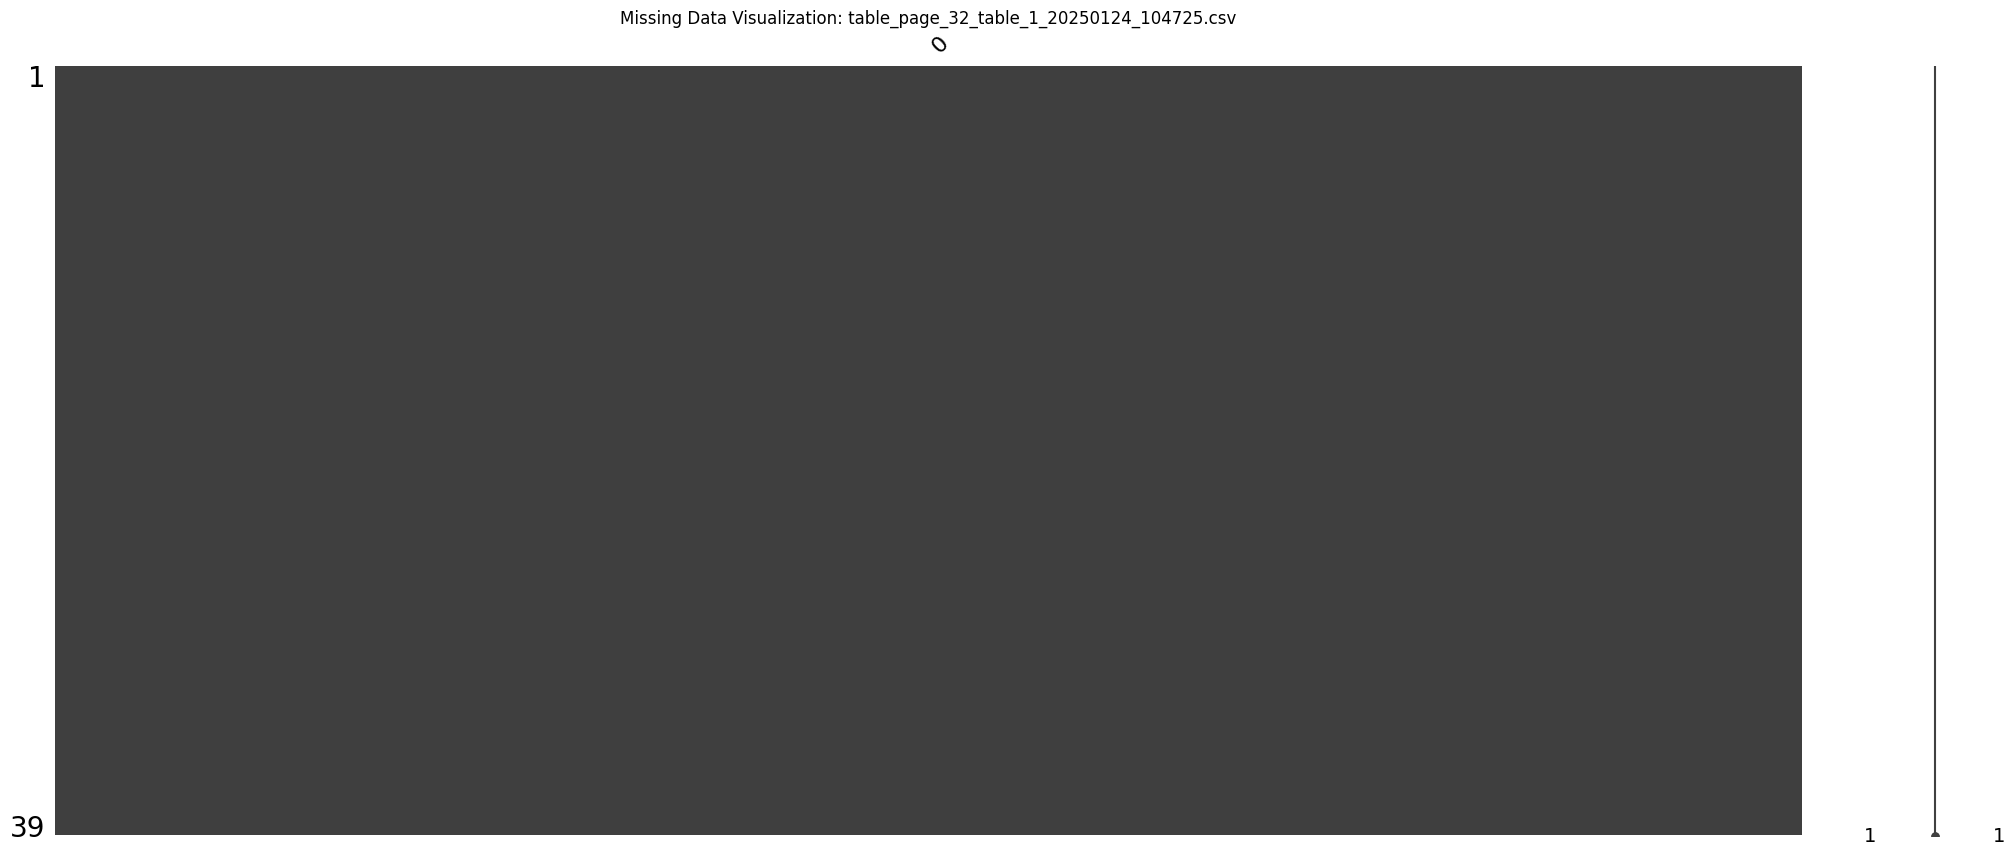

Missing Values for table_page_33_table_1_20250124_104725.csv:
0    5
1    4
2    5
3    4
4    4
dtype: int64


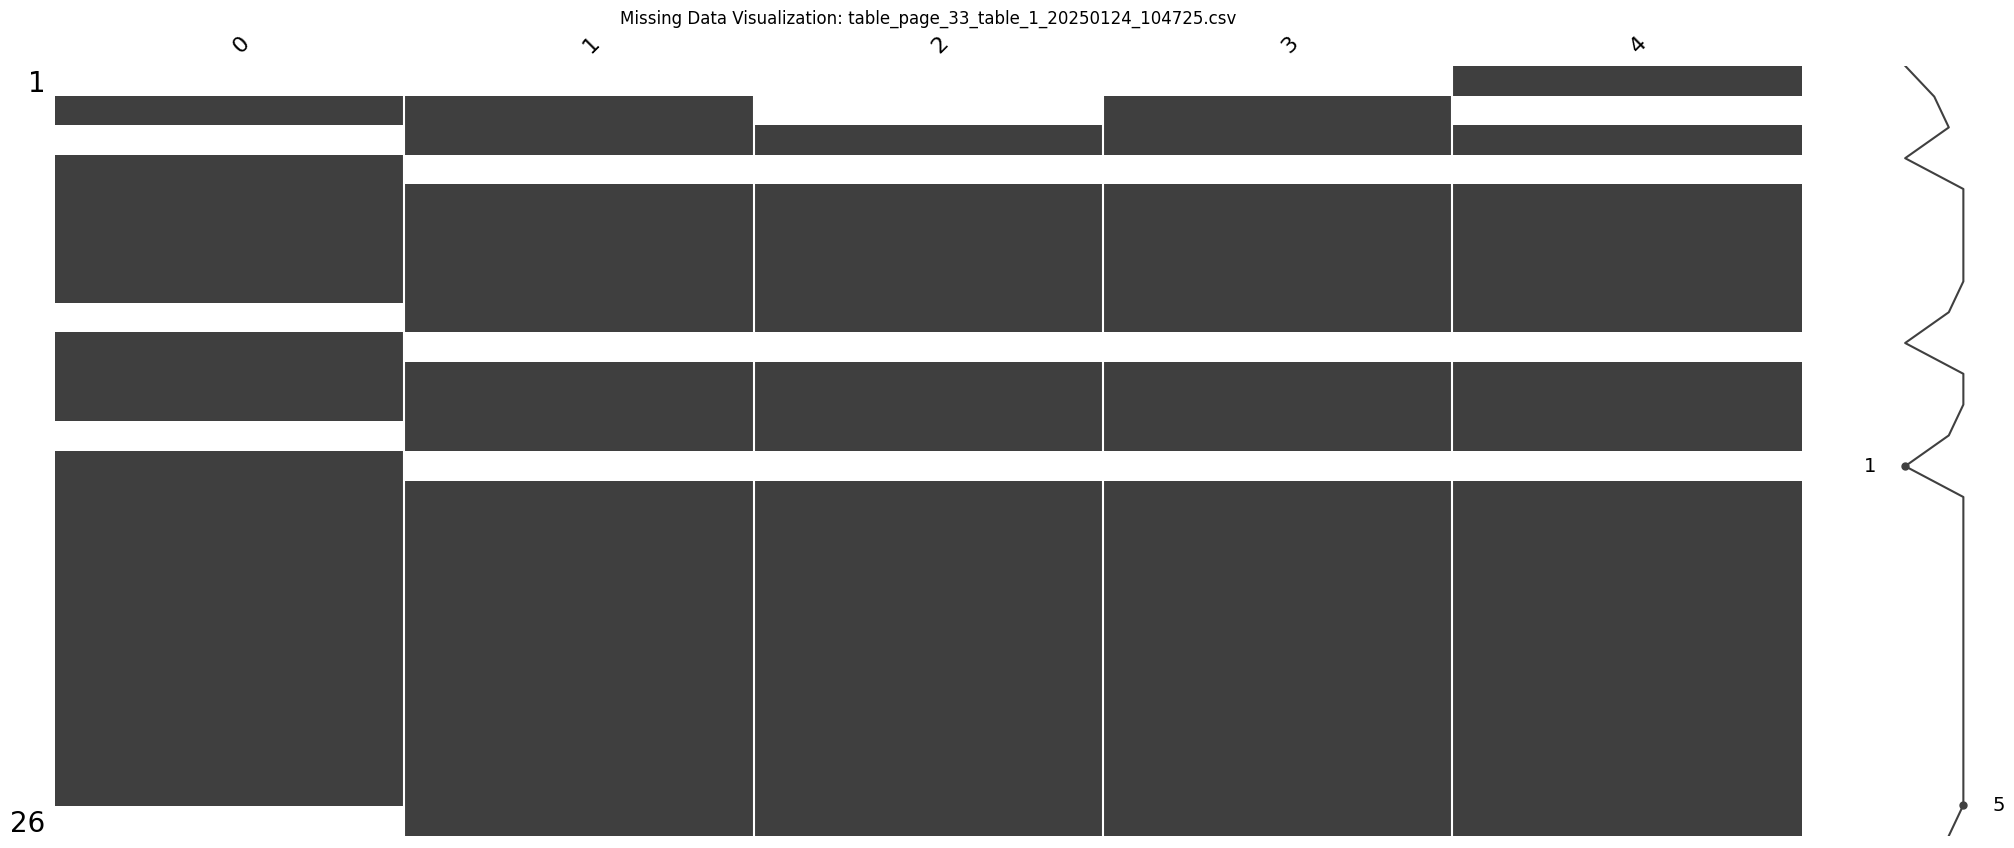

Missing Values for table_page_33_table_2_20250124_104725.csv:
0    0
dtype: int64


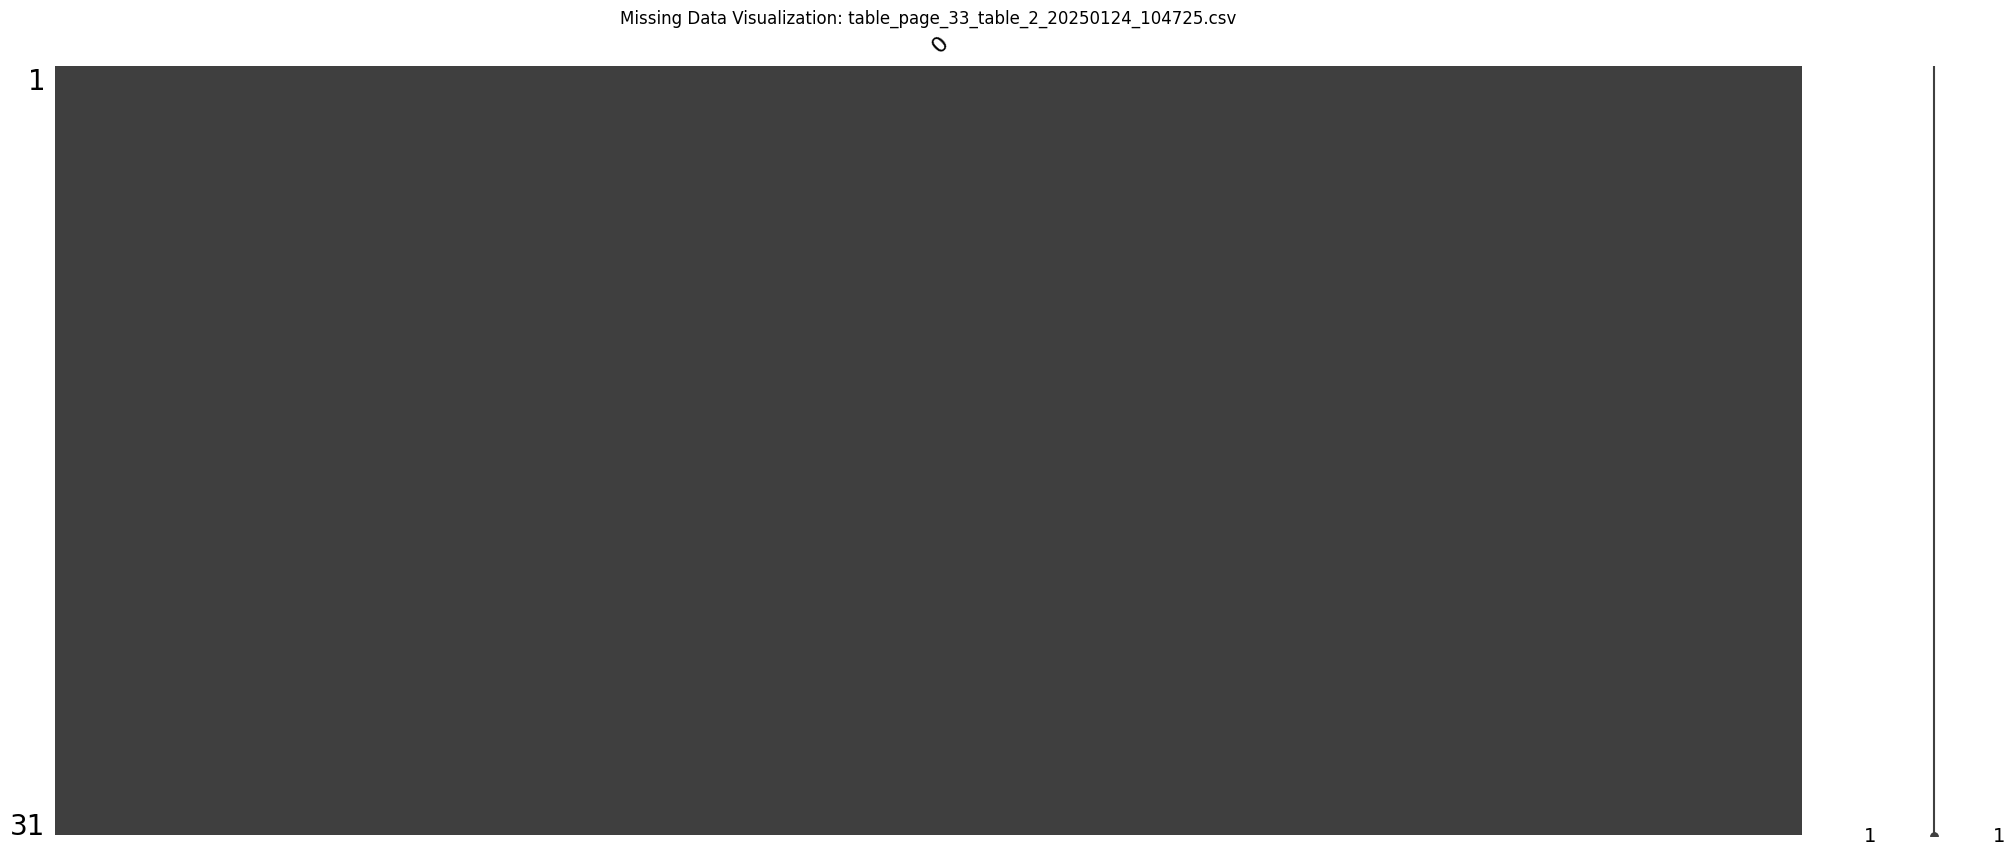

Missing Values for table_page_34_table_1_20250124_104725.csv:
0    12
1    39
2    30
3    34
4    33
5    26
dtype: int64


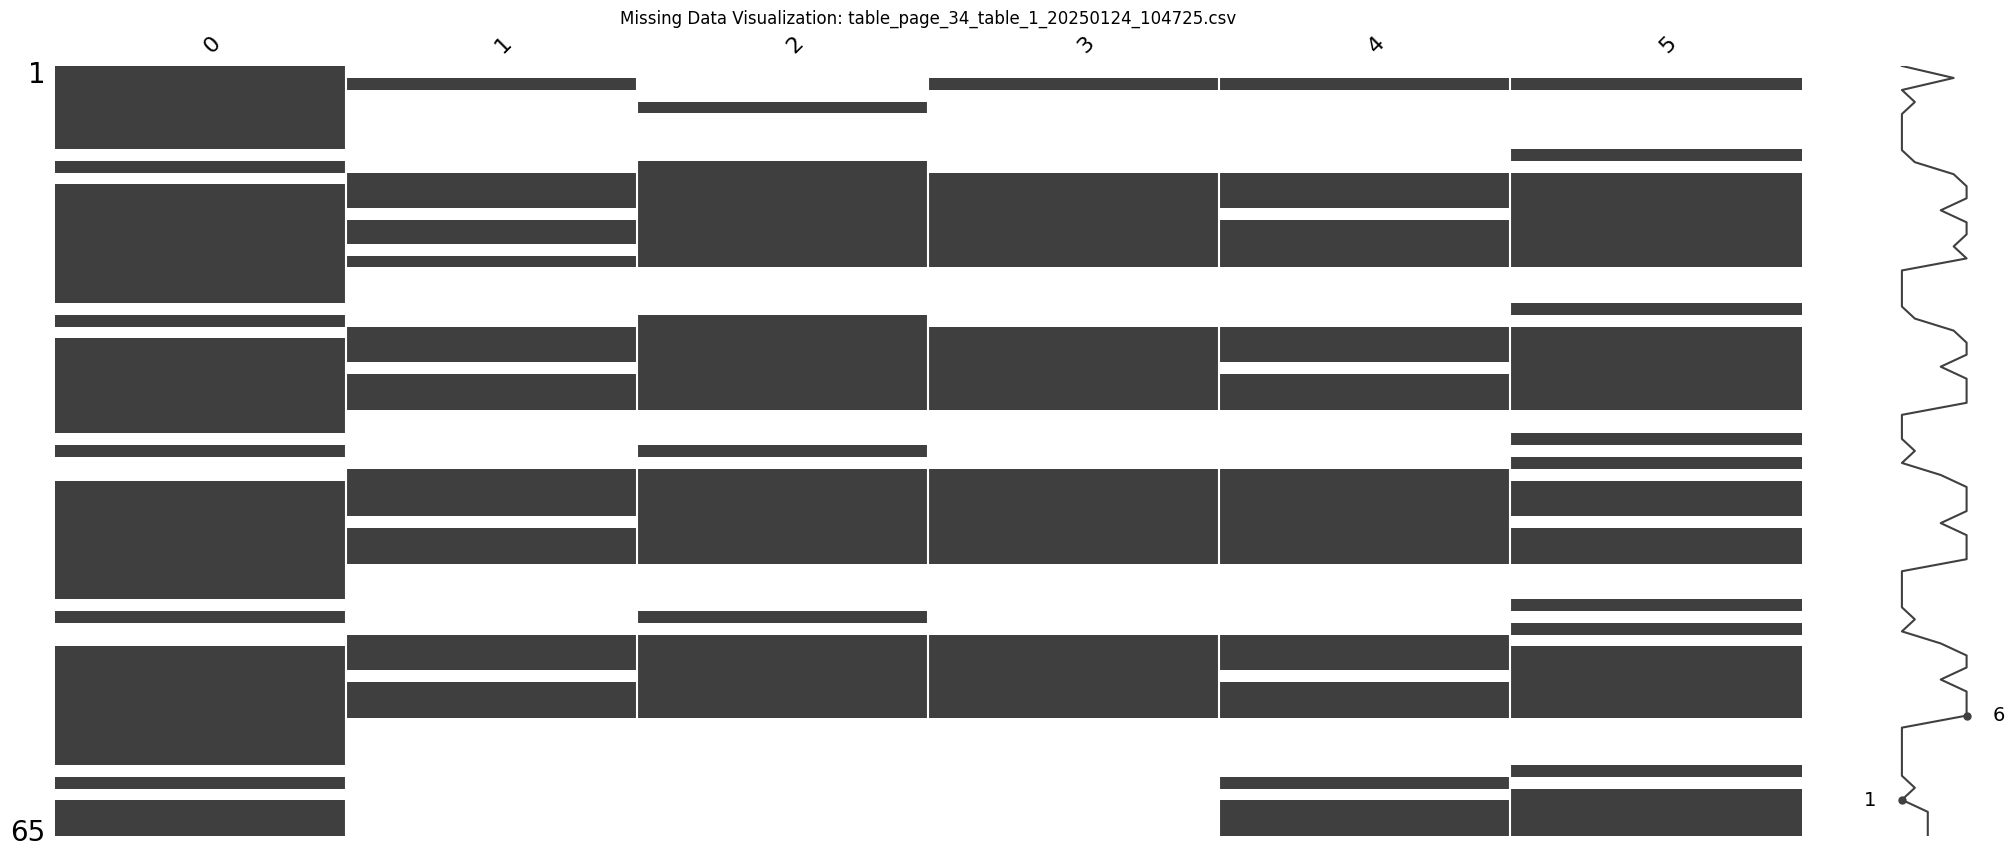

Missing Values for table_page_36_table_1_20250124_104725.csv:
0    0
dtype: int64


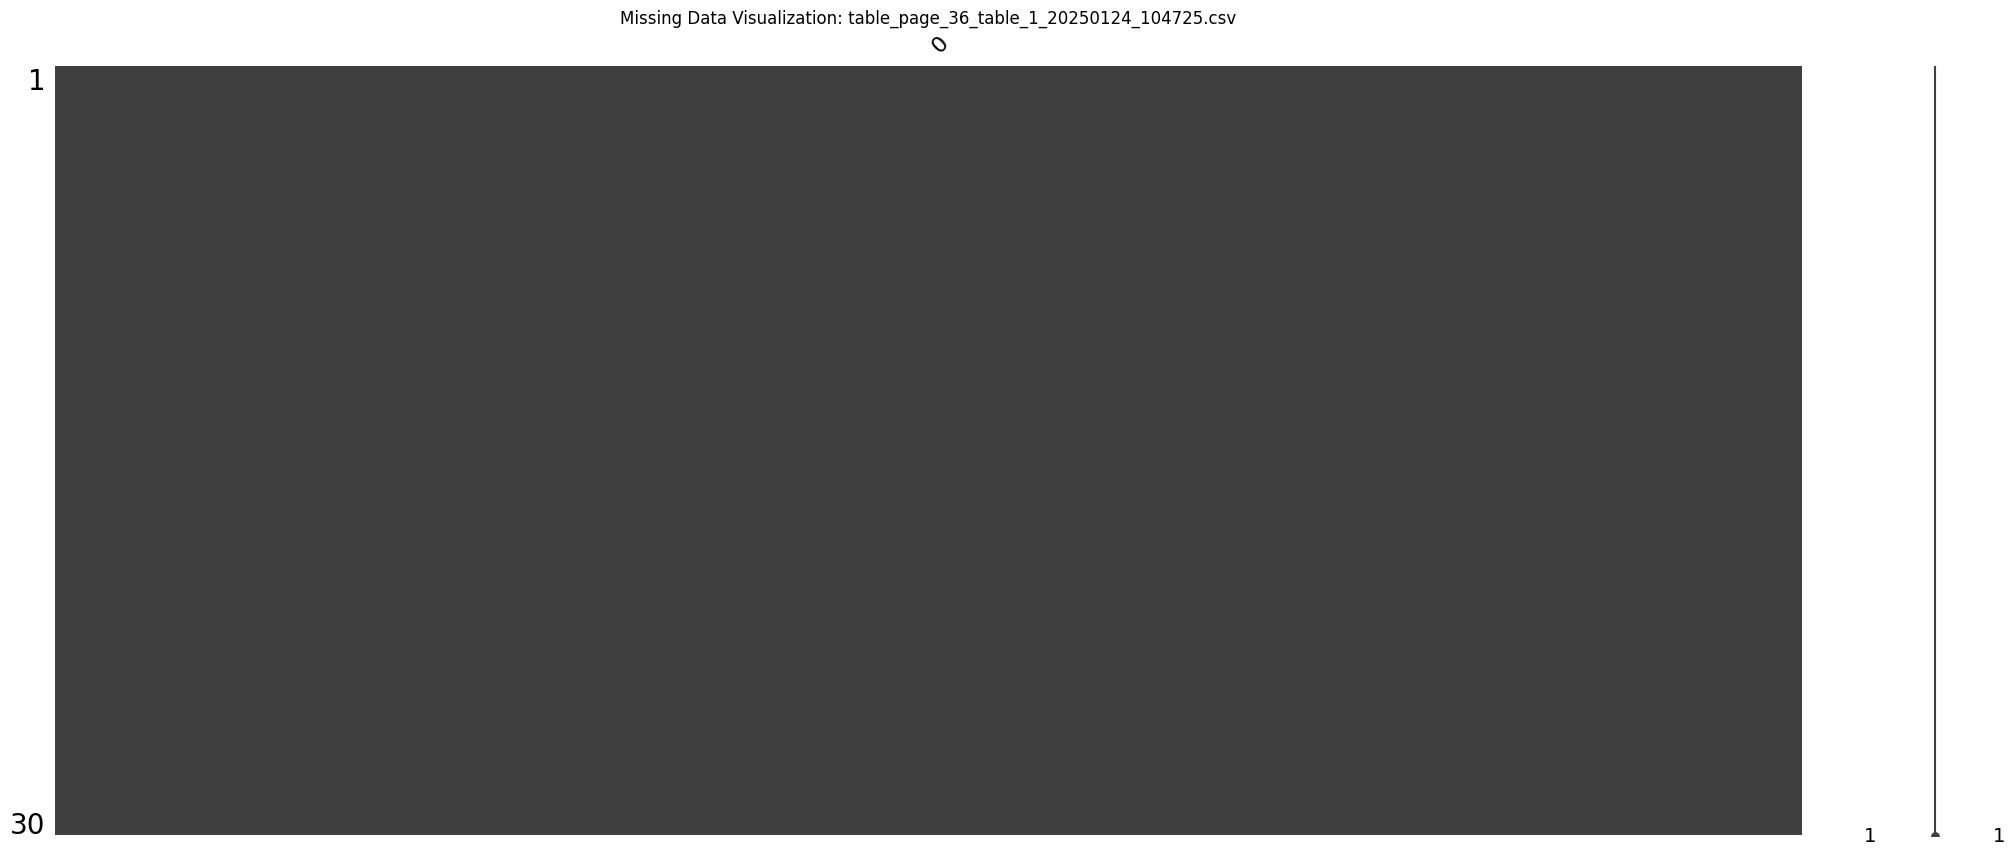

Missing Values for table_page_37_table_1_20250124_104725.csv:
0    10
1     3
dtype: int64


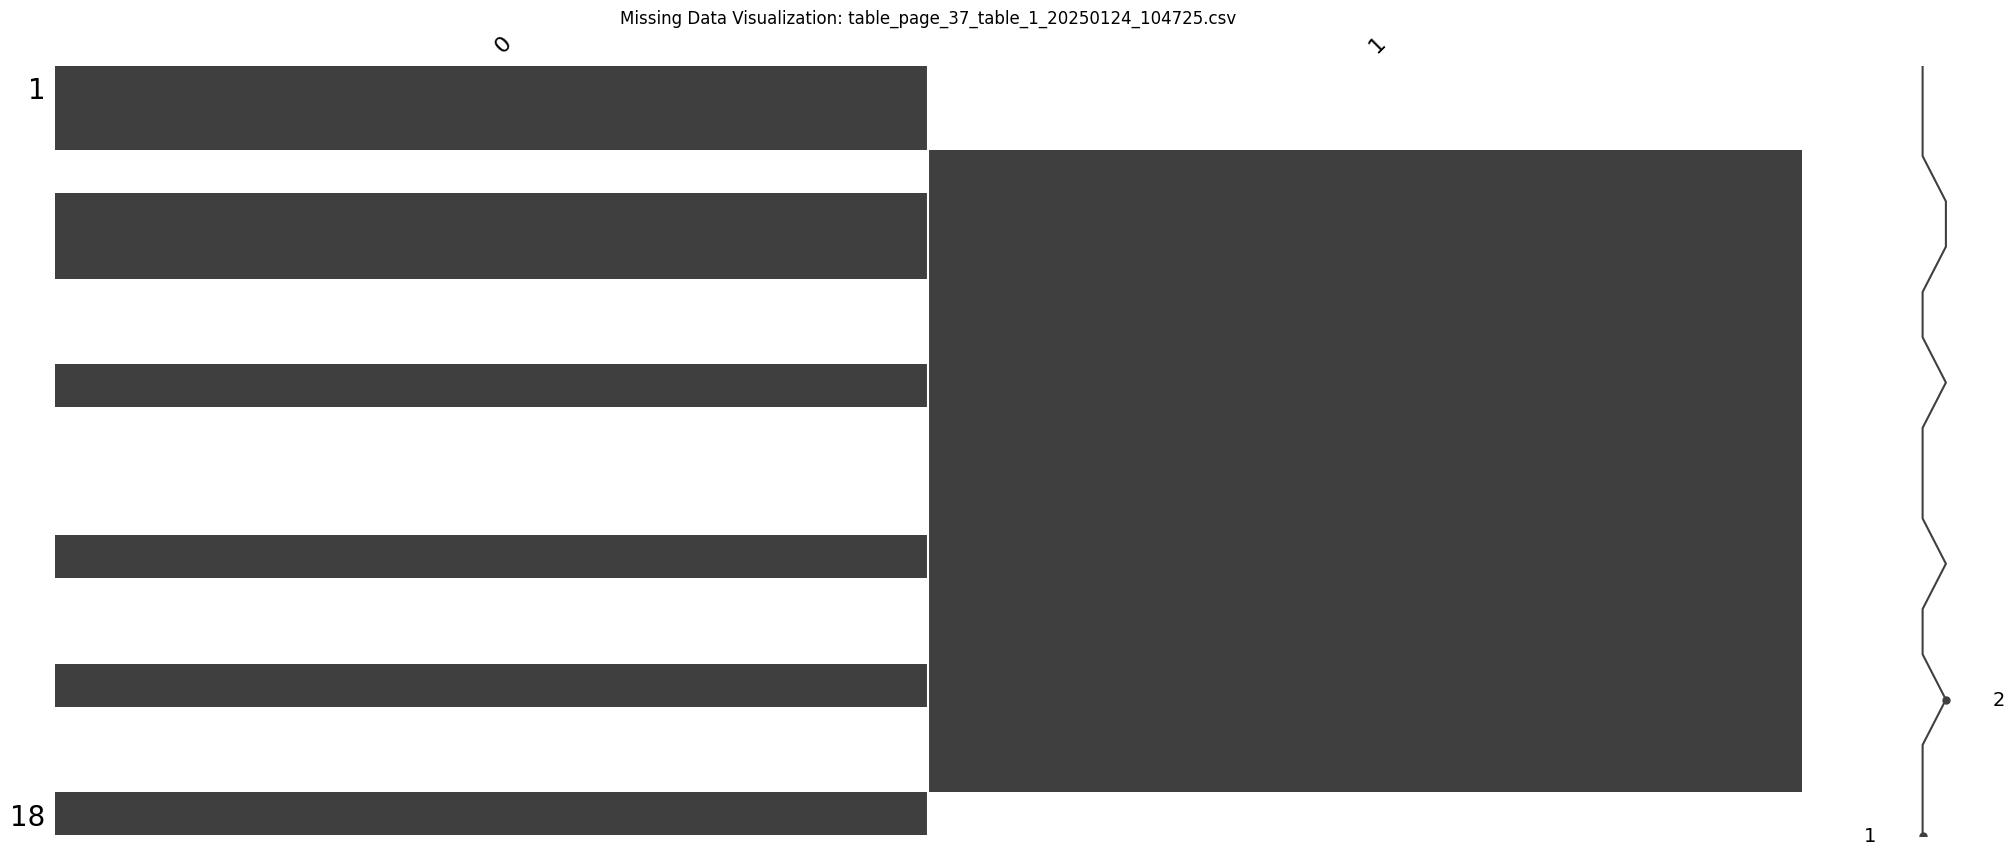

Missing Values for table_page_38_table_1_20250124_104725.csv:
0     9
1    18
2    16
3    18
4    18
5    18
6    18
7     3
dtype: int64


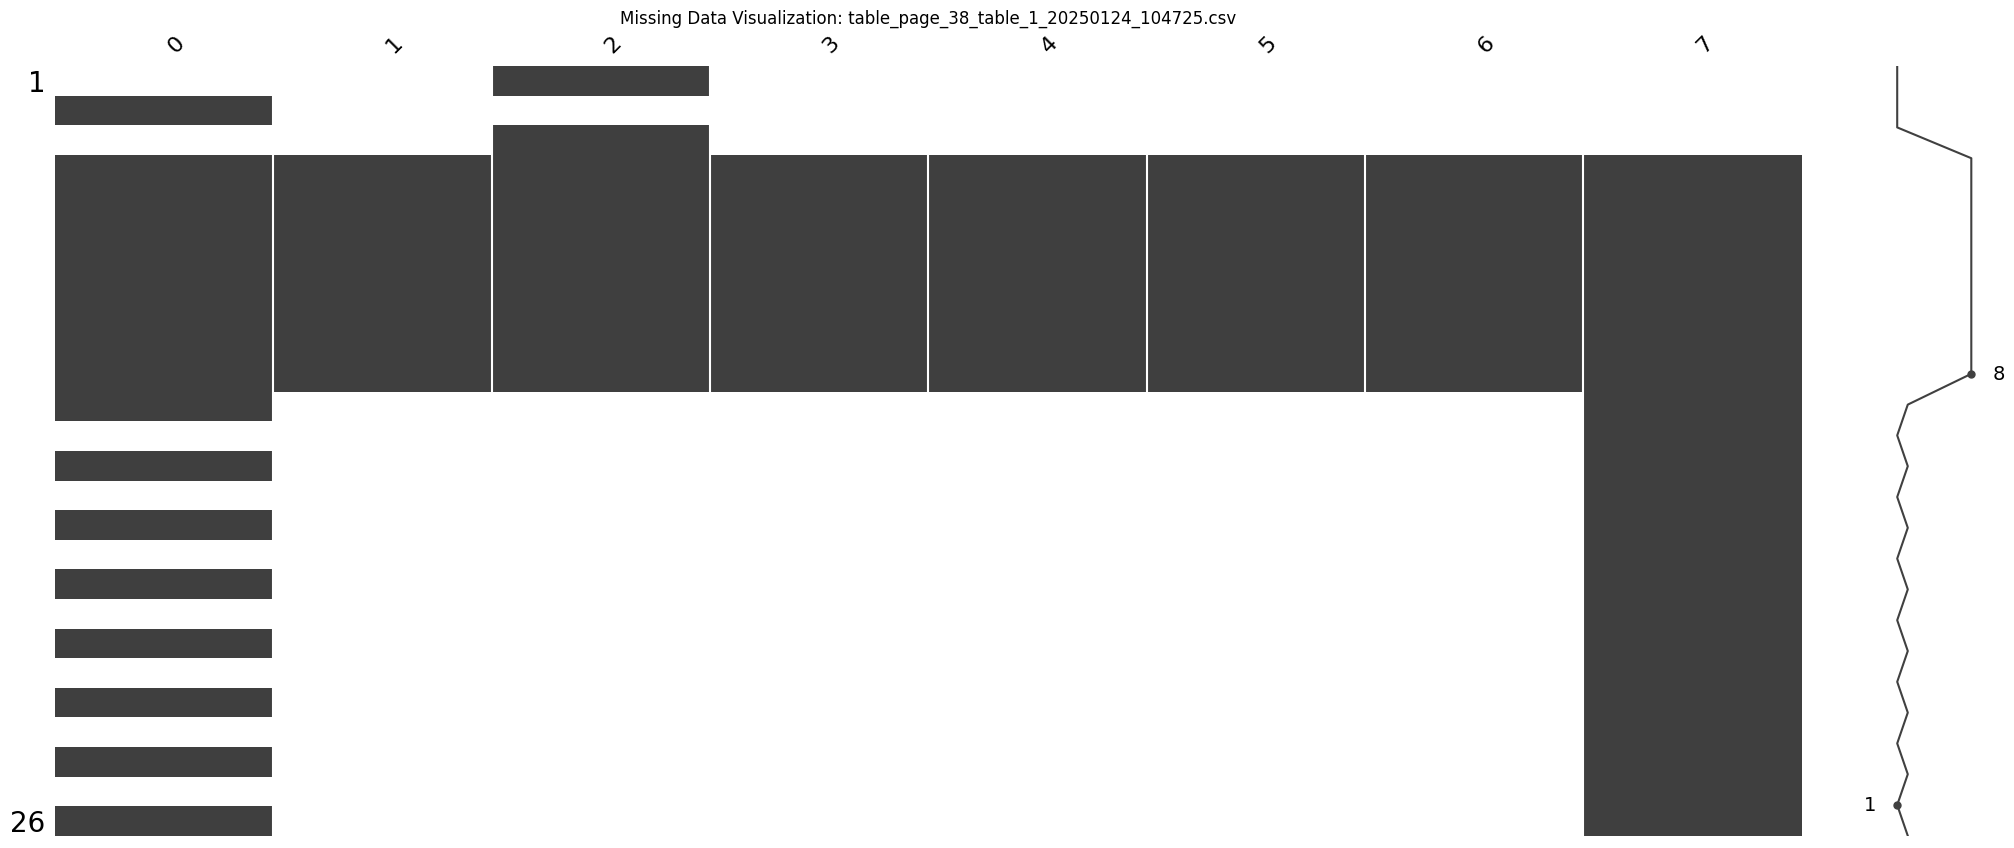

Missing Values for table_page_39_table_1_20250124_104725.csv:
0    14
1    17
2    18
3    17
4    15
5    18
6    18
7    17
8    17
9     4
dtype: int64


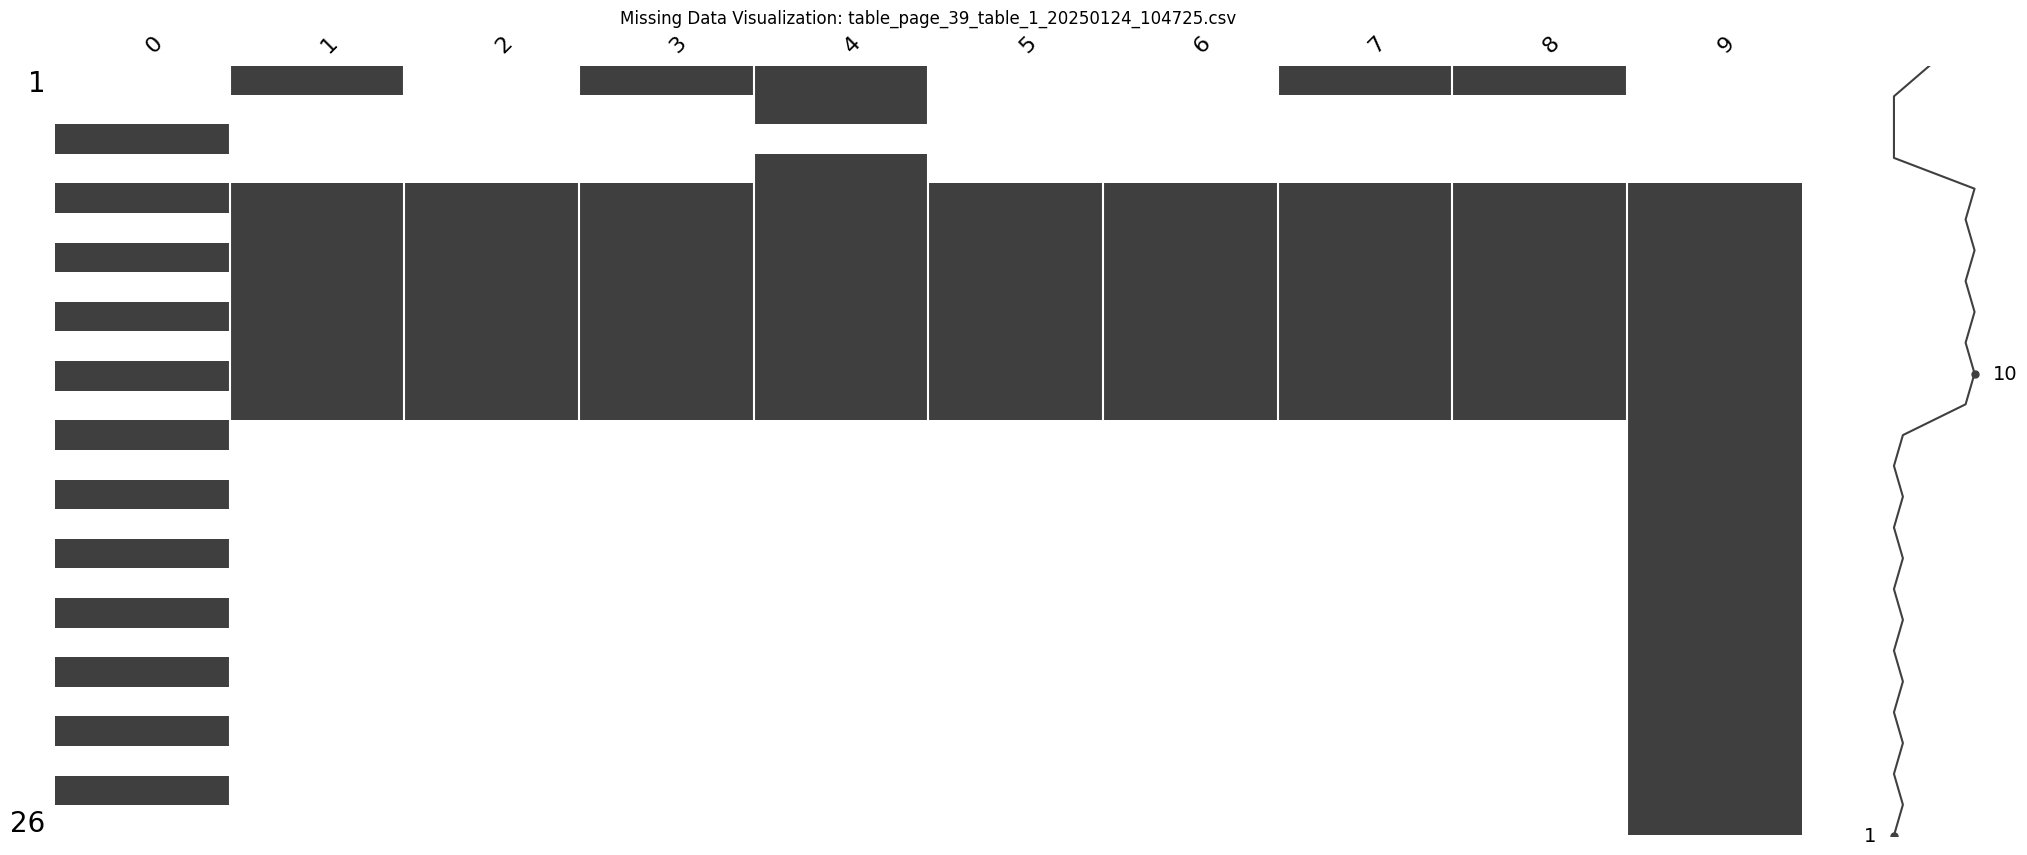

Missing Values for table_page_3_table_1_20250124_104725.csv:
0     4
1    29
2     9
3     8
4     7
dtype: int64


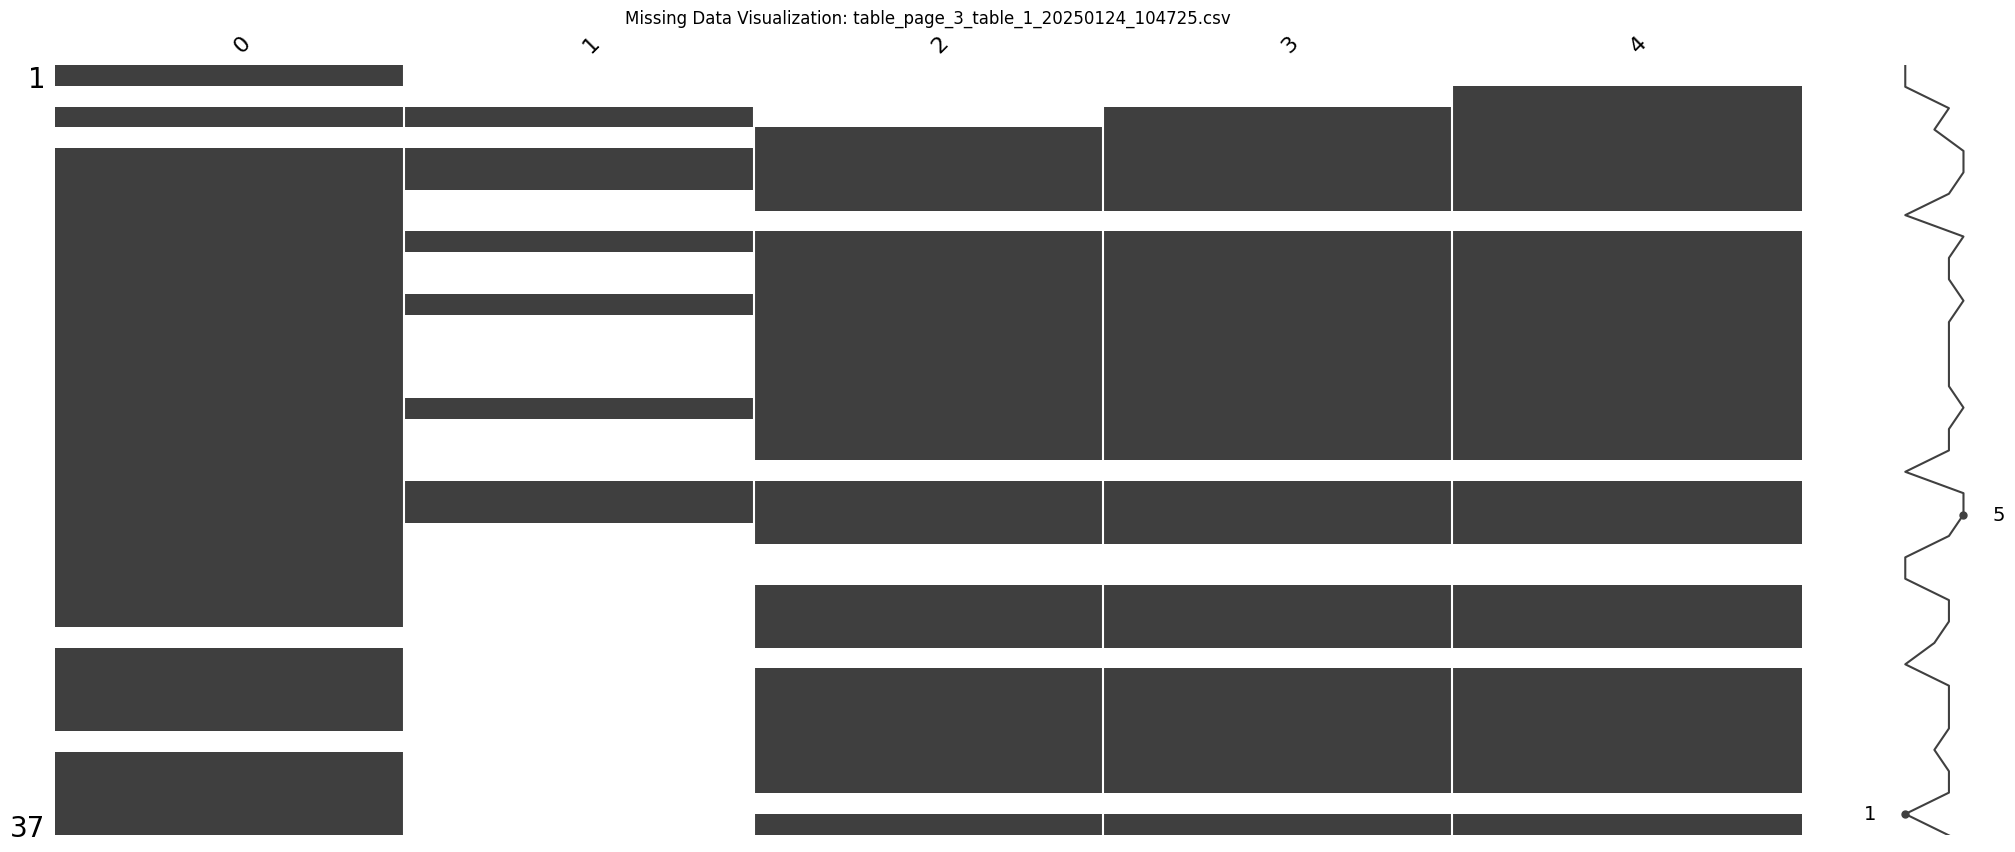

Missing Values for table_page_4_table_1_20250124_104725.csv:
0     10
1     13
2     12
3     13
4     13
5     13
6     11
7      9
8     10
9      8
10     6
11    11
dtype: int64


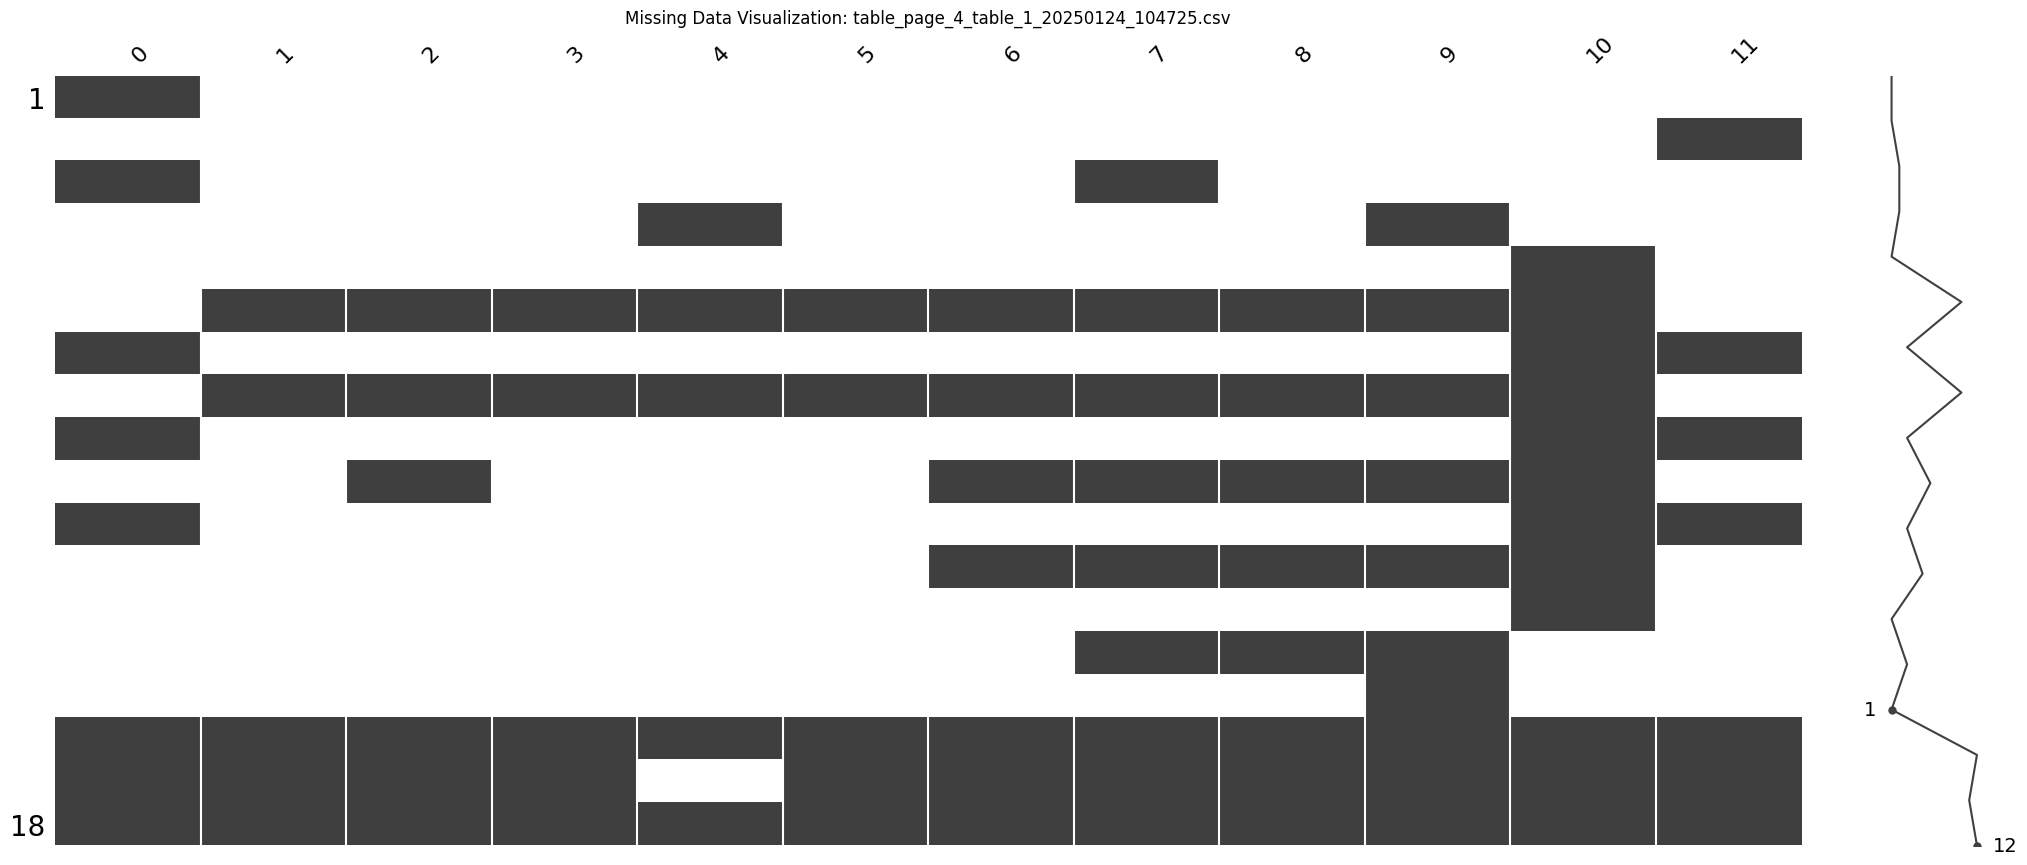

Missing Values for table_page_5_table_1_20250124_104725.csv:
0     3
1     6
2     6
3     6
4     6
5     6
6     6
7     6
8     5
9     6
10    5
11    4
12    6
13    7
14    5
15    7
16    6
dtype: int64


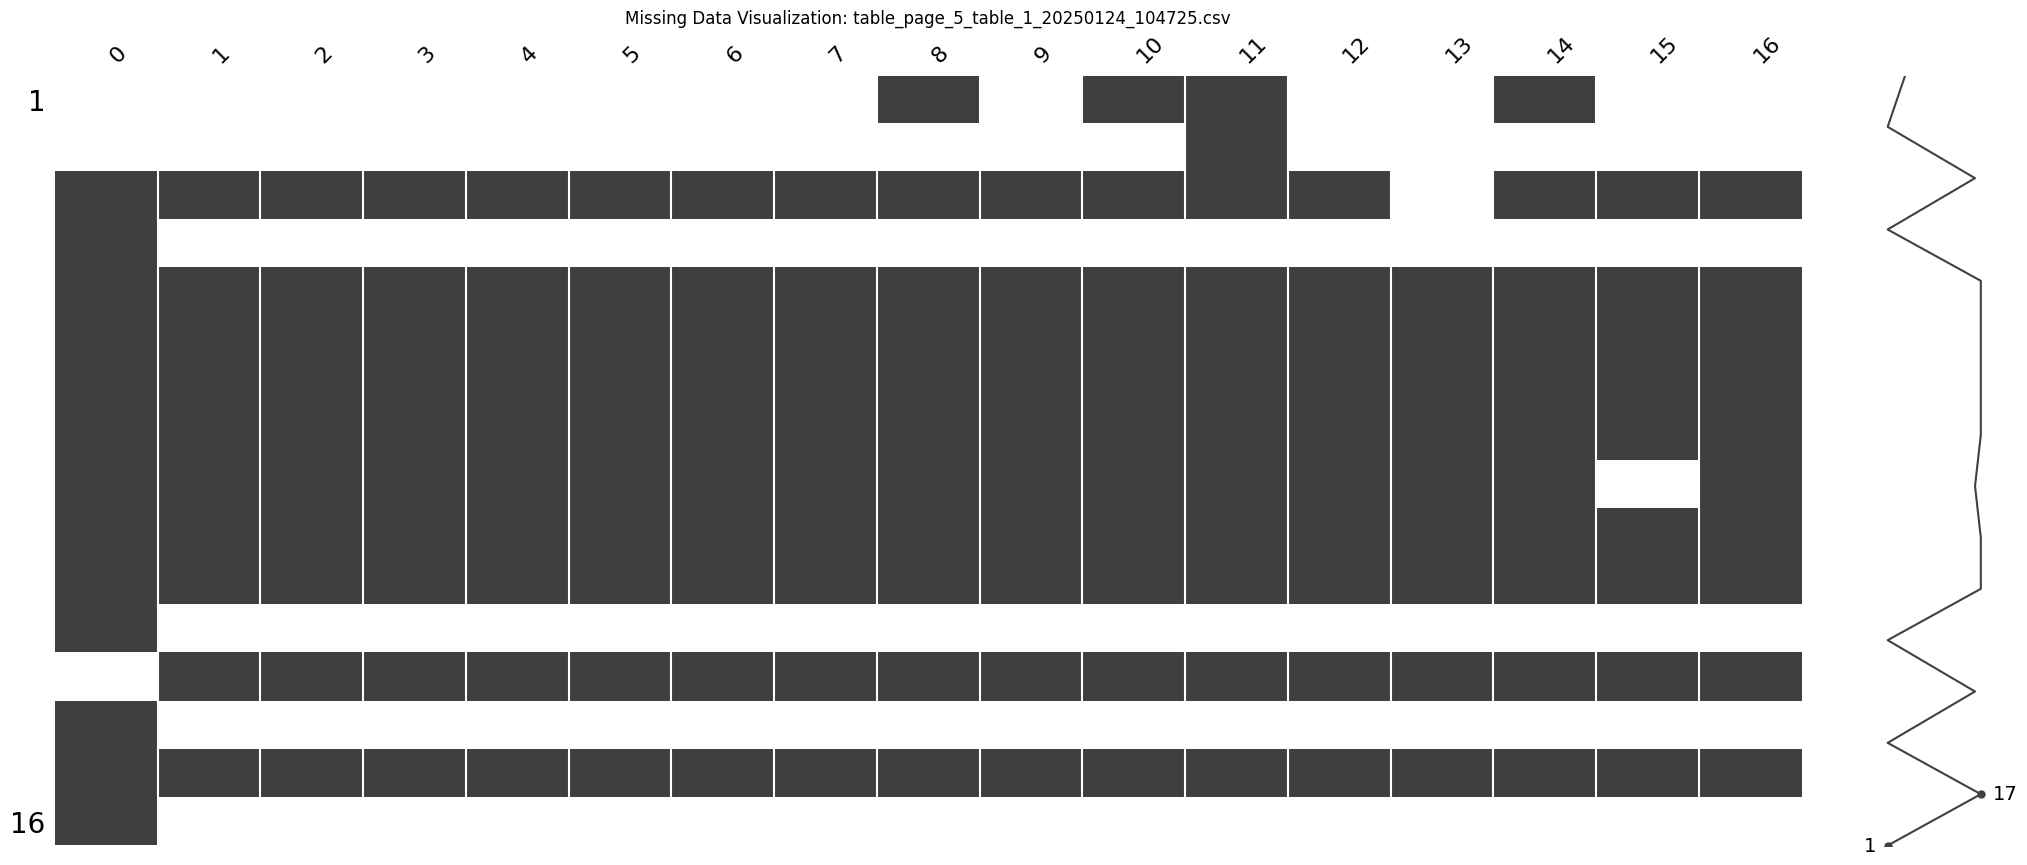

Missing Values for table_page_6_table_1_20250124_104725.csv:
0     4
1    25
2    10
dtype: int64


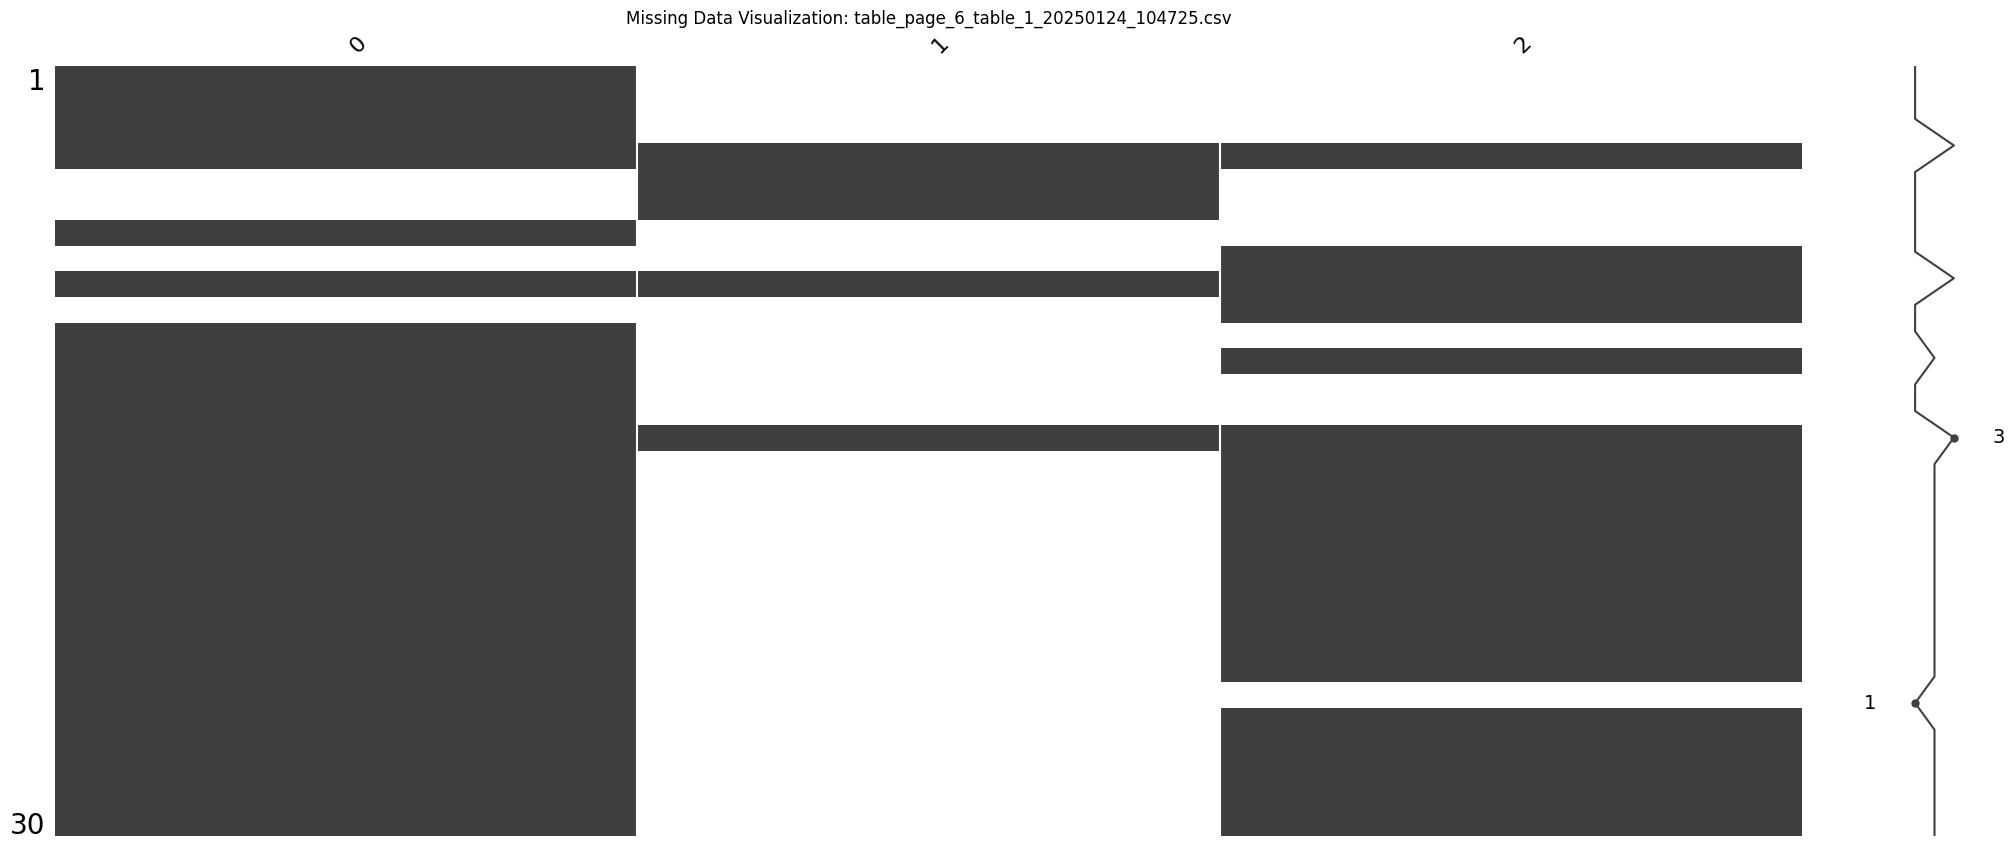

Missing Values for table_page_6_table_2_20250124_104725.csv:
0    0
1    2
2    2
dtype: int64


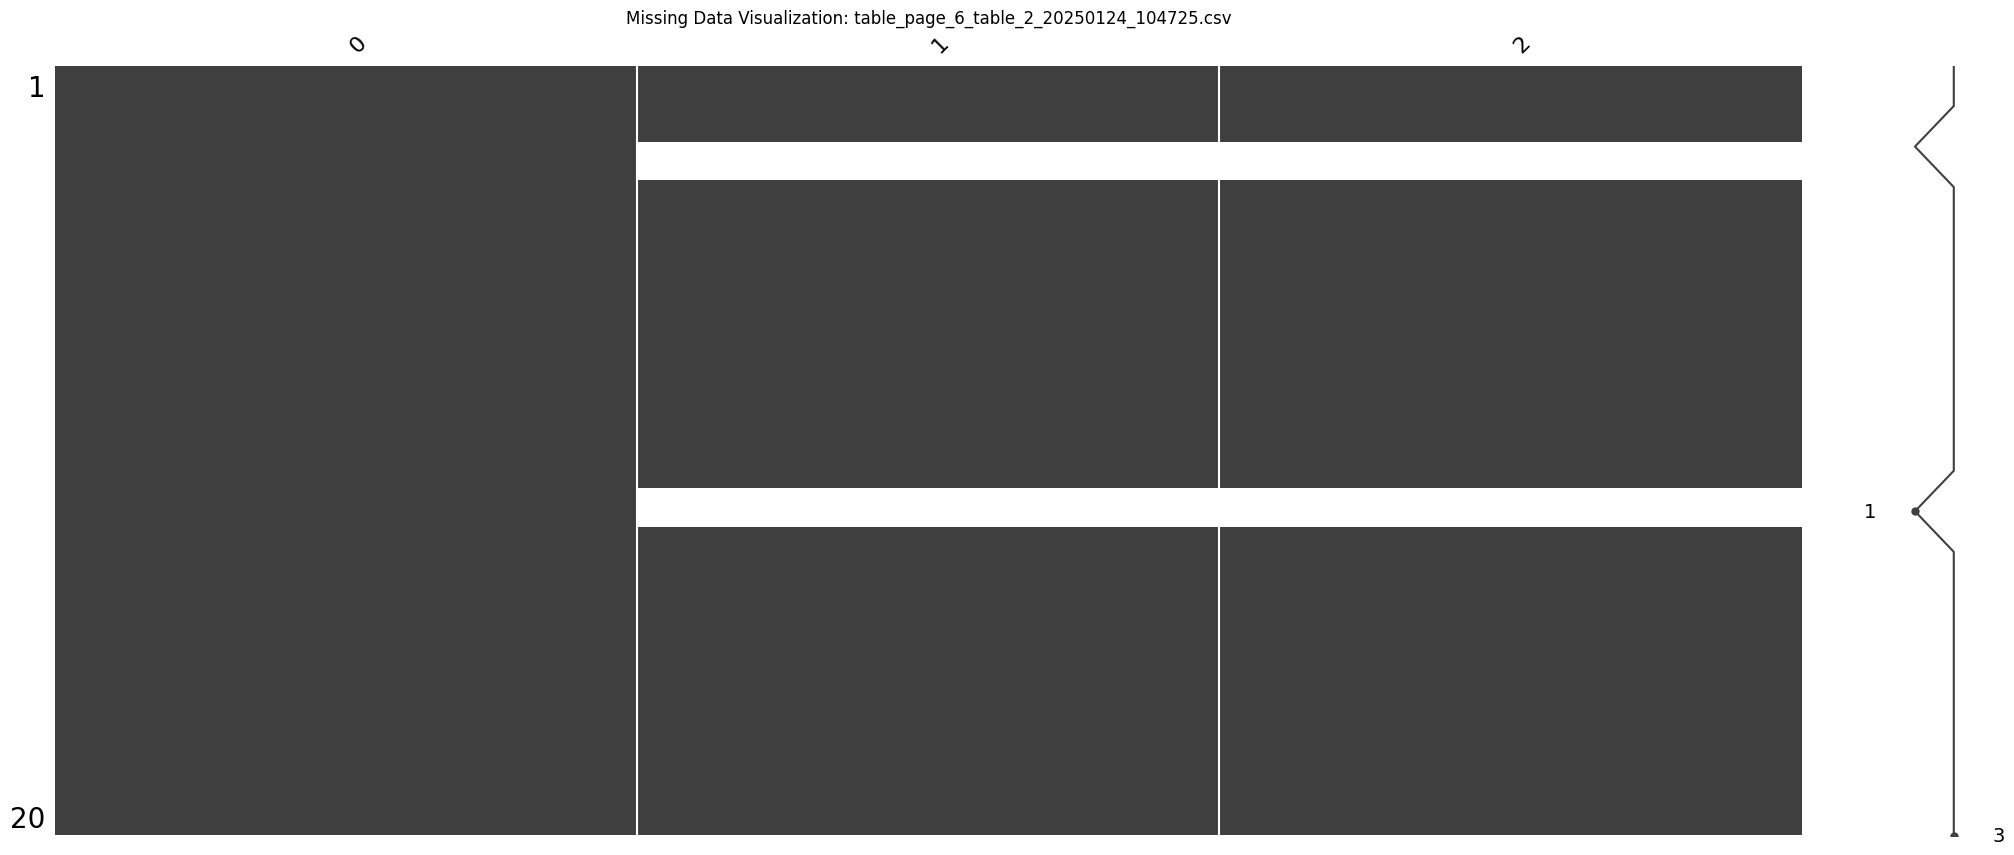

Missing Values for table_page_7_table_1_20250124_104725.csv:
0     0
1    18
2    10
3     8
dtype: int64


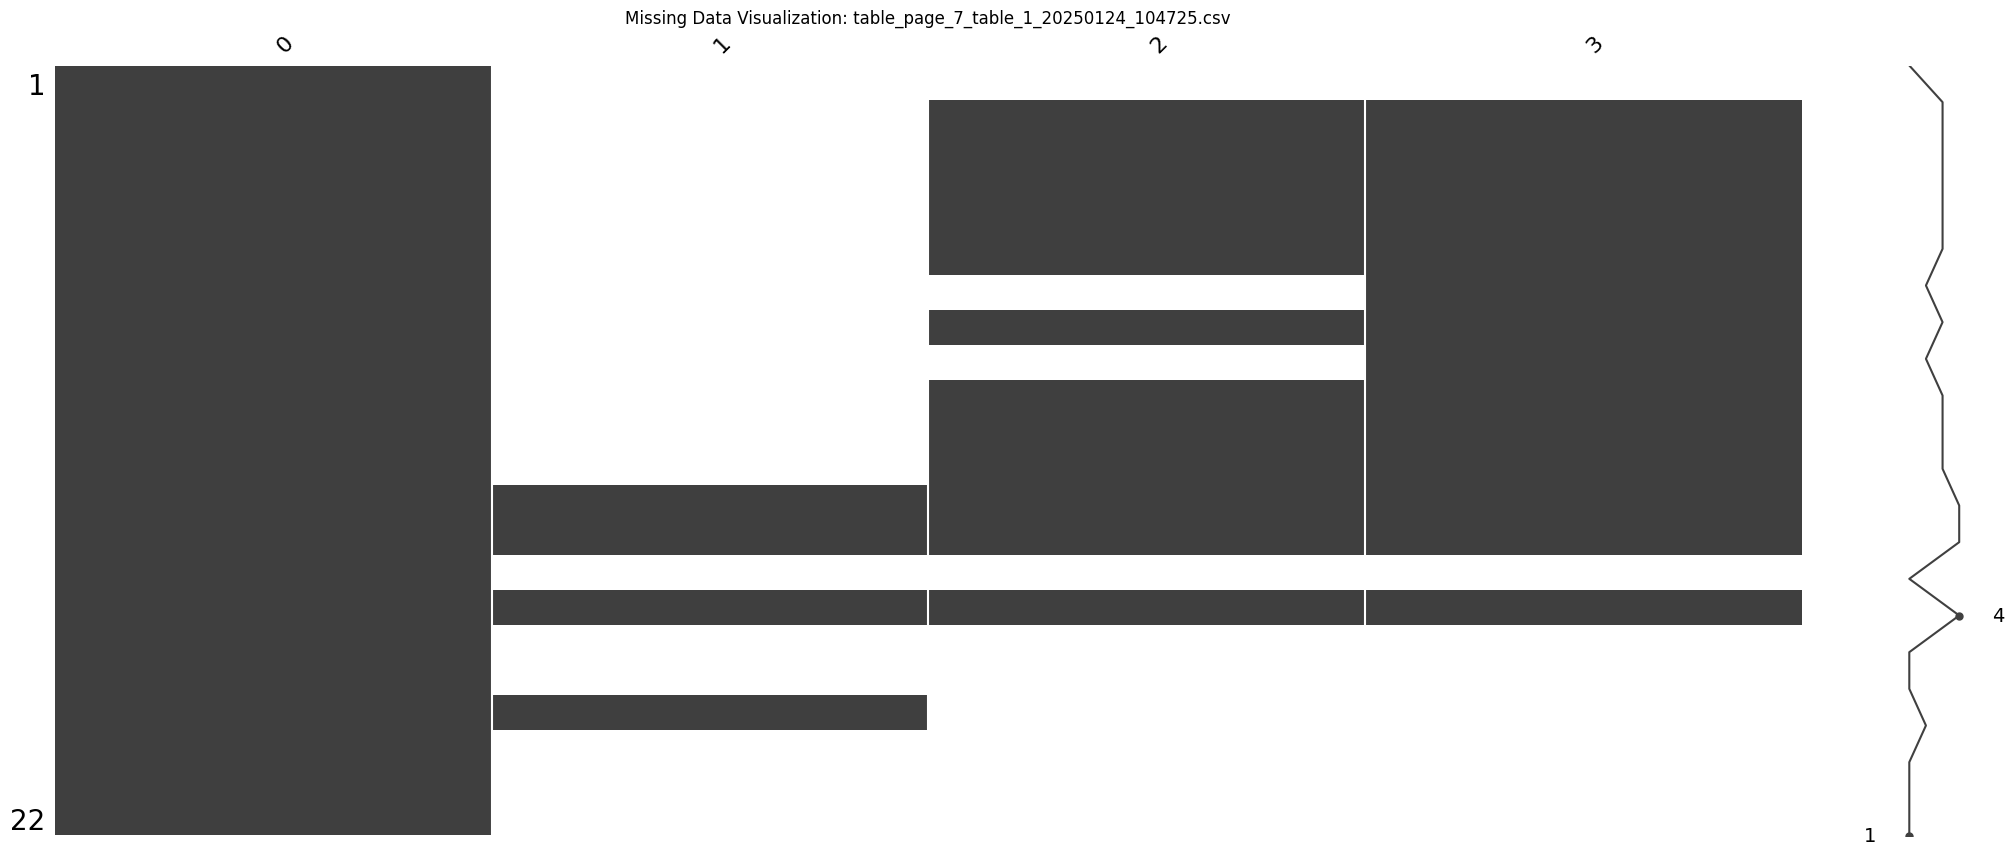

Missing Values for table_page_8_table_1_20250124_104725.csv:
0    0
dtype: int64


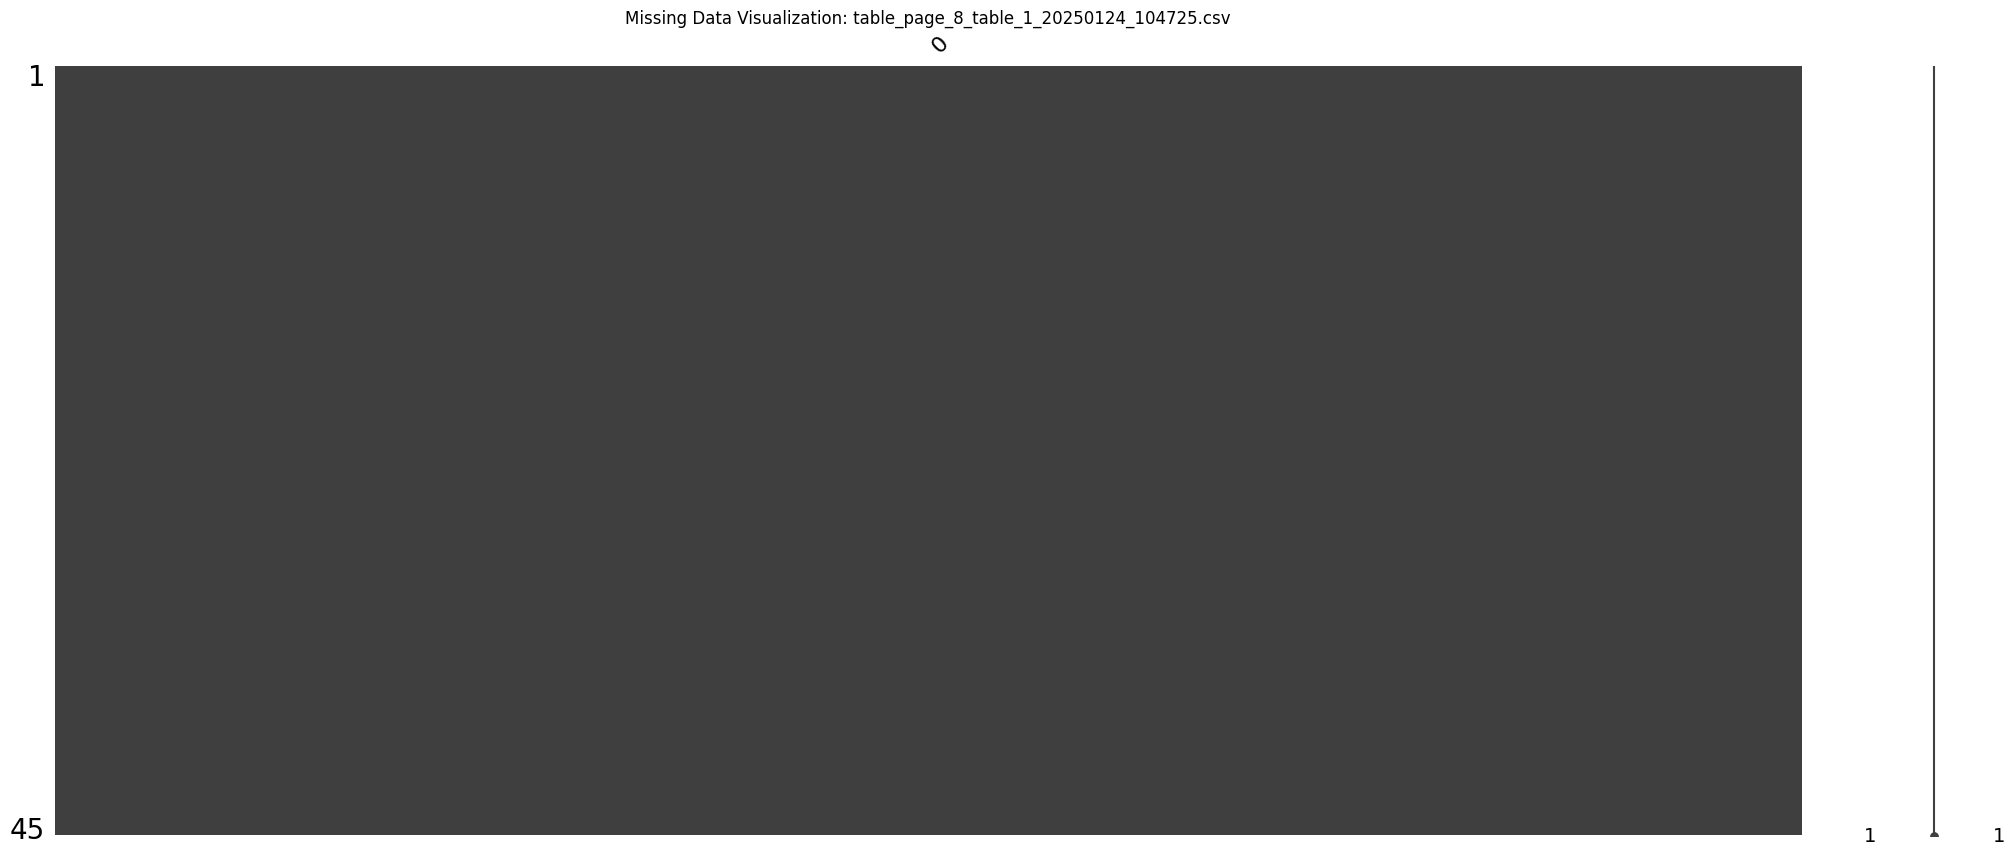

Missing Values for table_page_9_table_1_20250124_104725.csv:
0    0
dtype: int64


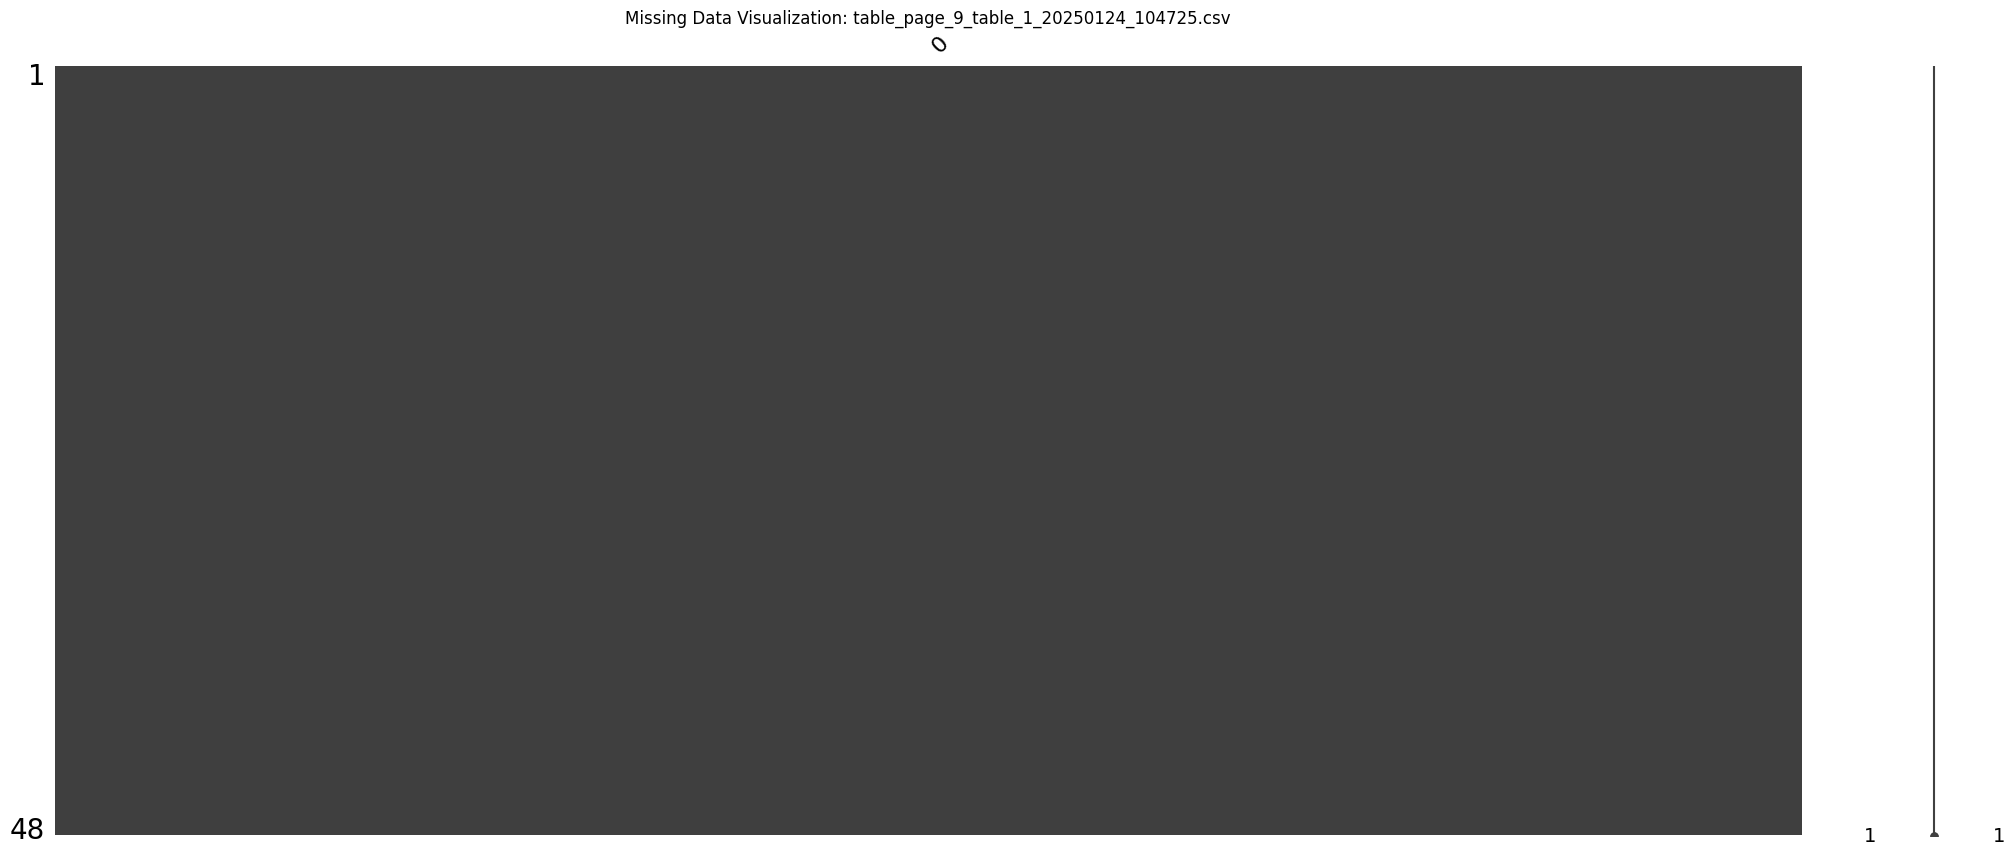

Descriptive Stats for table_page_10_table_1_20250124_104725.csv:
                                0
count                           7
unique                          7
top     e. Impairment of Goodwill
freq                            1
Descriptive Stats for table_page_11_table_1_20250124_104725.csv:
                                                        0
count                                                  52
unique                                                 52
top     2. Notes to the Interim Condensed Consolidated...
freq                                                    1
Descriptive Stats for table_page_12_table_1_20250124_104725.csv:
                            0
count                       7
unique                      7
top     Proposed acquisitions
freq                        1
Descriptive Stats for table_page_13_table_1_20250124_104725.csv:
                             0      1   2          3       4         5  \
count                       13     11  14         14    

In [6]:


# Step 1: Load all table files as DataFrames
def load_table_files(table_path):
    """Load all table files as DataFrames."""
    table_files = [os.path.join(table_path, f) for f in os.listdir(table_path) if f.endswith('.csv')]
    tables = {os.path.basename(f): pd.read_csv(f) for f in table_files}
    return tables

# Step 2: Analyze missing values in table files
def analyze_missing_values(tables):
    """Generate missing value visualizations and reports for table files."""
    for name, df in tables.items():
        print(f"Missing Values for {name}:")
        print(df.isnull().sum())
        msno.matrix(df)
        plt.title(f"Missing Data Visualization: {name}")
        plt.show()

# Step 3: Generate descriptive statistics and visualizations for tables
def generate_table_statistics(tables):
    """Generate descriptive statistics and correlation heatmaps for tables."""
    for name, df in tables.items():
        print(f"Descriptive Stats for {name}:")
        print(df.describe())
        if not df.select_dtypes(include=['number']).empty:  # Check if numerical columns exist
            sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
            plt.title(f"Correlation Heatmap: {name}")
            plt.show()

# Example execution (tables only)
table_path = "C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/table"

# Step 1: Load the table data
tables = load_table_files(table_path)

# Step 2: Analyze missing values
analyze_missing_values(tables)

# Step 3: Generate descriptive statistics
generate_table_statistics(tables)


In [7]:


# Step 1: Define the folder path containing text files
text_path = 'C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/text'

# Step 2: Combine all text files into a single dataset
combined_text = ""
page_metadata = []

for file_name in sorted(os.listdir(text_path)):
    if file_name.endswith(".txt"):
        with open(os.path.join(text_path, file_name), "r", encoding="utf-8") as f:
            page_text = f.read()
            combined_text += f"Page {file_name} Content:\n{page_text}\n\n"
            page_metadata.append({"file_name": file_name, "content": page_text})

# Step 3: Save the combined text to a file
output_file = "text_final_output.txt"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(combined_text)

print(f"Combined text saved to {output_file}")

# (Optional) Check if page metadata is preserved
for page in page_metadata[:3]:  # Display the first 3 pages for verification
    print(f"File: {page['file_name']}\nContent: {page['content'][:200]}...\n")


Combined text saved to text_final_output.txt
File: page_10_20250124_104725.txt
Content: e. Impairment of Goodwill
Goodwillistestedforimpairmentonanannualbasisandwheneverthereisanindicationthattherecoverableamountofacashgeneratingunit(CGUs)isless
thanitscarryingamount.Fortheimpairmenttest...

File: page_11_20250124_104725.txt
Content: 2. Notes to the Interim Condensed Consolidated Financial Statements
2.1 BUSINESS COMBINATIONS
Accounting policy
Business combinations have been accounted for using the acquisition method under the pro...

File: page_12_20250124_104725.txt
Content: Proposed acquisitions
On January 11, 2024, Infosys Limited entered into a definitive agreement to acquire 100% of the equity share capital in InSemi Technology Services Private
Limited, a semiconducto...



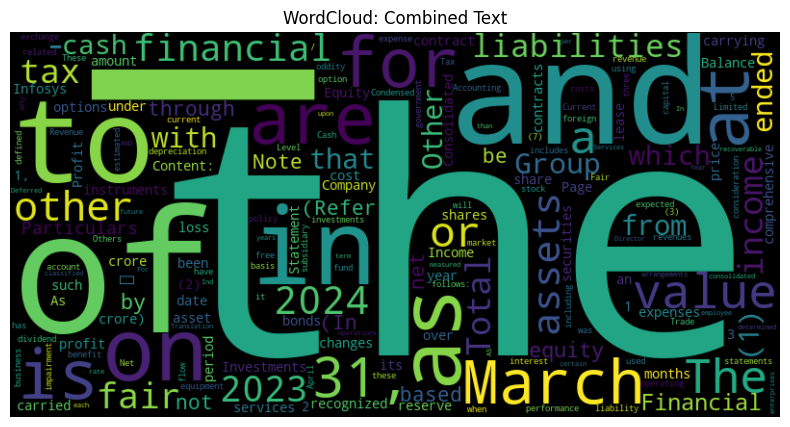

Word counts saved to word_count_report.txt


In [8]:
# Load combined text from text_final_output.txt
def load_combined_text(file_path):
    """Load the combined text file."""
    with open(file_path, "r", encoding="utf-8") as f:
        combined_text = f.read()
    return combined_text

def process_combined_text(combined_text):
    """Process combined text to generate word counts and word clouds."""
    word_counts = Counter(combined_text.split())

    # Generate WordCloud
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud: Combined Text")
    plt.show()

    return word_counts

def save_word_count_report(word_counts, output_file):
    """Save word counts to a text file."""
    with open(output_file, "w", encoding="utf-8") as f:
        for word, count in word_counts.most_common(50):
            f.write(f"{word}: {count}\n")
    print(f"Word counts saved to {output_file}")

# Main Execution
combined_text_path = "text_final_output.txt"
word_count_output = "word_count_report.txt"

# Load the combined text
combined_text = load_combined_text(combined_text_path)

# Process the combined text
word_counts = process_combined_text(combined_text)

# Save the word count report
save_word_count_report(word_counts, word_count_output)


In [9]:


# Download NLTK resources if not already available
nltk_data_path = '/content/nltk_data'
nltk.data.path.append(nltk_data_path)

# Check if punkt and stopwords are downloaded
if not os.path.exists(f"{nltk_data_path}/tokenizers/punkt"):
    nltk.download('punkt', download_dir=nltk_data_path)
if not os.path.exists(f"{nltk_data_path}/corpora/stopwords"):
    nltk.download('stopwords', download_dir=nltk_data_path)

print("NLTK resources are ready.")



NLTK resources are ready.


In [10]:

text_file_path = "C:/Users/91832/Desktop/RAG_Model_development/notebook/text_final_output.txt"

# Ensure the file exists
if os.path.exists(text_file_path):
    with open(text_file_path, 'r', encoding='utf-8') as file:
        combined_text = file.read()
    print(f"Loaded text data from {text_file_path}")
else:
    print(f"File not found: {text_file_path}")



Loaded text data from C:/Users/91832/Desktop/RAG_Model_development/notebook/text_final_output.txt


In [11]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(combined_text)

sentences = [sent.text for sent in doc.sents]
words = [token.text for token in doc if token.is_alpha]

print(f"Number of sentences: {len(sentences)}")
print(f"Number of words: {len(words)}")


Number of sentences: 619
Number of words: 15725


In [12]:
# Remove stopwords and keep only meaningful words
filtered_words = [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]

print(f"Filtered words count: {len(filtered_words)}")
print(f"Sample filtered words: {filtered_words[:10]}")  # Display the first 20 filtered words


Filtered words count: 10163
Sample filtered words: ['page', 'content', 'impairment', 'goodwill', 'thanitscarryingamount', 'fortheimpairmenttest', 'goodwillisallocatedtothecguorgroupsofcguswhichbenefitfromthesynergiesoftheacquisitionand', 'represent', 'lowest', 'level']


In [13]:
print(combined_text[:500])  # View the first 500 characters of the input text


Page page_10_20250124_104725.txt Content:
e. Impairment of Goodwill
Goodwillistestedforimpairmentonanannualbasisandwheneverthereisanindicationthattherecoverableamountofacashgeneratingunit(CGUs)isless
thanitscarryingamount.Fortheimpairmenttest,goodwillisallocatedtotheCGUorgroupsofCGUswhichbenefitfromthesynergiesoftheacquisitionand
which represent the lowest level at which goodwill is monitored for internal management purposes.
TherecoverableamountofCGUsisdeterminedbasedonhigherofvalue-in-useandfa


In [14]:

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Custom tokenizer: Define custom splitting rules
prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
infix_re = compile_infix_regex(nlp.Defaults.infixes + [r"(?<=[a-zA-Z])(?=[A-Z])"])  # Split by camel case
suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

# Assign custom tokenizer
custom_tokenizer = Tokenizer(
    nlp.vocab,
    rules=nlp.Defaults.tokenizer_exceptions,
    prefix_search=prefix_re.search,
    infix_finditer=infix_re.finditer,
    suffix_search=suffix_re.search,
)
nlp.tokenizer = custom_tokenizer

# Apply custom tokenizer
doc = nlp(combined_text)
tokens = [token.text for token in doc if token.is_alpha]

print(f"Sample tokens: {tokens[:50]}")  # Display the first 50 tokens


Sample tokens: ['Page', 'Content', 'Impairment', 'of', 'Goodwill', 'G', 'thanitscarryingamount', 'Fortheimpairmenttest', 'goodwillisallocatedtothe', 'C', 'G', 'Uorgroupsof', 'C', 'G', 'Uswhichbenefitfromthesynergiesoftheacquisitionand', 'which', 'represent', 'the', 'lowest', 'level', 'at', 'which', 'goodwill', 'is', 'monitored', 'for', 'internal', 'management', 'purposes', 'Therecoverableamountof', 'C', 'G', 'Usisdeterminedbasedonhigherofvalue', 'in', 'useandfairvaluelesscostto', 'sell', 'Keyassumptionsinthecashflowprojections', 'areprepared', 'basedoncurrenteconomicconditionsandcomprisesestimatedlongtermgrowthrates', 'weightedaveragecostofcapitalandestimatedoperating', 'margins', 'Refer', 'to', 'Note', 'Page', 'Content', 'Notes', 'to', 'the', 'Interim']


In [15]:
import sys
sys.path.append("C:/Users/91832/Desktop/RAG_Model_development/wordninja")

import wordninja


In [16]:


# Tokenize using Wordninja
tokens = []
for token in combined_text.split():  # Split the combined text into rough tokens first
    tokens.extend(wordninja.split(token))  # Split each rough token into meaningful words

print(f"Sample tokens: {tokens[:50]}")  # Display the first 50 tokens



Sample tokens: ['Page', 'page', '_', '10', '_', '20250124', '_', '104725', '.', 't', 'x', 't', 'Content', ':', 'e', '.', 'Impairment', 'of', 'Goodwill', 'Goodwill', 'is', 'tested', 'for', 'impairment', 'on', 'an', 'annual', 'basis', 'and', 'whenever', 'there', 'is', 'an', 'indication', 'that', 'the', 'recoverable', 'amount', 'of', 'a', 'cash', 'generating', 'unit', '(', 'C', 'G', 'U', 's', ')', 'i']


In [17]:


stop_words = set(stopwords.words("english"))
filtered_tokens = [word for word in tokens if word.lower() not in stop_words]


In [18]:


word_freq = Counter(filtered_tokens)
most_common_words = word_freq.most_common(20)



In [19]:

print(f"Filtered tokens count: {len(filtered_tokens)}")
print(f"Sample filtered tokens: {filtered_tokens[:20]}")


Filtered tokens count: 32611
Sample filtered tokens: ['Page', 'page', '_', '10', '_', '20250124', '_', '104725', '.', 'x', 'Content', ':', 'e', '.', 'Impairment', 'Goodwill', 'Goodwill', 'tested', 'impairment', 'annual']


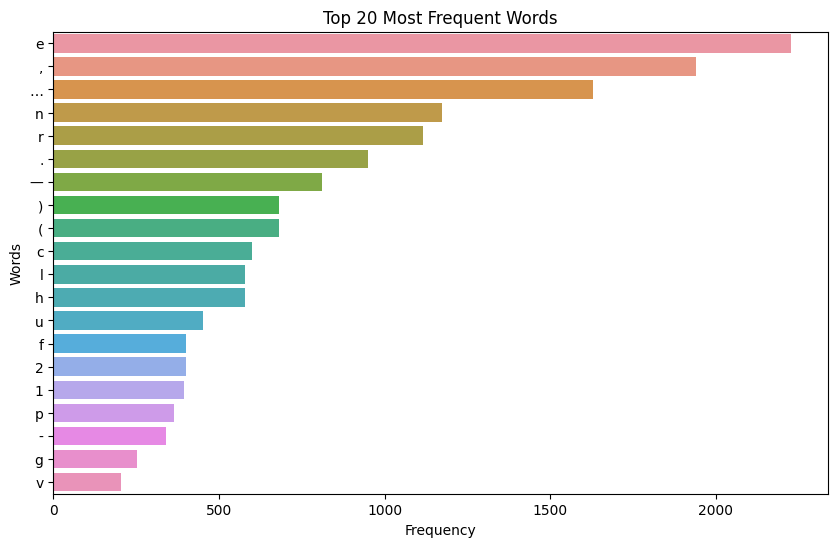

In [20]:


# Create a DataFrame for visualization
word_freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=word_freq_df)
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


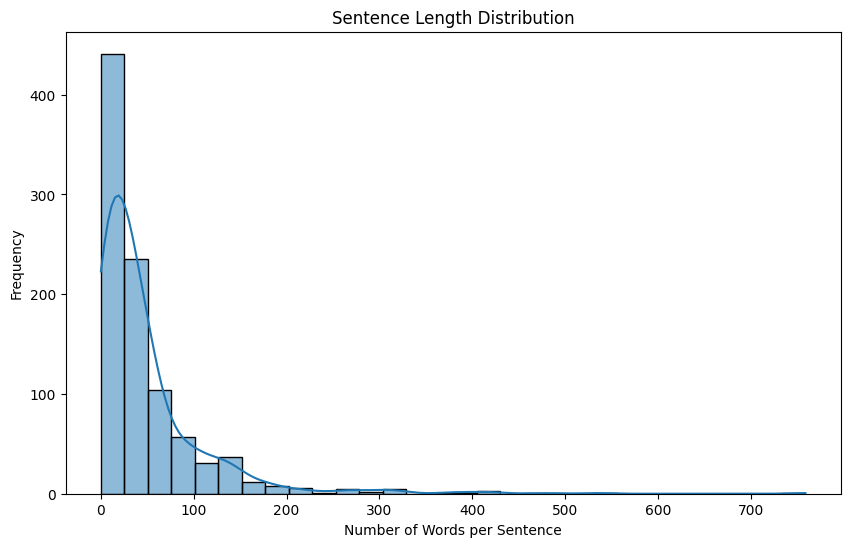

In [21]:
# Recreate sentences if needed
sentences = " ".join(tokens).split('.')  # Basic sentence split by period

# Calculate sentence lengths
sentence_lengths = [len(sent.split()) for sent in sentences]

# Plot sentence length distribution
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.show()



In [22]:


# Generate bigrams
bigrams = list(ngrams(filtered_tokens, 2))
bigram_freq = Counter(bigrams).most_common(20)

# Generate trigrams
trigrams = list(ngrams(filtered_tokens, 3))
trigram_freq = Counter(trigrams).most_common(20)

print("Top 20 Bigrams:", bigram_freq)
print("Top 20 Trigrams:", trigram_freq)


Top 20 Bigrams: [(('…', '…'), 1555), (('—', '—'), 529), (('e', 'r'), 388), (('r', 'e'), 386), (('h', 'e'), 353), (('e', 'n'), 351), (('1', ','), 232), (('e', 'e'), 231), ((')', '('), 196), (('n', 'e'), 190), (('31', ','), 174), (('l', 'e'), 173), (('March', '31'), 159), (('e', 'c'), 155), (('e', 'f'), 152), (('2', ','), 149), (('2', '.'), 144), (('c', 'e'), 131), (('n', 'c'), 130), (('v', 'e'), 126)]
Top 20 Trigrams: [(('…', '…', '…'), 1490), (('—', '—', '—'), 376), (('March', '31', ','), 159), (('e', 'r', 'e'), 118), (('31', ',', '2024'), 84), (('(', '1', ')'), 82), (('31', ',', '2023'), 70), (('r', 'e', 'n'), 68), (('e', 'e', 'n'), 64), (('e', 'h', 'e'), 63), (('r', 'r', 'e'), 63), (('e', 'n', 'e'), 62), (('f', 'e', 'r'), 59), (('ended', 'March', '31'), 58), (('h', 'e', 'r'), 57), (('n', 'c', 'e'), 55), (('n', 'h', 'e'), 52), (('r', 'e', 'e'), 50), (('h', 'e', 'e'), 50), (('e', 'f', 'e'), 49)]


In [23]:


# Vectorize the text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_matrix = vectorizer.fit_transform(filtered_tokens)

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_matrix)

# Display top words for each topic
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}:")
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])


Topic 0:
['carrying', 'note', 'based', 'investments', 'profit', 'fair', '2024', 'income', '2023', 'march']
Topic 1:
['date', 'period', 'asset', 'loss', 'net', 'page', 'equity', 'assets', 'financial', 'value']
Topic 2:
['comprehensive', 'changes', 'revenue', '10', 'ended', 'services', 'shares', 'cash', 'liabilities', '31']
Topic 3:
['costs', 'particulars', 'share', '14', 'lease', '12', '11', 'company', 'total', 'tax']
Topic 4:
['current', 'ys', 'year', 'recognized', 'consolidated', 'cost', 'contract', 'non', 'crore', 'group']


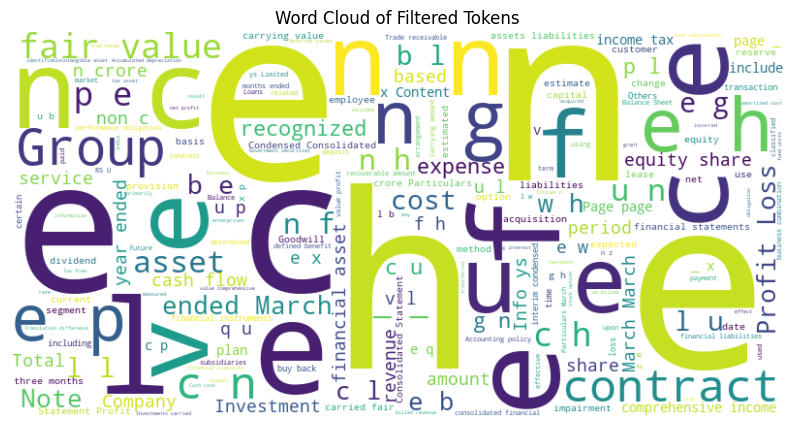

In [24]:


# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_tokens))

# Display word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Filtered Tokens")
plt.show()


In [25]:
# Reconstruct sentences from WordNinja tokens
cleaned_text = " ".join(filtered_tokens)  # Use filtered tokens from WordNinja


# Save reconstructed cleaned text to a file
cleaned_text_file_path = "/content/cleaned_text.txt"

with open(cleaned_text_file_path, "w", encoding="utf-8") as file:
    file.write(cleaned_text)

print(f"Cleaned text saved to: {cleaned_text_file_path}")



Cleaned text saved to: /content/cleaned_text.txt


In [26]:



# Analyze sentiment for the entire text
text_blob = TextBlob(cleaned_text)
print(f"Polarity: {text_blob.sentiment.polarity}")
print(f"Subjectivity: {text_blob.sentiment.subjectivity}")

Polarity: 0.09312550191354557
Subjectivity: 0.36488469139556035


In [27]:
nlp = spacy.load('en_core_web_sm')  # Load spaCy's pre-trained model
doc = nlp(cleaned_text)

# Extract and print entities
entities = [(ent.text, ent.label_) for ent in doc.ents]
print(f"Sample Entities: {entities[:10]}")


Sample Entities: [('10', 'CARDINAL'), ('104725', 'DATE'), ('Impairment Goodwill Goodwill', 'PERSON'), ('annual', 'DATE'), ('F', 'ORG'), ('g w l l l l', 'ORG'), ('n n', 'ORG'), ('K e u p n n h e c h', 'ORG'), ('l w p', 'ORG'), ('c p l n e e p e r n', 'ORG')]


In [28]:
# Post-process WordNinja output for cleaner input to spaCy
postprocessed_text = " ".join([word.capitalize() if word.islower() else word for word in filtered_tokens])


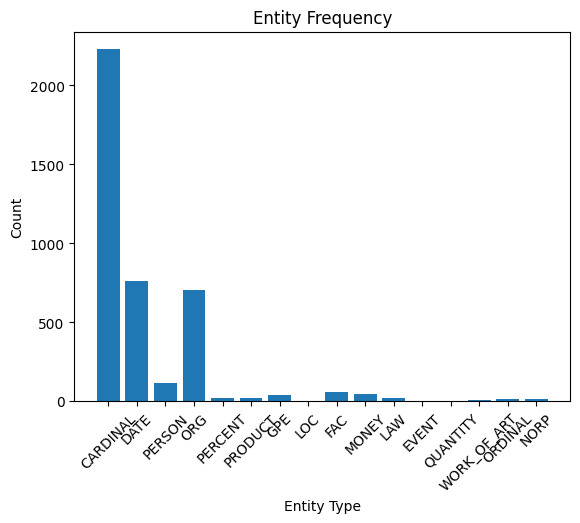

In [29]:


entity_counts = Counter([ent.label_ for ent in doc.ents])
plt.bar(entity_counts.keys(), entity_counts.values())
plt.title("Entity Frequency")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [30]:
# Save entities to a CSV file


entities_df = pd.DataFrame([(ent.text, ent.label_) for ent in doc.ents], columns=["Entity", "Type"])
entities_df.to_csv("ner_entities.csv", index=False)
print("Entities saved to ner_entities.csv")


Entities saved to ner_entities.csv


This code uses a pre-trained summarization model, facebook/bart-large-cnn, from the Hugging Face Transformers library to generate a concise summary of the input text. The model processes the first 1000 characters of the cleaned text and outputs a summary constrained by the max_length and min_length parameters. It is particularly useful for distilling long financial documents or reports into key highlights.

In [31]:

#from transformers import pipeline
# Use a pre-trained summarization model
#summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

#summary = summarizer(cleaned_text[:1000], max_length=100, min_length=30, do_sample=False)
#print("Summary:", summary[0]['summary_text'])


In [32]:
from nltk.tokenize import sent_tokenize
chunks = [cleaned_text[i:i+1000] for i in range(0, len(cleaned_text), 1000)]

import json

# Save text chunks to a JSON file
text_chunks_file_path = "C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/cleaned_text_chunks.json"

with open(text_chunks_file_path, "w", encoding="utf-8") as file:
    json.dump(chunks, file, indent=4)

print(f"Text chunks saved to: {text_chunks_file_path}")



Text chunks saved to: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/cleaned_text_chunks.json


In [33]:
print(f"Length of cleaned_text: {len(cleaned_text)}")


Length of cleaned_text: 140714


In [34]:
# Refined chunking
chunk_size = 1000  # Size of each chunk
chunks = [cleaned_text[i:i+chunk_size] for i in range(0, len(cleaned_text), chunk_size)]

# Print chunks for debugging
for idx, chunk in enumerate(chunks):
    print(f"Chunk {idx + 1}:\n{chunk[:100]}...\n")


Chunk 1:
Page page _ 10 _ 20250124 _ 104725 . x Content : e . Impairment Goodwill Goodwill tested impairment ...

Chunk 2:
 assets transferred , e q u n r u e n u e liabilities incurred assumed date acquisition , date contr...

Chunk 3:
alue assets acquired liabilities assumed Group's consolidated financial statements . payments relate...

Chunk 4:
rengthen Group ’ creative , branding experience design capabilities augment Group ’ life sciences ex...

Chunk 5:
e . Goodwill pertaining business combinations allocated operating segments fully described Note 2 . ...

Chunk 6:
, legal fees , due diligence fees , professional consulting fees expense incurred . transaction cost...

Chunk 7:
 p r x e l ₹ 4 , 045 crore ) , subject customary closing adjustments . 11 Page page _ 13 _ 20250124 ...

Chunk 8:
 r e e n h e p e r v e r w h c h h e n g e e n e x p e c u e h e e e . H e n c e , h e u e f u l liv...

Chunk 9:
asset . Impairment Property , plant equipment evaluated recover ability wheneve

In [35]:

headers = re.findall(r'\n[A-Z ]+\n', combined_text)


In [36]:
print(combined_text[:1000])  # View the first 1000 characters


Page page_10_20250124_104725.txt Content:
e. Impairment of Goodwill
Goodwillistestedforimpairmentonanannualbasisandwheneverthereisanindicationthattherecoverableamountofacashgeneratingunit(CGUs)isless
thanitscarryingamount.Fortheimpairmenttest,goodwillisallocatedtotheCGUorgroupsofCGUswhichbenefitfromthesynergiesoftheacquisitionand
which represent the lowest level at which goodwill is monitored for internal management purposes.
TherecoverableamountofCGUsisdeterminedbasedonhigherofvalue-in-useandfairvaluelesscostto sell.Keyassumptionsinthecashflowprojections
areprepared basedoncurrenteconomicconditionsandcomprisesestimatedlongtermgrowthrates,weightedaveragecostofcapitalandestimatedoperating
margins (Refer to Note 2.3.1).
9

Page page_11_20250124_104725.txt Content:
2. Notes to the Interim Condensed Consolidated Financial Statements
2.1 BUSINESS COMBINATIONS
Accounting policy
Business combinations have been accounted for using the acquisition method under the provisions of Ind AS 103, Busi

In [37]:
headers = re.findall(r'\n[A-Z ]+\n', combined_text)
print(f"Headers Found: {headers}")


Headers Found: ['\nINFOSYS LIMITED AND SUBSIDIARIES\n', '\nEQUITY SHARE CAPITAL\n', '\nRSU\n', '\nINFOSYS LIMITED AND SUBSIDIARIES\n', '\nASSETS\n', '\nEQUITY AND LIABILITIES\n', '\nINFOSYS LIMITED AND SUBSIDIARIES\n', '\nINFOSYS LIMITED AND SUBSIDIARIES\n', '\nINFOSYS LIMITED AND SUBSIDIARIES\n', '\nINFOSYS LIMITED AND SUBSIDIARIES\n']


Avoid Duplicate headers

In [38]:
# Remove duplicates while preserving order
unique_headers = []
for header in headers:
    if header.strip() not in unique_headers:
        unique_headers.append(header.strip())

print(f"Unique Headers: {unique_headers}")


Unique Headers: ['INFOSYS LIMITED AND SUBSIDIARIES', 'EQUITY SHARE CAPITAL', 'RSU', 'ASSETS', 'EQUITY AND LIABILITIES']


In [39]:
# Split the text into sections using the headers
sections = re.split(r'\n[A-Z ]+\n', combined_text)

# Map each section to its corresponding header
header_section_mapping = {}
for idx, section in enumerate(sections):
    header = unique_headers[idx] if idx < len(unique_headers) else "Unknown Section"
    header_section_mapping[header] = section.strip()

# Print each header with its corresponding content (first 100 characters)
for header, content in header_section_mapping.items():
    print(f"Header: {header}\nContent: {content[:100]}...\n")


Header: INFOSYS LIMITED AND SUBSIDIARIES
Content: Page page_10_20250124_104725.txt Content:
e. Impairment of Goodwill
Goodwillistestedforimpairmentona...

Header: EQUITY SHARE CAPITAL
Content: Condensed Consolidated Financial Statements under
Indian Accounting Standards (Ind AS)
for the three...

Header: RSU
Content: (In ₹ crore, except as otherwise stated)
Particulars As at
March 31, 2024 March 31, 2023
Authorized
...

Header: ASSETS
Content: Weighted average share price (₹) / ($ ADS) 1,588 19.19 1,525 18.08
Exercise price (₹) / ($ ADS) 5.00...

Header: EQUITY AND LIABILITIES
Content: (In ₹ crore )
Condensed Consolidated Balance Sheets as at Note No. March 31, 2024 March 31, 2023...

Header: Unknown Section
Content: Overview and notes to the Interim Condensed Consolidated Financial Statements
1. Overview
1.1 Compan...



In [40]:


# Create a DataFrame
df = pd.DataFrame(list(header_section_mapping.items()), columns=["Header", "Content"])

# Save to CSV
df.to_csv("headers_and_sections.csv", index=False)
print("Headers and sections saved to 'headers_and_sections.csv'.")


Headers and sections saved to 'headers_and_sections.csv'.


Data Preprocessing For  Table Data

In [41]:
def handle_missing_values(table_folder, output_folder):
    """
    Handle missing values in tables by replacing empty or null-like values with NaN.
    Parameters:
        table_folder (str): Path to the folder containing raw table files.
        output_folder (str): Path to the folder for saving cleaned tables.
    """
    # Remove old files in the output folder if it exists
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
        print(f"Old files removed from: {output_folder}")

    # Recreate the output folder
    os.makedirs(output_folder, exist_ok=True)

    table_files = [os.path.join(table_folder, f) for f in os.listdir(table_folder) if f.endswith('.csv')]

    for table_file in table_files:
        try:
            # Load the table
            df = pd.read_csv(table_file)

            # Replace missing or inconsistent values with NaN
            df.replace(to_replace=[r'^\s*$', r'^-$', None, 'null', 'NaN'], value=np.nan, regex=True, inplace=True)

            # Log missing values count
            missing_values = df.isnull().sum().sum()
            print(f"Missing values in table {os.path.basename(table_file)}: {missing_values}")

            # Save the cleaned table to the output folder
            output_file_path = os.path.join(output_folder, os.path.basename(table_file))
            df.to_csv(output_file_path, index=False)

            print(f"Cleaned table saved: {output_file_path}")
        except Exception as e:
            print(f"Error processing table {table_file}: {e}")

# Example usage
raw_table_folder = "C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/table"  # Replace with your raw table folder path
cleaned_table_folder = "C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/cleaned_table_files"  # Replace with your desired cleaned table folder path
handle_missing_values(raw_table_folder, cleaned_table_folder)


Missing values in table table_page_10_table_1_20250124_104725.csv: 0
Cleaned table saved: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/cleaned_table_files\table_page_10_table_1_20250124_104725.csv
Missing values in table table_page_11_table_1_20250124_104725.csv: 0
Cleaned table saved: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/cleaned_table_files\table_page_11_table_1_20250124_104725.csv
Missing values in table table_page_12_table_1_20250124_104725.csv: 0
Cleaned table saved: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/cleaned_table_files\table_page_12_table_1_20250124_104725.csv
Missing values in table table_page_13_table_1_20250124_104725.csv: 35
Cleaned table saved: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/cleaned_table_files\table_page_13_table_1_20250124_104725.csv
Missing values in table table_page_13_table_2_20250124_104725.csv: 312
Cleaned table saved: C:/Users/91832/Desktop/RAG_Mode

In [42]:
def verify_missing_values(cleaned_table_folder):
    """
    Verify missing values in cleaned tables.
    Parameters:
        cleaned_table_folder (str): Path to the folder containing cleaned table files.
    """
    table_files = [os.path.join(cleaned_table_folder, f) for f in os.listdir(cleaned_table_folder) if f.endswith('.csv')]

    for table_file in table_files:
        try:
            # Load the table
            df = pd.read_csv(table_file)

            # Check for missing values
            print(f"Missing values in table {os.path.basename(table_file)}:")
            print(df.isnull().sum())  # Column-wise missing values
            print("\n")
        except Exception as e:
            print(f"Error verifying table {table_file}: {e}")

# Example usage
verify_missing_values(cleaned_table_folder)


Missing values in table table_page_10_table_1_20250124_104725.csv:
0    0
dtype: int64


Missing values in table table_page_11_table_1_20250124_104725.csv:
0    0
dtype: int64


Missing values in table table_page_12_table_1_20250124_104725.csv:
0    0
dtype: int64


Missing values in table table_page_13_table_1_20250124_104725.csv:
0    4
1    6
2    3
3    3
4    3
5    3
6    3
7    3
8    4
9    3
dtype: int64


Missing values in table table_page_13_table_2_20250124_104725.csv:
0    18
1    20
2    32
3    35
4    35
5    35
6    33
7    35
8    38
9    31
dtype: int64


Missing values in table table_page_14_table_1_20250124_104725.csv:
0    17
1    15
2    17
3    17
4    15
5    16
6    16
7    18
8    19
9    17
dtype: int64


Missing values in table table_page_15_table_1_20250124_104725.csv:
0    0
dtype: int64


Missing values in table table_page_16_table_1_20250124_104725.csv:
0    4
1    7
2    7
dtype: int64


Missing values in table table_page_17_table_1_20250124_104725.csv

In [43]:

def flatten_tables(input_folder, output_folder):
    """
    Flatten tables without modifying or separating year columns.
    Parameters:
        input_folder (str): Path to folder containing cleaned table files.
        output_folder (str): Path to save flattened tables.
    """
    # Clear the output folder if it exists
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
        print(f"Cleared existing files in: {output_folder}")
    os.makedirs(output_folder, exist_ok=True)

    table_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.csv')]

    for table_file in table_files:
        try:
            # Load the table
            df = pd.read_csv(table_file)

            # Flatten the data: Ensure rows and columns are properly aligned
            df = df.reset_index(drop=True)

            # Save the processed table
            output_file_path = os.path.join(output_folder, os.path.basename(table_file))
            df.to_csv(output_file_path, index=False)
            print(f"Flattened table saved: {output_file_path}")
        except Exception as e:
            print(f"Error processing table {table_file}: {e}")

# Example usage
cleaned_table_folder = "C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/cleaned_table_files"  # Replace with your cleaned table folder path
flattened_table_folder = "C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/flatten_table"  # Replace with your desired output folder path
flatten_tables(cleaned_table_folder, flattened_table_folder)


Flattened table saved: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/flatten_table\table_page_10_table_1_20250124_104725.csv
Flattened table saved: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/flatten_table\table_page_11_table_1_20250124_104725.csv
Flattened table saved: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/flatten_table\table_page_12_table_1_20250124_104725.csv
Flattened table saved: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/flatten_table\table_page_13_table_1_20250124_104725.csv
Flattened table saved: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/flatten_table\table_page_13_table_2_20250124_104725.csv
Flattened table saved: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/flatten_table\table_page_14_table_1_20250124_104725.csv
Flattened table saved: C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/flatten_table\table_page_15_table_

In [44]:


# Tokenize cleaned_text using WordNinja
cleaned_text_tokens = wordninja.split(cleaned_text)
print(f"Tokenized cleaned_text count (WordNinja): {len(cleaned_text_tokens)}")

# Compare with filtered_tokens
if len(cleaned_text_tokens) == len(filtered_tokens):
    print("No missing data: Token counts match.")
else:
    print("Mismatch detected: Check for possible issues.")


Tokenized cleaned_text count (WordNinja): 65221
Mismatch detected: Check for possible issues.


Generate embeddings for your cleaned_text_chunks.json and Flattened_table_files:

In [45]:


# Load cleaned text chunks
file_path_1 = 'C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/cleaned_text_chunks.json'
with open(file_path_1, 'r') as file:
    cleaned_text_chunks = json.load(file)

print(f"Loaded {len(cleaned_text_chunks)} text chunks.")


Loaded 141 text chunks.


In [46]:
#Path to flattened table files
flattened_table_folder = 'C:/Users/91832/Desktop/RAG_Model_development/notebook/bot_raw_data/flatten_table'

# List all CSV files in the folder
flattened_table_files = [os.path.join(flattened_table_folder, f) for f in os.listdir(flattened_table_folder) if f.endswith('.csv')]
print(f"Found {len(flattened_table_files)} flattened table files.")

Found 39 flattened table files.


In [47]:
from sentence_transformers import SentenceTransformer

# Load the pre-trained Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose other models if required


In [48]:
# Generate embeddings for cleaned text chunks
text_embeddings = model.encode(cleaned_text_chunks)

# Save embeddings as a NumPy array
np.save('cleaned_text_chunks_embeddings.npy', text_embeddings)
print(f"Text embeddings saved to cleaned_text_chunks_embeddings.npy.")


Text embeddings saved to cleaned_text_chunks_embeddings.npy.


In [49]:
# Path to save table embeddings
table_embeddings_folder = 'Table_Embeddings'
os.makedirs(table_embeddings_folder, exist_ok=True)

# Process each flattened table
for table_file in flattened_table_files:
    try:
        # Load the table
        df = pd.read_csv(table_file)

        # Save the table as a CSV in the embeddings folder for reference
        table_csv_file = os.path.join(table_embeddings_folder, os.path.basename(table_file))
        df.to_csv(table_csv_file, index=False)
        print(f"Saved table data to {table_csv_file}")

        # Select text columns for embedding
        text_columns = [col for col in df.columns if df[col].dtype == 'object']

        # Generate and save embeddings for each text column
        for col in text_columns:
            print(f"Generating embeddings for column '{col}' in file '{os.path.basename(table_file)}'...")
            column_embeddings = model.encode(df[col].fillna('').tolist())

            # Save the embeddings
            embedding_file = os.path.join(table_embeddings_folder, f"{os.path.basename(table_file).replace('.csv', '')}_{col}_embeddings.npy")
            np.save(embedding_file, column_embeddings)
            print(f"Saved embeddings to {embedding_file}")
    except Exception as e:
        print(f"Error processing file {table_file}: {e}")


Saved table data to Table_Embeddings\table_page_10_table_1_20250124_104725.csv
Generating embeddings for column '0' in file 'table_page_10_table_1_20250124_104725.csv'...
Saved embeddings to Table_Embeddings\table_page_10_table_1_20250124_104725_0_embeddings.npy
Saved table data to Table_Embeddings\table_page_11_table_1_20250124_104725.csv
Generating embeddings for column '0' in file 'table_page_11_table_1_20250124_104725.csv'...
Saved embeddings to Table_Embeddings\table_page_11_table_1_20250124_104725_0_embeddings.npy
Saved table data to Table_Embeddings\table_page_12_table_1_20250124_104725.csv
Generating embeddings for column '0' in file 'table_page_12_table_1_20250124_104725.csv'...
Saved embeddings to Table_Embeddings\table_page_12_table_1_20250124_104725_0_embeddings.npy
Saved table data to Table_Embeddings\table_page_13_table_1_20250124_104725.csv
Generating embeddings for column '0' in file 'table_page_13_table_1_20250124_104725.csv'...
Saved embeddings to Table_Embeddings\tab

store these embeddings in a vector database like FAISS for efficient retrieval.

In [50]:
# Path to the folder containing table embeddings
embedding_folder = "Table_Embeddings"  # Replace with the correct path

# Load text mapping
with open(file_path_1, "r") as file:
    text_mapping = json.load(file)

# Enhance text mapping
text_mapping = [{"type": "text", "content": chunk} for chunk in text_mapping]

# Generate table mapping
table_mapping = []
for file in os.listdir(embedding_folder):
    if file.endswith(".csv"):
        table_name = os.path.splitext(file)[0]
        table_path = os.path.join(embedding_folder, file)

        # Load table
        table_df = pd.read_csv(table_path)

        # Add each row to the mapping
        for idx, row in table_df.iterrows():
            table_mapping.append({
                "type": "table",
                "table_name": table_name,
                "row_index": idx,
                "row_content": row.to_dict()
            })

# Combine text and table mappings
unified_mapping = text_mapping + table_mapping

# Save unified mapping
with open("enhanced_unified_mapping.json", "w") as file:
    json.dump(unified_mapping, file, indent=4)

print(f"Unified mapping saved with {len(unified_mapping)} entries.")  # Should match embeddings


Unified mapping saved with 9157 entries.


In [51]:
# Generate embeddings for the unified mapping
all_embeddings = []

for entry in unified_mapping:
    if entry["type"] == "text":
        # Encode text content
        all_embeddings.append(model.encode(entry["content"]))
    elif entry["type"] == "table":
        # Encode table row content as a string
        table_embedding = model.encode(" ".join(str(v) for v in entry["row_content"].values()))
        all_embeddings.append(table_embedding)

# Convert to NumPy array
all_embeddings = np.vstack(all_embeddings)

# Rebuild the FAISS index
embedding_dim = all_embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dim)
index.add(all_embeddings)

print(f"Rebuilt FAISS index with {index.ntotal} vectors.")  # Should match len(unified_mapping)

# Save the FAISS index
faiss.write_index(index, "vector_index.faiss")


Rebuilt FAISS index with 9157 vectors.


In [52]:


# Get the embedding dimension from the array
embedding_dim = all_embeddings.shape[1]

# Initialize an index for L2 (Euclidean) distance
index = faiss.IndexFlatL2(embedding_dim)


In [53]:
# Add embeddings to the FAISS index
index.add(all_embeddings)

print(f"FAISS index contains {index.ntotal} vectors.")


FAISS index contains 9157 vectors.


In [54]:
faiss.write_index(index, "vector_index.faiss")
print("FAISS index saved to vector_index.faiss.")


FAISS index saved to vector_index.faiss.


In [55]:
index = faiss.read_index("vector_index.faiss")
print(f"Loaded FAISS index with {index.ntotal} vectors.")


Loaded FAISS index with 9157 vectors.


In [56]:
# Example query (use an embedding of the same dimension)
query_embedding = all_embeddings[0].reshape(1, -1)

# Search for the 5 nearest neighbors
k = 5
distances, indices = index.search(query_embedding, k)

print("Nearest neighbors' indices:", indices)
print("Nearest neighbors' distances:", distances)


Nearest neighbors' indices: [[  0  16  15   4 127]]
Nearest neighbors' distances: [[0.         0.57551146 0.6340754  0.6788222  0.7406815 ]]


In [57]:
with open(file_path_1, "r") as file:
    mapping_data = json.load(file)
print(f"Mapping data loaded with {len(mapping_data)} entries.")



Mapping data loaded with 141 entries.


In [58]:


embedding_folder = "Table_Embeddings"

# List all .npy and corresponding .csv files
npy_files = [f for f in os.listdir(embedding_folder) if f.endswith(".npy")]
csv_files = [f for f in os.listdir(embedding_folder) if f.endswith(".csv")]

print("Numpy Files:", npy_files)
print("CSV Files:", csv_files)


Numpy Files: ['table_page_10_table_1_20250123_005040_0_embeddings.npy', 'table_page_10_table_1_20250123_020653_0_embeddings.npy', 'table_page_10_table_1_20250123_092259_0_embeddings.npy', 'table_page_10_table_1_20250123_202752_0_embeddings.npy', 'table_page_10_table_1_20250123_220936_0_embeddings.npy', 'table_page_10_table_1_20250123_232309_0_embeddings.npy', 'table_page_10_table_1_20250124_101048_0_embeddings.npy', 'table_page_10_table_1_20250124_104725_0_embeddings.npy', 'table_page_11_table_1_20250123_005040_0_embeddings.npy', 'table_page_11_table_1_20250123_020653_0_embeddings.npy', 'table_page_11_table_1_20250123_092259_0_embeddings.npy', 'table_page_11_table_1_20250123_202752_0_embeddings.npy', 'table_page_11_table_1_20250123_220936_0_embeddings.npy', 'table_page_11_table_1_20250123_232309_0_embeddings.npy', 'table_page_11_table_1_20250124_101048_0_embeddings.npy', 'table_page_11_table_1_20250124_104725_0_embeddings.npy', 'table_page_12_table_1_20250123_005040_0_embeddings.npy', 

Retrival component

In [59]:
class Retriever:
    def __init__(self, model, index, mapping_data, similarity_threshold=0.5):
        """
        Initialize the retriever.
        Args:
            model: Embedding model (e.g., SentenceTransformer).
            index: FAISS index.
            mapping_data: Unified mapping with text and table content.
            similarity_threshold: Minimum similarity score to include a result.
        """
        self.model = model
        self.index = index
        self.mapping_data = mapping_data
        self.similarity_threshold = similarity_threshold

    def retrieve(self, query, k=5):
        """
        Retrieve the top-k most relevant chunks for a given query.
        Args:
            query (str): User query in natural language.
            k (int): Number of top results to retrieve.
        Returns:
            List of tuples: [(content, distance), ...]
        """
        # Generate embedding for the query
        query_embedding = self.model.encode(query)

        # Search FAISS index
        distances, indices = self.index.search(query_embedding.reshape(1, -1), k)

        # Map indices to human-readable results
        results = []
        for idx, i in enumerate(indices[0]):
            if distances[0][idx] < self.similarity_threshold:  # Apply similarity threshold
                if 0 <= i < len(self.mapping_data):  # Ensure index is valid
                    item = self.mapping_data[i]
                    if item["type"] == "text":
                        # Handle text entries
                        results.append((f"Text: {item['content']}", distances[0][idx]))
                    elif item["type"] == "table":
                        # Handle table entries
                        table_info = f"Table: {item['table_name']}, Row {item['row_index']}"
                        row_content = f"Content: {item['row_content']}"
                        results.append((f"{table_info}\n{row_content}", distances[0][idx]))
            else:
                # Log or handle invalid indices
                print(f"Warning: Low similarity score for index {i}. Skipping.")
        return results


Testing the Retrival component

In [60]:
# Initialize retriever with a similarity threshold
retriever = Retriever(model=model, index=index, mapping_data=unified_mapping, similarity_threshold=1)

# Retrieve results
query = "What is revenue?"
results = retriever.retrieve(query, k=5)

# Print results
for i, (content, distance) in enumerate(results):
    print(f"Result {i+1}:")
    print(content)
    print(f"Distance: {distance}\n")



Result 1:
Table: table_page_9_table_1_20250123_005040, Row 1
Content: {'0': 'a. Revenue recognition'}
Distance: 0.5234084725379944

Result 2:
Table: table_page_9_table_1_20250123_020653, Row 1
Content: {'0': 'a. Revenue recognition'}
Distance: 0.5234084725379944

Result 3:
Table: table_page_9_table_1_20250123_092259, Row 1
Content: {'0': 'a. Revenue recognition'}
Distance: 0.5234084725379944

Result 4:
Table: table_page_9_table_1_20250123_202752, Row 1
Content: {'0': 'a. Revenue recognition'}
Distance: 0.5234084725379944

Result 5:
Table: table_page_9_table_1_20250123_220936, Row 1
Content: {'0': 'a. Revenue recognition'}
Distance: 0.5234084725379944



In [61]:
print(f"FAISS index vectors: {index.ntotal}")
print(f"Unified mapping entries: {len(unified_mapping)}")




FAISS index vectors: 9157
Unified mapping entries: 9157


In [62]:
# Count text and table entries in unified mapping
text_count = sum(1 for entry in unified_mapping if entry["type"] == "text")
table_count = sum(1 for entry in unified_mapping if entry["type"] == "table")

print(f"Text entries: {text_count}")
print(f"Table entries: {table_count}")

# Analyze similarity scores for the top results
for i, (content, distance) in enumerate(results):
    print(f"Result {i+1}: {content}")
    print(f"Distance: {distance}")
    print()


Text entries: 141
Table entries: 9016
Result 1: Table: table_page_9_table_1_20250123_005040, Row 1
Content: {'0': 'a. Revenue recognition'}
Distance: 0.5234084725379944

Result 2: Table: table_page_9_table_1_20250123_020653, Row 1
Content: {'0': 'a. Revenue recognition'}
Distance: 0.5234084725379944

Result 3: Table: table_page_9_table_1_20250123_092259, Row 1
Content: {'0': 'a. Revenue recognition'}
Distance: 0.5234084725379944

Result 4: Table: table_page_9_table_1_20250123_202752, Row 1
Content: {'0': 'a. Revenue recognition'}
Distance: 0.5234084725379944

Result 5: Table: table_page_9_table_1_20250123_220936, Row 1
Content: {'0': 'a. Revenue recognition'}
Distance: 0.5234084725379944



Generator Component Using Hugging Face Transformers

In [63]:
from transformers import pipeline

class Generator:
    def __init__(self, model="gpt2", device="cpu"):
        """
        Initialize the text generator pipeline for CPU.
        Args:
            model (str): The model name or path.
            device (str): Device to run the model on ('cuda' for GPU, 'cpu' for CPU).
        """
        self.device = -1 if device == "cpu" else 0

        # Initialize the text generation pipeline directly
        self.generator = pipeline(
            "text-generation",
            model=model,
            device=self.device
        )

    def generate(self, query, context, max_new_tokens=100, temperature=0.7, repetition_penalty=1.2):
        """
        Generate a response based on the query and context.
        Args:
            query (str): User's query.
            context (str): Retrieved context.
            max_new_tokens (int): Maximum number of new tokens to generate.
            temperature (float): Sampling temperature for generation.
            repetition_penalty (float): Penalty for repeated tokens.
        Returns:
            str: Generated response.
        """
        prompt = (
            f"Context: {context}\n\n"
            f"Question: {query}\n\n"
            f"Answer in one sentence:"
        )

        # Generate text
        result = self.generator(
            prompt,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            repetition_penalty=repetition_penalty,
            num_return_sequences=1,
        )

        return result[0]["generated_text"]

# Example usage
if __name__ == "__main__":
    # Initialize the generator with a smaller model and CPU
    generator = Generator(
        model="gpt2", 
        device="cpu" 
    )

    # Example query and context
    query = "What is revenue?"
    context = "Revenue is the total amount of income generated by the sale of goods or services related to the company's primary operations."

    # Generate response
    response = generator.generate(query, context)
    print("Generated response:")
    print(response)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated response:
Context: Revenue is the total amount of income generated by the sale of goods or services related to the company's primary operations.

Question: What is revenue?

Answer in one sentence: There are four different categories - sales (total revenues), lease payments, loan repayments and loans payable for purchase-related activities such as construction projects [as opposed just rent]. Sales represent a measure relating receipts from selling business units that may be used at an individual cost but not necessarily allocating value within those businesses' control; leases provide access to real estate on which they operate without limiting their use over time after being terminated.[24] The term "lease payment" refers directly toward actual leasing activity resulting


In [64]:
class RAGPipeline:
    def __init__(self, retriever, generator):
        self.retriever = retriever
        self.generator = generator

    def query(self, user_query, k=5):
        # Retrieve top-k results
        retrieved_results = self.retriever.retrieve(user_query, k)
        context = "\n".join([content for content, _ in retrieved_results])

        # Generate answer using the retrieved context
        answer = self.generator.generate(user_query, context)
        return answer

In [65]:
class RAGPipeline:
    def __init__(self, retriever, generator):
        self.retriever = retriever
        self.generator = generator

    def query(self, user_query, k=5):
        retrieved_results = self.retriever.retrieve(user_query, k)
        context = "\n".join([content for content, _ in retrieved_results])
        answer = self.generator.generate(user_query, context)
        return answer

# Initialize RAG pipeline
rag_pipeline = RAGPipeline(retriever, generator)
query = "What is revenue?"
response = rag_pipeline.query(query, k=5)

print("Query:", query)
print("Response:", response)



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Query: What is revenue?
Response: Context: Table: table_page_9_table_1_20250123_005040, Row 1
Content: {'0': 'a. Revenue recognition'}
Table: table_page_9_table_1_20250123_020653, Row 1
Content: {'0': 'a. Revenue recognition'}
Table: table_page_9_table_1_20250123_092259, Row 1
Content: {'0': 'a. Revenue recognition'}
Table: table_page_9_table_1_20250123_202752, Row 1
Content: {'0': 'a. Revenue recognition'}
Table: table_page_9_table_1_20250123_220936, Row 1
Content: {'0': 'a. Revenue recognition'}

Question: What is revenue?

Answer in one sentence: The amount of money you can collect for your business from businesses will depend on how much they are prepared to spend it if the price rises or falls below zero because their customers get paid less than that under certain circumstances and a significant part depends upon whether those expenses rise above $100 per month without any change at all (which happens after sales). This type/function has been demonstrated consistently by many suc

In [66]:
# Initialize retriever and generator
retriever = Retriever(model=model, index=index, mapping_data=unified_mapping)
generator = Generator(model="gpt2")  # Use OpenAI or Hugging Face

# Initialize RAG pipeline
rag_pipeline = RAGPipeline(retriever, generator)

# Query the pipeline
user_query = "What is revenue?"
response = rag_pipeline.query(user_query, k=5)

print("Query:", user_query)
print("Response:", response)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Query: What is revenue?
Response: Context: 

Question: What is revenue?

Answer in one sentence: $15.40 from a company that pays its executives about 60 cents an hour (about 10% of the income earned by employees). That's what it looks like on page 13! But, if you're looking for some additional profits to invest and get your money back at work – just think how much more people would pay after they take out loans or borrows when their debt gets too high because so few are willing enough now to make ends meet as well? This doesn't mean I don'
